# Function Definitions

In [1]:
class LSTM:
    def __init__(self, input_size=340, output_size=101, n_h=100, seq_len=25, epochs=2, alpha=0.004, beta1=0.9,
                 beta2=0.999):
        self.input_size = input_size  # no. of unique characters in the training data
        self.output_size = output_size  # no. of RUL values in the dataset
        self.n_h = n_h  # no. of units in the hidden layer
        self.seq_len = seq_len  # no. of time steps, also size of mini batch
        self.epochs = epochs  # no. of training iterations
        self.alpha = alpha  # learning rate
        self.beta1 = beta1  # 1st momentum parameter
        self.beta2 = beta2  # 2nd momentum parameter

        # ----initialise weighs and biases----- #
        self.params = {}
        std = (1.0 / np.sqrt(self.input_size + self.n_h))  # Xavier initialisation

        # forget gate
        self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bf"] = np.ones((self.n_h, 1))

        # input gate
        self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bi"] = np.ones((self.n_h, 1))

        # cell gate
        self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bc"] = np.ones((self.n_h, 1))

        # output gate
        self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bo"] = np.ones((self.n_h, 1))

        # output
        self.params["Wv"] = np.random.randn(self.output_size, self.n_h) * (1.0 / np.sqrt(self.output_size))
        self.params["bv"] = np.ones((self.output_size, 1))

        # -----initialise gradients and Adam parameters-----#
        self.grads = {}
        self.adam_params = {}

        for key in self.params:
            self.grads["d" + key] = np.zeros_like(self.params[key])
            self.adam_params["m" + key] = np.zeros_like(self.params[key])
            self.adam_params["v" + key] = np.zeros_like(self.params[key])

        self.smooth_loss = -np.log(1.0 / self.output_size) * self.seq_len

        return

    def init_random_params(self):
        # ----initialise weighs and biases----- #
        self.params = {}
        std = (1.0 / np.sqrt(self.input_size + self.n_h))  # Xavier initialisation

        # forget gate
        self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bf"] = np.ones((self.n_h, 1))

        # input gate
        self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bi"] = np.ones((self.n_h, 1))

        # cell gate
        self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bc"] = np.ones((self.n_h, 1))

        # output gate
        self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bo"] = np.ones((self.n_h, 1))

        # output
        self.params["Wv"] = np.random.randn(self.output_size, self.n_h) * (1.0 / np.sqrt(self.output_size))
        self.params["bv"] = np.ones((self.output_size, 1))

        return self.params

    # Firstly, we will compute the sigmoid activation used at the forget, input and output gate layers, and the softmax
    # activation used at the output layer. Tanh activation is also needed but numpy.tanh is used instead.

    def sigmoid(self, x):
        """
        Smoothes out values in the range of [0,1]
        """
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        """
        Normalizes output into a probability distribution
        """
        e_x = np.exp(x - np.max(x))  # max(x) subtracted for numerical stability
        # e_x = np.exp(x) # Normal softmax activation function
        return e_x / np.sum(e_x, axis=0)

    # Although exploding gradients is not as prevalent for LSTMs as for RNNs, we will limit the gradients to a
    # conservative value using clip_grads. After back propagating through all LSTM cells, we will reset the
    # gradients using reset_grads.

    def clip_grads(self):
        """
        Limits the magnitude of gradients to avoid exploding gradients
        """
        for key in self.grads:
            np.clip(self.grads[key], -5, 5, out=self.grads[key])
        return

    def reset_grads(self):
        """
        Resets gradients to zero before each backpropagation
        """
        for key in self.grads:
            self.grads[key].fill(0)
        return

    # The last utility function that we will create is for updating the weights using Adam. Note that the weights are
    # updated using the accumulated gradients for all time steps.

    def update_params(self, batch_num):
        """
        Updates parameters with Adam
        """
        for key in self.params:
            self.adam_params["m" + key] = self.adam_params["m" + key] * self.beta1 + \
                                          (1 - self.beta1) * self.grads["d" + key]
            self.adam_params["v" + key] = self.adam_params["v" + key] * self.beta2 + \
                                          (1 - self.beta2) * self.grads["d" + key] ** 2

            m_correlated = self.adam_params["m" + key] / (1 - self.beta1 ** batch_num)
            v_correlated = self.adam_params["v" + key] / (1 - self.beta2 ** batch_num)
            self.params[key] -= self.alpha * m_correlated / (np.sqrt(v_correlated) + 1e-8)
        return

    # Forward propagation for a time-step
    # We will propagate forwards through each LSTM cell using forward_step
    # A LSTM cell depends on the previous cell’s state (like Neural Networks). forward_step therefore takes as input
    # the previous hidden state (h_prev) and previous cell state (c_prev). At the beginning of every training iteration,
    # the previous hidden states are initialised to zero (i.e. at t = -1), but for subsequent time-steps, they
    # correspond to the hidden states at t-1, where t is the current time-step.

    def forward_step(self, x, h_prev, c_prev):
        """
        Implements the forward propagation for one time step
        """
        z = np.row_stack((h_prev, x))  # row_stack can also be used

        f = self.sigmoid(np.dot(self.params["Wf"], z) + self.params["bf"])  # [n_h, 1]
        i = self.sigmoid(np.dot(self.params["Wi"], z) + self.params["bi"])  # [n_h, 1]
        c_bar = np.tanh(np.dot(self.params["Wc"], z) + self.params["bc"])  # [n_h, 1]

        c = f * c_prev + i * c_bar  # [n_h, 1]
        o = self.sigmoid(np.dot(self.params["Wo"], z) + self.params["bo"])  # [n_h, 1]
        h = o * np.tanh(c)  # [n_h, 1]

        v = np.dot(self.params["Wv"], h) + self.params["bv"]  # [output_size, n_h] @ [n_h, 1] + [
        # output_size, 1] = [output_size, 1]
        y_hat = self.softmax(v)  # [output_size, 1]
        # print("y_hat from softmax function in forward step", y_hat)

        return y_hat, v, h, o, c, c_bar, i, f, z

    # Backward propagation for a time-step
    # After forward propagation, we will pass the updated values of the last LSTM cell to backward_step and propagate
    # the gradients backwards to the first LSTM cell.
    # dh_next and dc_next are initialised to zero at t = -1, but take the values of dh_prev and dc_prev that
    # backward_step returns in subsequent time steps.
    # In addition, it is worth clarifying:

    # 1. As weights are shared by all time steps, the weight gradients are accumulated.
    # 2. We are adding dh_next to dh, because as Figure 1 shows, h is branched in forward propagation in the softmax
    # output layer and the next LSTM cell, where it is concatenated with x. Therefore, there are two gradients flowing
    # back. This applies to dc as well.
    # 3. There are four gradients flowing towards the input layer from the gates, therefore dz is the summation of
    # those gradients.

    def backward_step(self, y, y_hat, dh_next, dc_next, c_prev, z, f, i, c_bar, c, o, h):
        dv = np.copy(y_hat)
        dv[y] -= 1  # dJ/dv = y_hat - y

        # print("-------------------------------------------------------------------------------------------------------")
        # print("y in back propagation:", y)
        # print("dv[y] from backward_step", dv)

        # Output bach propagation
        self.grads["dWv"] += np.dot(dv, h.T)
        self.grads["dbv"] += dv

        # Hidden state back propagation
        dh = np.dot(self.params["Wv"].T, dv)
        dh += dh_next

        do = dh * np.tanh(c)
        da_o = do * o * (1 - o)
        self.grads["dWo"] += np.dot(da_o, z.T)
        self.grads["dbo"] += da_o

        # Cell states back propagation
        dc = dh * o * (1 - np.tanh(c) ** 2)
        dc += dc_next

        dc_bar = dc * i
        da_c = dc_bar * (1 - c_bar ** 2)
        self.grads["dWc"] += np.dot(da_c, z.T)
        self.grads["dbc"] += da_c

        # Input gate back propagation
        di = dc * c_bar
        da_i = di * i * (1 - i)
        self.grads["dWi"] += np.dot(da_i, z.T)
        self.grads["dbi"] += da_i

        # Forget gate back propagation
        df = dc * c_prev
        da_f = df * f * (1 - f)
        self.grads["dWf"] += np.dot(da_f, z.T)
        self.grads["dbf"] += da_f

        # Input back propagation
        dz = (np.dot(self.params["Wf"].T, da_f)\
             + np.dot(self.params["Wi"].T, da_i)\
             + np.dot(self.params["Wo"].T, da_o) \
             + np.dot(self.params["Wc"].T, da_c))

        dh_prev = dz[:self.n_h, :]
        dc_prev = f * dc

        return dh_prev, dc_prev

    # Forward and backward propagation for all time-steps
    # The forward and backward propagation steps will be executed within the forward_backward function. Here, we iterate
    # over all time steps and store the results for each time step in dictionaries. In the forward propagation loop,
    # we also accumulate the cross entropy loss.

    # forward_backward exports the cross entropy loss of the training batch, in addition to the hidden and cell states
    # of the last layer which are fed to the first LSTM cell as hprev and prev of the next training batch.

    def forward_backward(self, x_batch, y_batch, h_prev, c_prev):
        x, z = {}, {}
        f, i, c_bar, c, o = {}, {}, {}, {}, {}
        y_hat, v, h = {}, {}, {}

        # Values at t= - 1
        h[-1] = h_prev
        c[-1] = c_prev

        loss = 0
        for t in range(self.seq_len):
            x[t] = x_batch[t].reshape(-1, 1)

            y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = \
                self.forward_step(x[t], h[t - 1], c[t - 1])

            loss += -np.log(y_hat[t][y_batch[t], 0])

        self.reset_grads()

        dh_next = np.zeros_like(h[0])
        dc_next = np.zeros_like(c[0])

        for t in reversed(range(self.seq_len)):
            dh_next, dc_next = self.backward_step(y_batch[t], y_hat[t], dh_next, dc_next, c[t - 1], z[t], f[t], i[t],
                                                  c_bar[t], c[t], o[t], h[t])

        return loss, h[self.seq_len - 1], c[self.seq_len - 1]


    def predict(self, x_batch, h_prev, c_prev):
        x, z = {}, {}
        f, i, c_bar, c, o = {}, {}, {}, {}, {}
        y_hat, v, h = {}, {}, {}
        y_hat_pred = np.zeros((self.seq_len, 1))


        # Values at t= - 1
        h[-1] = h_prev
        c[-1] = c_prev

        loss = 0
        for t in range(self.seq_len):
            x[t] = x_batch[t].reshape(-1, 1)

            y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = \
                self.forward_step(x[t], h[t - 1], c[t - 1])

            y_hat_pred[t, :] = np.argmax(y_hat[t])

            loss += -np.log(y_hat_pred[t, :])

        return y_hat_pred, loss, h[self.seq_len - 1], c[self.seq_len - 1]

    # Gradient checking: To check the backpropagation calculation, we can numerically approximate the gradient at a
    # point and compare it to the model’s back propagation gradient.

    def gradient_check(self, x, y, h_prev, c_prev, num_checks=10, delta=1e-6):
        """
        Checks the magnitude of gradients against expected approximate values
        """
        print("**********************************")
        print("Gradient check...\n")

        _, _, _ = self.forward_backward(x, y, h_prev, c_prev)
        grads_numerical = self.grads

        for key in self.params:
            print("---------", key, "---------")
            test = True

            dims = self.params[key].shape
            grad_numerical = 0
            grad_analytical = 0

            for _ in range(num_checks):  # sample 10 neurons

                idx = int(uniform(0, self.params[key].size))
                old_val = self.params[key].flat[idx]

                self.params[key].flat[idx] = old_val + delta
                J_plus, _, _ = self.forward_backward(x, y, h_prev, c_prev)

                self.params[key].flat[idx] = old_val - delta
                J_minus, _, _ = self.forward_backward(x, y, h_prev, c_prev)

                self.params[key].flat[idx] = old_val

                grad_numerical += (J_plus - J_minus) / (2 * delta)
                grad_analytical += grads_numerical["d" + key].flat[idx]

            grad_numerical /= num_checks
            grad_analytical /= num_checks

            rel_error = abs(grad_analytical - grad_numerical) / abs(grad_analytical + grad_numerical)

            if rel_error > 1e-2:
                if not (grad_analytical < 1e-6 and grad_numerical < 1e-6):
                    test = False
                    assert (test)

            print('Approximate: \t%e, Exact: \t%e =>  Error: \t%e' % (grad_numerical, grad_analytical, rel_error))
        print("\nTest successful!")
        print("**********************************\n")
        return

    # we define the function to train the model. train takes as input a sequence of input image data and outputs a list
    # of losses for each training batch (J) as well as the trained parameters.
    # In order to speed up training, we will train our data in batches. The number of batches (num_batches) is given by
    # the total number of inputs data for each agent (len(X[i])) divided by the seq_len, which is user-defined.
    # The input text goes through the following processing steps:

    # 1. Firstly, we trim the input data that don’t form a full sequence
    # 2. When we iterate over each training batch, we slice the input data in batches of size seq_len
    # 3.

    def train(self, X, Y, params ,verbose=True):
        """
        Main method of the LSTM class where training takes place
        """
        self.params = params
        J = []  # to store losses

        num_batches = len(X) // self.seq_len
        X_trimmed = X[: num_batches * self.seq_len]  # trim input to have full sequences
        Y_trimmed = Y[: num_batches * self.seq_len]  # trim output to have full sequences

        for epoch in range(self.epochs):
            h_prev = np.zeros((self.n_h, 1))
            c_prev = np.zeros((self.n_h, 1))

            for j in range(0, len(X_trimmed), self.seq_len):
                # prepare batches
                x_batch = X_trimmed[j: j + self.seq_len]
                y_batch = Y_trimmed[j: j + self.seq_len]

                loss, h_prev, c_prev = self.forward_backward(x_batch, y_batch, h_prev, c_prev)

                # smooth out loss and store in list
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J.append(self.smooth_loss)

                # check gradients
            #    if epoch == 0 and j == 0:
            #        self.gradient_check(x_batch, y_batch, h_prev, c_prev, num_checks=10, delta=1e-7)

                self.clip_grads()

                batch_num = epoch * self.epochs + j / self.seq_len + 1
                self.update_params(batch_num)

                # print out loss
                if verbose and j == len(X_trimmed) - 2 * self.seq_len:
                    print('Epoch', epoch, '\tBatch:', j, "-", j + self.seq_len, '\tLoss:',
                          np.round(self.smooth_loss, 2))

        return J, self.params

    def test_pred(self, X_test, params):
        """
        Calculate the accuracy of the model with test data
        """
        self.params = params
        Y_hat_pred = np.ones(shape=(len(X_test), 1))

        num_batches = len(X_test) // self.seq_len
        X_trimmed = X_test[: num_batches * self.seq_len]  # trim input to have full sequences

        h_prev = np.zeros((self.n_h, 1))
        c_prev = np.zeros((self.n_h, 1))

        for j in range(0, len(X_trimmed), self.seq_len):
            # prepare batches
            x_batch = X_trimmed[j: j + self.seq_len]

            y_hat_pred, loss, h_prev, c_prev = self.predict(x_batch, h_prev, c_prev)

            Y_hat_pred[j: j + self.seq_len, :] = y_hat_pred

        return Y_hat_pred

    def test_loss(self, X_test, params, verbose=True):
        """
        Calculate the accuracy of the model with test data
        """
        self.params = params
        J_test = []  # to store losses
        Y_hat_pred = np.ones(shape=(len(X_test), 1))

        num_batches = len(X_test) // self.seq_len
        X_trimmed = X_test[: num_batches * self.seq_len]  # trim input to have full sequences

        for epoch in range(self.epochs):
            h_prev = np.zeros((self.n_h, 1))
            c_prev = np.zeros((self.n_h, 1))
            print('Epoch', epoch)
            for j in range(0, len(X_trimmed), self.seq_len):
                # prepare batches
                x_batch = X_trimmed[j: j + self.seq_len]

                y_hat_pred, loss, h_prev, c_prev = self.predict(x_batch, h_prev, c_prev)

                # smooth out loss and store in list
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J_test.append(self.smooth_loss)

                Y_hat_pred[j: j + self.seq_len, :] = y_hat_pred

                # print out train loss
                if verbose and j == len(X_trimmed) - 2 * self.seq_len:
                    print('Epoch', epoch, '\tBatch:', j, "-", j + self.seq_len, '\tTrain_Loss:',
                          np.round(self.smooth_loss, 2))

        return J_test


In [2]:
# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    #Only sequences that meet the window-length are considered, no padding is used. This means for testing
    #we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    #we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [3]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [4]:
# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :].reshape(-1)

In [5]:
# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape_append1(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield np.append(data_array[start:stop, :].reshape(-1), 1)

# Main

In [6]:

# input_size = 35 * 17 + 1 = 596 The input ton the LSTM, Z, has dimensions [input_size + n_h, 1]. Since the LSTM
# layer want to output n_h neurons, each weight should be of size [n_h, input_size + n_h] and each bias of size
# [n_h, 1]. Exception is the weight and bias at the output softmax layer (Wv, bv). The resulting output will be a
# probability distribution over all possible RUL in the dataset, therefore of size [output_size, 1], hence Wv should be
# of size [output_size, n_h] and bv of size [output_size, 1]
import numpy as np
import pickle
import os
# from model import *

# Import libraries
from random import uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import time
import math
import sys
import random

# the "resource" library is not available on windows.
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource

    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")


Failed on importing 'resource' package, continuing wihtout it!


# Read training data

In [7]:
# read training data
train_df = pd.read_csv('train_FD002.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']

### Remove the features which has low prognosability
### This part has been calculated by Matlab and the signals was selected

In [8]:
# remove the features which has low prognosability
# this part has been calculated by Matlab and the signals was selected
train_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
train_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   34.9983    0.8400  555.32  1358.61  1137.23  194.64  2222.65   
1   1      2   41.9982    0.8408  549.90  1353.22  1125.78  138.51  2211.57   
2   1      3   24.9988    0.6218  537.31  1256.76  1047.45  175.71  1915.11   
3   1      4   42.0077    0.8416  549.51  1354.03  1126.38  138.46  2211.58   
4   1      5   25.0005    0.6203  537.07  1257.71  1047.93  175.05  1915.10   

        s9    s11     s12      s13      s14      s15  s17    s20     s21  
0  8341.91  42.02  183.06  2387.72  8048.56   9.3461  334  14.73  8.8071  
1  8303.96  42.20  130.42  2387.66  8072.30   9.3774  330  10.41  6.2665  
2  8001.42  36.69  164.22  2028.03  7864.87  10.8941  309  14.08  8.6723  
3  8303.96  41.96  130.72  2387.61  8068.66   9.3528  329  10.59  6.4701  
4  7993.23  36.89  164.31  2028.00  7861.23  10.8963  309  14.13  8.5286

### Data Preprocessing
### Data Labeling - generate column RUL

In [9]:
# Data Preprocessing
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   34.9983    0.8400  555.32  1358.61  1137.23  194.64  2222.65   
1   1      2   41.9982    0.8408  549.90  1353.22  1125.78  138.51  2211.57   
2   1      3   24.9988    0.6218  537.31  1256.76  1047.45  175.71  1915.11   
3   1      4   42.0077    0.8416  549.51  1354.03  1126.38  138.46  2211.58   
4   1      5   25.0005    0.6203  537.07  1257.71  1047.93  175.05  1915.10   

        s9    s11     s12      s13      s14      s15  s17    s20     s21  RUL  
0  8341.91  42.02  183.06  2387.72  8048.56   9.3461  334  14.73  8.8071  148  
1  8303.96  42.20  130.42  2387.66  8072.30   9.3774  330  10.41  6.2665  147  
2  8001.42  36.69  164.22  2028.03  7864.87  10.8941  309  14.08  8.6723  146  
3  8303.96  41.96  130.72  2387.61  8068.66   9.3528  329  10.59  6.4701  145  
4  7993.23  36.89  164.31  2028.00  7861.23  10.8963  309  14.13  8.5286  144

### Generate label columns for training data

In [10]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, -1)
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()


id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   34.9983    0.8400  555.32  1358.61  1137.23  194.64  2222.65   
1   1      2   41.9982    0.8408  549.90  1353.22  1125.78  138.51  2211.57   
2   1      3   24.9988    0.6218  537.31  1256.76  1047.45  175.71  1915.11   
3   1      4   42.0077    0.8416  549.51  1354.03  1126.38  138.46  2211.58   
4   1      5   25.0005    0.6203  537.07  1257.71  1047.93  175.05  1915.10   

        s9  ...     s12      s13      s14      s15  s17    s20     s21  RUL  \
0  8341.91  ...  183.06  2387.72  8048.56   9.3461  334  14.73  8.8071  148   
1  8303.96  ...  130.42  2387.66  8072.30   9.3774  330  10.41  6.2665  147   
2  8001.42  ...  164.22  2028.03  7864.87  10.8941  309  14.08  8.6723  146   
3  8303.96  ...  130.72  2387.61  8068.66   9.3528  329  10.59  6.4701  145   
4  7993.23  ...  164.31  2028.00  7861.23  10.8963  309  14.13  8.5286  144   

   label1  label2  
0      -1      -1  
1      -1      -1  
2      -1      -1  
3      -1      -1  
4      -1      -1  

[5 rows x 21 columns]

### MinMax normalization. In the Predictive Maintenance Template , cycle column is also used for training so I will also include the cycle column. Here, I normalize the columns in the training data

In [11]:
# MinMax normalization
# In the Predictive Maintenance Template , cycle column is also used for training so we will also include the cycle
# column.
# Here, we normalize the columns in the training data.
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'label1', 'label2'])
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns=train_df.columns)
train_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.833134  0.997625  0.181576  0.311201  0.273095  0.138036   
1   1      2  0.999767  0.998575  0.131847  0.296600  0.245535  0.004081   
2   1      3  0.595096  0.738480  0.016332  0.035297  0.056997  0.092860   
3   1      4  0.999993  0.999525  0.128269  0.298795  0.246979  0.003962   
4   1      5  0.595137  0.736698  0.014130  0.037871  0.058152  0.091284   

         s8        s9  ...       s13       s14       s15       s17       s20  \
0  0.650057  0.289692  ...  0.992394  0.476508  0.369947  0.322917  0.156036   
1  0.626663  0.258841  ...  0.992229  0.533013  0.381407  0.281250  0.007888   
2  0.000718  0.012893  ...  0.001157  0.039296  0.936731  0.062500  0.133745   
3  0.626684  0.258841  ...  0.992091  0.524349  0.372400  0.270833  0.014060   
4  0.000697  0.006235  ...  0.001075  0.030633  0.937537  0.062500  0.135460   

        s21  RUL  label1  label2  cycle_norm  
0  0.159082  148      -1      -1    0.000000  
1  0.014562  147      -1      -1    0.002653  
2  0.151414  146      -1      -1    0.005305  
3  0.026144  145      -1      -1    0.007958  
4  0.143240  144      -1      -1    0.010610  

[5 rows x 22 columns]

### Clip Response. This step is optional. In order for network to focus on the part of the data where engines are more likely to fail (end of the engine's life), clip the responses at the threshold of 150. This makes the network treat instances with higher RUL values as equal.

In [12]:
# Clip Response
# This step is optional. In order for network to focus on the part of the data where engines are more likely to fail
# (end of the engine's life), clip the responses at the threshold of 150. This makes the network treat instances with
# higher RUL values as equal.
clipResponse = True
if clipResponse:
    rulThreshold = 100
    for i in range(len(train_df['RUL'])):
        train_df.loc[i, 'RUL'] = min(train_df.loc[i, 'RUL'], rulThreshold)
train_df.head()

train_df = train_df.sort_values(['id', 'cycle'])
train_df.head()
train_df.shape

(53759, 22)

# Read test data

In [13]:
# read test data
test_df = pd.read_csv('test_FD002.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                   's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                   's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1    9.9987    0.2502     100.0  489.05  605.03  1497.17  1304.99   
1   1      2   20.0026    0.7000     100.0  491.19  607.82  1481.20  1246.11   
2   1      3   35.0045    0.8400     100.0  449.44  556.00  1359.08  1128.36   
3   1      4   42.0066    0.8410     100.0  445.00  550.17  1349.69  1127.89   
4   1      5   24.9985    0.6213      60.0  462.54  536.72  1253.18  1050.69   

      s5  ...     s12      s13      s14      s15   s16  s17   s18     s19  \
0  10.52  ...  371.69  2388.18  8114.10   8.6476  0.03  369  2319  100.00   
1   9.35  ...  315.32  2388.12  8053.06   9.2405  0.02  364  2324  100.00   
2   5.48  ...  183.04  2387.75  8053.04   9.3472  0.02  333  2223  100.00   
3   3.91  ...  130.40  2387.72  8066.90   9.3961  0.02  332  2212  100.00   
4   7.05  ...  164.56  2028.05  7865.66  10.8682  0.02  305  1915   84.93   

     s20      s21  
0  28.42  17.1551  
1  24.29  14.8039  
2  14.98   8.9125  
3  10.35   6.4181  
4  14.31   8.5740  

[5 rows x 26 columns]

### Remove the features which has low prognosability like train_df dataset. this part has been calculated by Matlab and the signals was selected

In [14]:
# remove the features which has low prognosability like train_df dataset
# this part has been calculated by Matlab and the signals was selected
test_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
test_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1    9.9987    0.2502  605.03  1497.17  1304.99  394.54  2318.96   
1   1      2   20.0026    0.7000  607.82  1481.20  1246.11  334.36  2323.95   
2   1      3   35.0045    0.8400  556.00  1359.08  1128.36  193.55  2222.67   
3   1      4   42.0066    0.8410  550.17  1349.69  1127.89  138.74  2211.58   
4   1      5   24.9985    0.6213  536.72  1253.18  1050.69  175.75  1915.10   

        s9    s11     s12      s13      s14      s15  s17    s20      s21  
0  8763.80  45.61  371.69  2388.18  8114.10   8.6476  369  28.42  17.1551  
1  8713.21  44.26  315.32  2388.12  8053.06   9.2405  364  24.29  14.8039  
2  8340.20  41.80  183.04  2387.75  8053.04   9.3472  333  14.98   8.9125  
3  8313.85  42.21  130.40  2387.72  8066.90   9.3961  332  10.35   6.4181  
4  7997.13  36.76  164.56  2028.05  7865.66  10.8682  305  14.31   8.5740

### Read ground truth data

In [15]:
truth_df = pd.read_csv('RUL_FD002.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.head()

0
0   18
1   79
2  106
3  110
4   15

### Next, I prepare the test data. I first normalize the test data using the parameters from the MinMax normalization applied on the training data.

In [16]:
# Next, we prepare the test data. We first normalize the test data using the parameters from the MinMax normalization
# applied on the training data.
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns=test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.238019  0.297150  0.637673  0.686550  0.676888  0.615102   
1   1      2  0.476162  0.831354  0.663272  0.643289  0.535166  0.471481   
2   1      3  0.833282  0.997625  0.187815  0.312475  0.251745  0.135435   
3   1      4  0.999967  0.998812  0.134324  0.287038  0.250614  0.004630   
4   1      5  0.595089  0.737886  0.010918  0.025599  0.064796  0.092955   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.853406  0.632664  0.763844  0.615269  0.993662  0.632503  0.114199   
1  0.863942  0.591537  0.653909  0.472289  0.993496  0.487219  0.331283   
2  0.650099  0.288302  0.453583  0.136766  0.992477  0.487171  0.370350   
3  0.626684  0.266881  0.486971  0.003247  0.992394  0.520160  0.388254   
4  0.000697  0.009406  0.043160  0.089892  0.001213  0.041177  0.927248   

        s17       s20       s21  cycle_norm  
0  0.687500  0.625514  0.633951    0.000000  
1  0.635417  0.483882  0.500205    0.002653  
2  0.312500  0.164609  0.165078    0.005305  
3  0.302083  0.005830  0.023186    0.007958  
4  0.020833  0.141632  0.145822    0.010610

### Next, I use the ground truth dataset to generate labels for the test data.
### Generate column max for test data

In [17]:
# Next, we use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

### Generate RUL for test data

In [18]:
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.238019  0.297150  0.637673  0.686550  0.676888  0.615102   
1   1      2  0.476162  0.831354  0.663272  0.643289  0.535166  0.471481   
2   1      3  0.833282  0.997625  0.187815  0.312475  0.251745  0.135435   
3   1      4  0.999967  0.998812  0.134324  0.287038  0.250614  0.004630   
4   1      5  0.595089  0.737886  0.010918  0.025599  0.064796  0.092955   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.853406  0.632664  0.763844  0.615269  0.993662  0.632503  0.114199   
1  0.863942  0.591537  0.653909  0.472289  0.993496  0.487219  0.331283   
2  0.650099  0.288302  0.453583  0.136766  0.992477  0.487171  0.370350   
3  0.626684  0.266881  0.486971  0.003247  0.992394  0.520160  0.388254   
4  0.000697  0.009406  0.043160  0.089892  0.001213  0.041177  0.927248   

        s17       s20       s21  cycle_norm  RUL  
0  0.687500  0.625514  0.633951    0.000000  275  
1  0.635417  0.483882  0.500205    0.002653  274  
2  0.312500  0.164609  0.165078    0.005305  273  
3  0.302083  0.005830  0.023186    0.007958  272  
4  0.020833  0.141632  0.145822    0.010610  271

### Clip Response on test dataset

In [19]:
# Clip Response on test dataset This step is optional. In order for network to focus on the part of the data
# where engines are more likely to fail (end of the engine's life), clip the responses at the threshold of 150.
# This makes the network treat instances with higher RUL values as equal.
clipResponse_dataset = True
if clipResponse_dataset:
    rulThreshold = 100
    for i in range(len(test_df['RUL'])):
        test_df.loc[i, 'RUL'] = min(test_df.loc[i, 'RUL'], rulThreshold)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.238019  0.297150  0.637673  0.686550  0.676888  0.615102   
1   1      2  0.476162  0.831354  0.663272  0.643289  0.535166  0.471481   
2   1      3  0.833282  0.997625  0.187815  0.312475  0.251745  0.135435   
3   1      4  0.999967  0.998812  0.134324  0.287038  0.250614  0.004630   
4   1      5  0.595089  0.737886  0.010918  0.025599  0.064796  0.092955   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.853406  0.632664  0.763844  0.615269  0.993662  0.632503  0.114199   
1  0.863942  0.591537  0.653909  0.472289  0.993496  0.487219  0.331283   
2  0.650099  0.288302  0.453583  0.136766  0.992477  0.487171  0.370350   
3  0.626684  0.266881  0.486971  0.003247  0.992394  0.520160  0.388254   
4  0.000697  0.009406  0.043160  0.089892  0.001213  0.041177  0.927248   

        s17       s20       s21  cycle_norm  RUL  
0  0.687500  0.625514  0.633951    0.000000  100  
1  0.635417  0.483882  0.500205    0.002653  100  
2  0.312500  0.164609  0.165078    0.005305  100  
3  0.302083  0.005830  0.023186    0.007958  100  
4  0.020833  0.141632  0.145822    0.010610  100

### Generate label columns w0 and w1 for test data

In [20]:
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, -1)
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()
test_df.shape

(33991, 22)

In [21]:
column_order = ['id', 'cycle', 'setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13',
            's14', 's15', 's17', 's20', 's21', 'RUL', 'label1', 'label2', 'cycle_norm']

test_df = test_df.reindex(columns = column_order)

### Sliding window over the input data

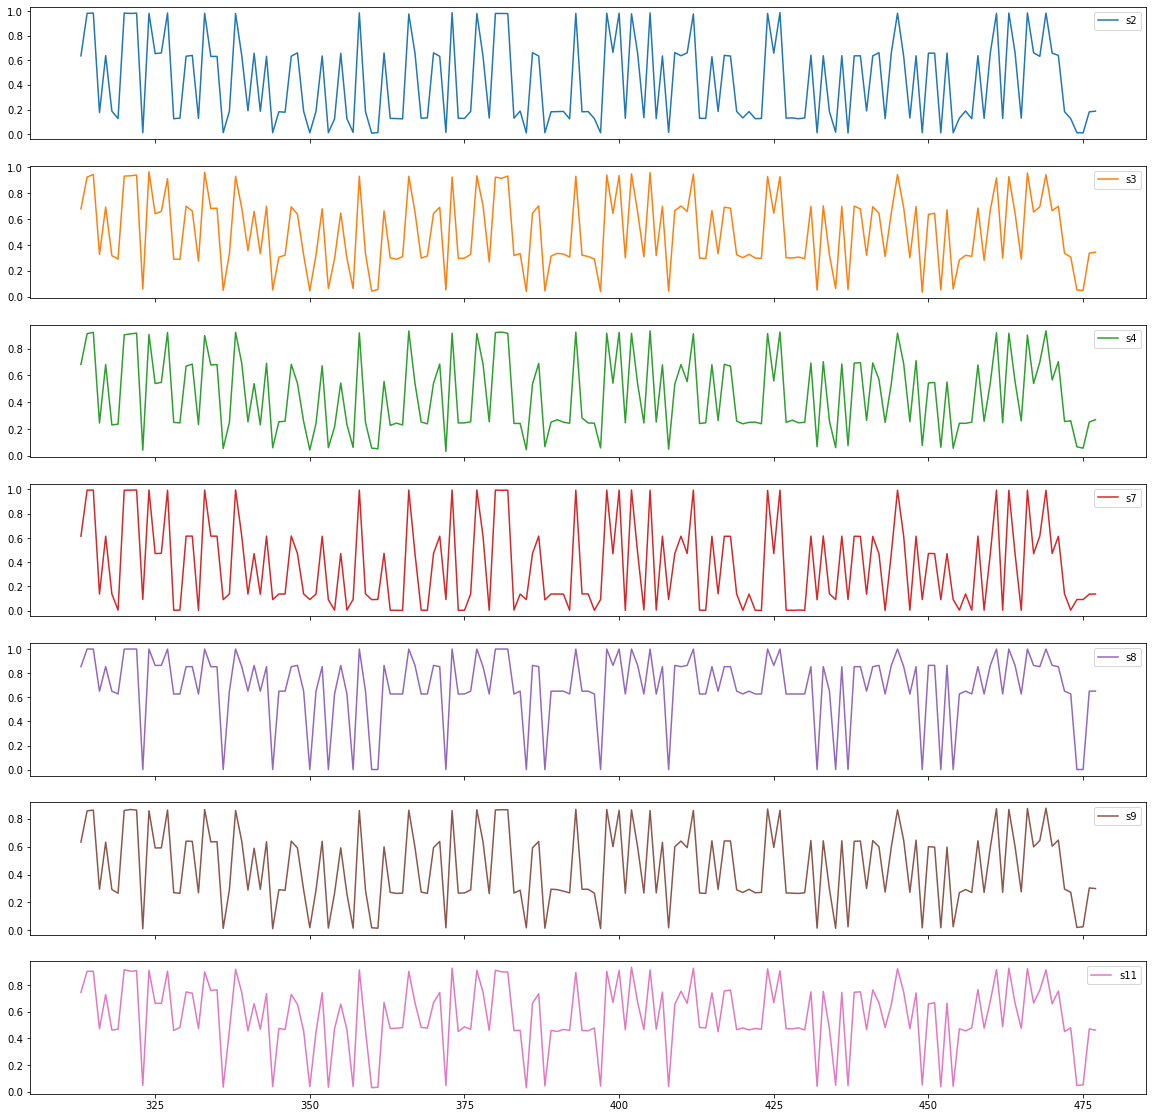

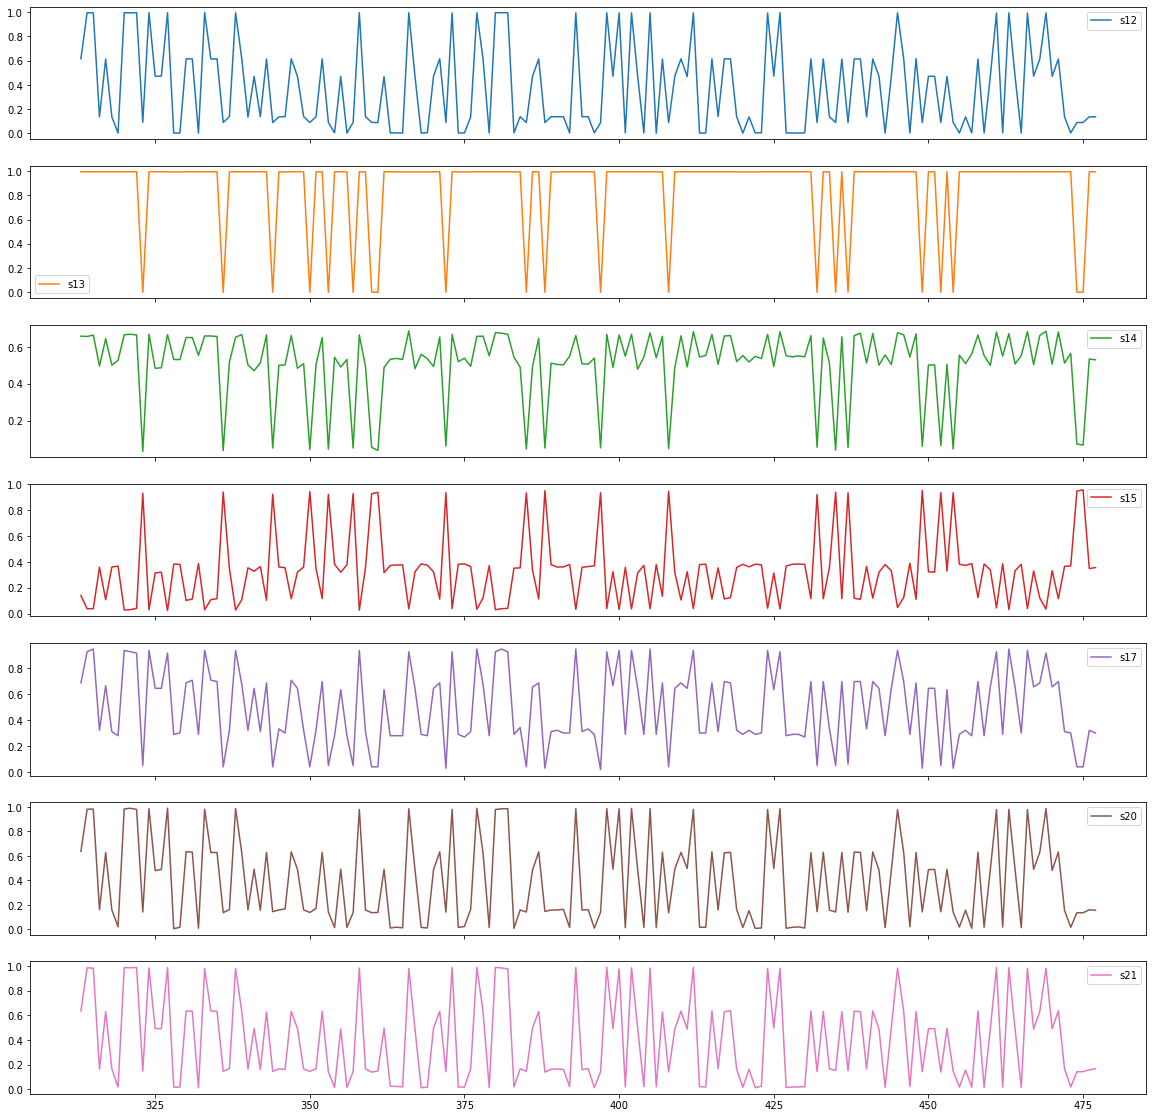

In [22]:
sequence_length = 35
sequence_length_ = 20  # length of sequence for each agent distraction
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s2', 's3', 's4', 's7', 's8', 's9', 's11']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s12', 's13', 's14', 's15', 's17', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 2, 3, 4, 7, 8, 9, 11
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

# plotting sensor data for engine ID 3 prior to a failure point - sensors 12, 13, 14, 15, 17, 20, 21
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

## Generate Train Data

In [23]:
# pick the feature columns
sensor_cols = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
sequence_cols = ['setting1', 'setting2', 'cycle_norm']
sequence_cols.extend(sensor_cols)

### generator train data for the sequences for each agent and save in a list

In [24]:
# Train data
# generator train data for the sequences for each agent and save in a list
data_array_ = {}
for i in train_df['id'].unique():
    seq_gen_ = (list(gen_sequence(train_df[train_df['id'] == id], sequence_length_, sequence_cols)) for id in [i])
    data_array_[i] = np.concatenate(list(seq_gen_)).astype(np.float32)

### generate train labels for each agent and save in a list

In [25]:
label_array_ = {}
# generate train labels for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_ = (gen_labels(train_df[train_df['id'] == id], sequence_length_, ['label1']) for id in [i])
    label_array_[i] = np.concatenate(list(label_gen_)).astype(np.float32)

### Generate train labels based on RUL for each agent and save in a list

In [26]:
label_array_rul_ = {}
# Generate train labels based on RUL for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_rul_ = (gen_labels(train_df[train_df['id'] == id], sequence_length_, ['RUL']) for id in [i])
    label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)

C:\Users\LO98E8~1\Temp\234/ipykernel_41240/1920039281.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)


In [27]:
# Find the minimum length of dataset for each agent
min_length = label_array_rul_[1].shape[0]
for i in train_df['id'].unique():
    if min_length > label_array_rul_[i].shape[0]:
        min_length = label_array_rul_[i].shape[0]

In [28]:
# set all length of lists to the minimum length of arrays
for i in train_df['id'].unique():
    label_array_rul_[i] = label_array_rul_[i][len(label_array_rul_[i]) - min_length:, :]
    label_array_[i] = label_array_[i][len(label_array_[i]) - min_length:, :]
    data_array_[i] = data_array_[i][len(data_array_[i]) - min_length:, :, :]
    
print(len(data_array_))
print(len(label_array_))
print(len(label_array_rul_))

print(data_array_[1].shape)
print(label_array_[1].shape)
print(label_array_rul_[1].shape)

260
260
260
(108, 20, 17)
(108, 1)
(108, 1)


### generator test data for the sequences for each agent and save in a list

In [29]:
# Test Data
# generator test data for the sequences for each agent and save in a list
seq_array_test_ = {}
for i in test_df['id'].unique():
    seq_gen_test_ = (list(gen_sequence(test_df[test_df['id'] == id], sequence_length_, sequence_cols)) for id in
                     [i])
    seq_array_test_[i] = np.concatenate(list(seq_gen_test_)).astype(np.float32)

### generate test labels for each agent and save in a list

In [30]:
label_array_test_ = {}
# generatAe test labels for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_ = (gen_labels(test_df[test_df['id'] == id], sequence_length_, ['label1']) for id in [i])
    label_array_test_[i] = np.concatenate(list(label_gen_test_)).astype(np.float32)

### Generate test labels based on RUL for each agent and save in a list

In [31]:
label_array_test_rul_ = {}
# Generate test labels based on RUL for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_rul_ = (gen_labels(test_df[test_df['id'] == id], sequence_length_, ['RUL']) for id in [i])
    label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)

C:\Users\LO98E8~1\Temp\234/ipykernel_41240/500274830.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)


### Select part of the train set which has the length longer than min_length

In [32]:
seq_array_test_tmp = {}
label_array_test_tmp = {}
label_array_test_rul_tmp = {}
for i in test_df['id'].unique():
    tmp = seq_array_test_[i].shape[0]
    if tmp >= min_length:
        seq_array_test_tmp[i] = seq_array_test_[i]
        label_array_test_tmp[i] = label_array_test_[i]
        label_array_test_rul_tmp[i] = label_array_test_rul_[i]

###  change the key of dictionary and indexing it based on increasing number from 1

In [33]:
# change the key of dictionary and indexing it based on increasing number from 1
seq_array_test_ = {}
label_array_test_ = {}
label_array_test_rul_ = {}
j = 1
for i in seq_array_test_tmp.keys():
    seq_array_test_[j] = seq_array_test_tmp[i]
    label_array_test_[j] = label_array_test_tmp[i]
    label_array_test_rul_[j] = label_array_test_rul_tmp[i]
    j += 1

del seq_array_test_tmp
del label_array_test_tmp
del label_array_test_rul_tmp

# set all length of test lists to the minimum length of arrays (min_length)
for i in seq_array_test_.keys():
    label_array_test_rul_[i] = label_array_test_rul_[i][len(label_array_test_rul_[i]) - min_length:, :]
    label_array_test_[i] = label_array_test_[i][len(label_array_test_[i]) - min_length:, :]
    seq_array_test_[i] = seq_array_test_[i][len(seq_array_test_[i]) - min_length:, :, :]

print(len(seq_array_test_))
print(len(label_array_test_))
print(len(label_array_test_rul_))

print(seq_array_test_[1].shape)
print(label_array_test_[1].shape)
print(label_array_test_rul_[1].shape)

X = {}
Y = {}
for i in data_array_.keys():
    X[i - 1] = data_array_[i].reshape(min_length, -1)
    Y[i - 1] = label_array_rul_[i]

X_test = {}
Y_test = {}
for i in seq_array_test_.keys():
    X_test[i - 1] = seq_array_test_[i].reshape(min_length, -1)
    Y_test[i - 1] = label_array_test_rul_[i]

137
137
137
(108, 20, 17)
(108, 1)
(108, 1)


## The main distributed LSTM model for 10 worker, in case of master and workers

In [34]:
num_workers = 10
array_params = [dict() for i in range(num_workers)]
J = [list() for i in range(num_workers)]

worker_model = {}
for worker_i in range(num_workers):
    worker_model[worker_i] = LSTM()
    array_params[worker_i] = worker_model[worker_i].init_random_params()

iteration_epoch = 3000
for i in range(iteration_epoch):
    print("Number of iteration:", i, "/from", iteration_epoch)
    for worker_i in range(num_workers):
        cost, array_params[worker_i] = worker_model[worker_i].train(X[worker_i], Y[worker_i],
                                                                    array_params[worker_i])
        J[worker_i].append(cost)

    for key in array_params[0]:  # Fed average
        tmp = array_params[0][key]
        for worker_i in range(1, num_workers):
            tmp = tmp + array_params[worker_i][key]
        for worker_i in range(num_workers):
            array_params[worker_i][key] = (1 / num_workers) * tmp  # Distribute aggregate parameters to all workers

Number of iteration: 0 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Number of iteration: 1 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 1 	Batch: 50 - 75 	Loss: [115.39]
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 1 	Batch: 50 - 7

Epoch 1 	Batch: 50 - 75 	Loss: [115.05]
Number of iteration: 10 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [115.06]
Epoch 1 	Batch: 50 - 75 	Loss: [115.03]
Epoch 0 	Batch: 50 - 75 	Loss: [115.09]
Epoch 1 	Batch: 50 - 75 	Loss: [115.07]
Epoch 0 	Batch: 50 - 75 	Loss: [115.07]
Epoch 1 	Batch: 50 - 75 	Loss: [115.04]
Epoch 0 	Batch: 50 - 75 	Loss: [115.05]
Epoch 1 	Batch: 50 - 75 	Loss: [115.03]
Epoch 0 	Batch: 50 - 75 	Loss: [115.03]
Epoch 1 	Batch: 50 - 75 	Loss: [115.]
Epoch 0 	Batch: 50 - 75 	Loss: [115.06]
Epoch 1 	Batch: 50 - 75 	Loss: [115.04]
Epoch 0 	Batch: 50 - 75 	Loss: [115.08]
Epoch 1 	Batch: 50 - 75 	Loss: [115.06]
Epoch 0 	Batch: 50 - 75 	Loss: [115.09]
Epoch 1 	Batch: 50 - 75 	Loss: [115.07]
Epoch 0 	Batch: 50 - 75 	Loss: [115.08]
Epoch 1 	Batch: 50 - 75 	Loss: [115.06]
Epoch 0 	Batch: 50 - 75 	Loss: [115.02]
Epoch 1 	Batch: 50 - 75 	Loss: [114.99]
Number of iteration: 11 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [115.01]
Epoch 1 	Batch: 50 - 75 	Loss: [114.98]
Epoch 0 	Bat

Epoch 1 	Batch: 50 - 75 	Loss: [114.44]
Epoch 0 	Batch: 50 - 75 	Loss: [114.32]
Epoch 1 	Batch: 50 - 75 	Loss: [114.27]
Number of iteration: 20 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [114.36]
Epoch 1 	Batch: 50 - 75 	Loss: [114.31]
Epoch 0 	Batch: 50 - 75 	Loss: [114.54]
Epoch 1 	Batch: 50 - 75 	Loss: [114.51]
Epoch 0 	Batch: 50 - 75 	Loss: [114.35]
Epoch 1 	Batch: 50 - 75 	Loss: [114.3]
Epoch 0 	Batch: 50 - 75 	Loss: [114.22]
Epoch 1 	Batch: 50 - 75 	Loss: [114.16]
Epoch 0 	Batch: 50 - 75 	Loss: [114.3]
Epoch 1 	Batch: 50 - 75 	Loss: [114.25]
Epoch 0 	Batch: 50 - 75 	Loss: [114.31]
Epoch 1 	Batch: 50 - 75 	Loss: [114.26]
Epoch 0 	Batch: 50 - 75 	Loss: [114.39]
Epoch 1 	Batch: 50 - 75 	Loss: [114.34]
Epoch 0 	Batch: 50 - 75 	Loss: [114.47]
Epoch 1 	Batch: 50 - 75 	Loss: [114.44]
Epoch 0 	Batch: 50 - 75 	Loss: [114.39]
Epoch 1 	Batch: 50 - 75 	Loss: [114.33]
Epoch 0 	Batch: 50 - 75 	Loss: [114.21]
Epoch 1 	Batch: 50 - 75 	Loss: [114.15]
Number of iteration: 21 /from 3000
Epoch 0 	Bat

Epoch 1 	Batch: 50 - 75 	Loss: [113.32]
Epoch 0 	Batch: 50 - 75 	Loss: [113.25]
Epoch 1 	Batch: 50 - 75 	Loss: [113.16]
Epoch 0 	Batch: 50 - 75 	Loss: [112.93]
Epoch 1 	Batch: 50 - 75 	Loss: [112.86]
Number of iteration: 30 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [113.06]
Epoch 1 	Batch: 50 - 75 	Loss: [112.98]
Epoch 0 	Batch: 50 - 75 	Loss: [113.72]
Epoch 1 	Batch: 50 - 75 	Loss: [113.65]
Epoch 0 	Batch: 50 - 75 	Loss: [112.8]
Epoch 1 	Batch: 50 - 75 	Loss: [112.69]
Epoch 0 	Batch: 50 - 75 	Loss: [112.75]
Epoch 1 	Batch: 50 - 75 	Loss: [112.65]
Epoch 0 	Batch: 50 - 75 	Loss: [112.97]
Epoch 1 	Batch: 50 - 75 	Loss: [112.89]
Epoch 0 	Batch: 50 - 75 	Loss: [112.69]
Epoch 1 	Batch: 50 - 75 	Loss: [112.59]
Epoch 0 	Batch: 50 - 75 	Loss: [113.07]
Epoch 1 	Batch: 50 - 75 	Loss: [113.01]
Epoch 0 	Batch: 50 - 75 	Loss: [113.25]
Epoch 1 	Batch: 50 - 75 	Loss: [113.2]
Epoch 0 	Batch: 50 - 75 	Loss: [113.08]
Epoch 1 	Batch: 50 - 75 	Loss: [113.]
Epoch 0 	Batch: 50 - 75 	Loss: [112.82]
Epoch 1 	

Epoch 1 	Batch: 50 - 75 	Loss: [111.38]
Epoch 0 	Batch: 50 - 75 	Loss: [111.87]
Epoch 1 	Batch: 50 - 75 	Loss: [111.77]
Epoch 0 	Batch: 50 - 75 	Loss: [111.44]
Epoch 1 	Batch: 50 - 75 	Loss: [111.34]
Epoch 0 	Batch: 50 - 75 	Loss: [111.28]
Epoch 1 	Batch: 50 - 75 	Loss: [111.17]
Number of iteration: 40 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [111.34]
Epoch 1 	Batch: 50 - 75 	Loss: [111.24]
Epoch 0 	Batch: 50 - 75 	Loss: [112.62]
Epoch 1 	Batch: 50 - 75 	Loss: [112.53]
Epoch 0 	Batch: 50 - 75 	Loss: [110.65]
Epoch 1 	Batch: 50 - 75 	Loss: [110.53]
Epoch 0 	Batch: 50 - 75 	Loss: [110.96]
Epoch 1 	Batch: 50 - 75 	Loss: [110.85]
Epoch 0 	Batch: 50 - 75 	Loss: [111.24]
Epoch 1 	Batch: 50 - 75 	Loss: [111.13]
Epoch 0 	Batch: 50 - 75 	Loss: [110.7]
Epoch 1 	Batch: 50 - 75 	Loss: [110.59]
Epoch 0 	Batch: 50 - 75 	Loss: [111.29]
Epoch 1 	Batch: 50 - 75 	Loss: [111.19]
Epoch 0 	Batch: 50 - 75 	Loss: [111.68]
Epoch 1 	Batch: 50 - 75 	Loss: [111.58]
Epoch 0 	Batch: 50 - 75 	Loss: [111.24]
Epoch 

Epoch 1 	Batch: 50 - 75 	Loss: [108.37]
Epoch 0 	Batch: 50 - 75 	Loss: [109.29]
Epoch 1 	Batch: 50 - 75 	Loss: [109.17]
Epoch 0 	Batch: 50 - 75 	Loss: [109.76]
Epoch 1 	Batch: 50 - 75 	Loss: [109.66]
Epoch 0 	Batch: 50 - 75 	Loss: [109.34]
Epoch 1 	Batch: 50 - 75 	Loss: [109.24]
Epoch 0 	Batch: 50 - 75 	Loss: [109.13]
Epoch 1 	Batch: 50 - 75 	Loss: [109.]
Number of iteration: 50 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [109.25]
Epoch 1 	Batch: 50 - 75 	Loss: [109.15]
Epoch 0 	Batch: 50 - 75 	Loss: [111.24]
Epoch 1 	Batch: 50 - 75 	Loss: [111.14]
Epoch 0 	Batch: 50 - 75 	Loss: [108.11]
Epoch 1 	Batch: 50 - 75 	Loss: [107.97]
Epoch 0 	Batch: 50 - 75 	Loss: [108.88]
Epoch 1 	Batch: 50 - 75 	Loss: [108.76]
Epoch 0 	Batch: 50 - 75 	Loss: [109.15]
Epoch 1 	Batch: 50 - 75 	Loss: [109.05]
Epoch 0 	Batch: 50 - 75 	Loss: [108.24]
Epoch 1 	Batch: 50 - 75 	Loss: [108.1]
Epoch 0 	Batch: 50 - 75 	Loss: [109.04]
Epoch 1 	Batch: 50 - 75 	Loss: [108.92]
Epoch 0 	Batch: 50 - 75 	Loss: [109.55]
Epoch 1 

Epoch 1 	Batch: 50 - 75 	Loss: [107.08]
Epoch 0 	Batch: 50 - 75 	Loss: [105.9]
Epoch 1 	Batch: 50 - 75 	Loss: [105.76]
Epoch 0 	Batch: 50 - 75 	Loss: [106.87]
Epoch 1 	Batch: 50 - 75 	Loss: [106.75]
Epoch 0 	Batch: 50 - 75 	Loss: [107.45]
Epoch 1 	Batch: 50 - 75 	Loss: [107.34]
Epoch 0 	Batch: 50 - 75 	Loss: [107.29]
Epoch 1 	Batch: 50 - 75 	Loss: [107.17]
Epoch 0 	Batch: 50 - 75 	Loss: [106.8]
Epoch 1 	Batch: 50 - 75 	Loss: [106.66]
Number of iteration: 60 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [106.97]
Epoch 1 	Batch: 50 - 75 	Loss: [106.86]
Epoch 0 	Batch: 50 - 75 	Loss: [109.75]
Epoch 1 	Batch: 50 - 75 	Loss: [109.65]
Epoch 0 	Batch: 50 - 75 	Loss: [105.42]
Epoch 1 	Batch: 50 - 75 	Loss: [105.27]
Epoch 0 	Batch: 50 - 75 	Loss: [106.6]
Epoch 1 	Batch: 50 - 75 	Loss: [106.47]
Epoch 0 	Batch: 50 - 75 	Loss: [106.96]
Epoch 1 	Batch: 50 - 75 	Loss: [106.9]
Epoch 0 	Batch: 50 - 75 	Loss: [105.64]
Epoch 1 	Batch: 50 - 75 	Loss: [105.51]
Epoch 0 	Batch: 50 - 75 	Loss: [106.64]
Epoch 1 	

Epoch 1 	Batch: 50 - 75 	Loss: [104.21]
Epoch 0 	Batch: 50 - 75 	Loss: [105.27]
Epoch 1 	Batch: 50 - 75 	Loss: [105.13]
Epoch 0 	Batch: 50 - 75 	Loss: [103.33]
Epoch 1 	Batch: 50 - 75 	Loss: [103.18]
Epoch 0 	Batch: 50 - 75 	Loss: [104.49]
Epoch 1 	Batch: 50 - 75 	Loss: [104.36]
Epoch 0 	Batch: 50 - 75 	Loss: [105.26]
Epoch 1 	Batch: 50 - 75 	Loss: [105.12]
Epoch 0 	Batch: 50 - 75 	Loss: [104.91]
Epoch 1 	Batch: 50 - 75 	Loss: [104.78]
Epoch 0 	Batch: 50 - 75 	Loss: [104.33]
Epoch 1 	Batch: 50 - 75 	Loss: [104.19]
Number of iteration: 70 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [104.79]
Epoch 1 	Batch: 50 - 75 	Loss: [104.68]
Epoch 0 	Batch: 50 - 75 	Loss: [108.54]
Epoch 1 	Batch: 50 - 75 	Loss: [108.41]
Epoch 0 	Batch: 50 - 75 	Loss: [102.62]
Epoch 1 	Batch: 50 - 75 	Loss: [102.47]
Epoch 0 	Batch: 50 - 75 	Loss: [104.07]
Epoch 1 	Batch: 50 - 75 	Loss: [103.93]
Epoch 0 	Batch: 50 - 75 	Loss: [105.03]
Epoch 1 	Batch: 50 - 75 	Loss: [104.94]
Epoch 0 	Batch: 50 - 75 	Loss: [103.05]
Epoch

Epoch 1 	Batch: 50 - 75 	Loss: [99.81]
Epoch 0 	Batch: 50 - 75 	Loss: [101.61]
Epoch 1 	Batch: 50 - 75 	Loss: [101.49]
Epoch 0 	Batch: 50 - 75 	Loss: [102.8]
Epoch 1 	Batch: 50 - 75 	Loss: [102.66]
Epoch 0 	Batch: 50 - 75 	Loss: [100.69]
Epoch 1 	Batch: 50 - 75 	Loss: [100.56]
Epoch 0 	Batch: 50 - 75 	Loss: [102.05]
Epoch 1 	Batch: 50 - 75 	Loss: [101.94]
Epoch 0 	Batch: 50 - 75 	Loss: [103.04]
Epoch 1 	Batch: 50 - 75 	Loss: [102.91]
Epoch 0 	Batch: 50 - 75 	Loss: [102.47]
Epoch 1 	Batch: 50 - 75 	Loss: [102.34]
Epoch 0 	Batch: 50 - 75 	Loss: [101.75]
Epoch 1 	Batch: 50 - 75 	Loss: [101.6]
Number of iteration: 80 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [102.32]
Epoch 1 	Batch: 50 - 75 	Loss: [102.19]
Epoch 0 	Batch: 50 - 75 	Loss: [106.68]
Epoch 1 	Batch: 50 - 75 	Loss: [106.54]
Epoch 0 	Batch: 50 - 75 	Loss: [99.64]
Epoch 1 	Batch: 50 - 75 	Loss: [99.48]
Epoch 0 	Batch: 50 - 75 	Loss: [101.36]
Epoch 1 	Batch: 50 - 75 	Loss: [101.2]
Epoch 0 	Batch: 50 - 75 	Loss: [102.53]
Epoch 1 	Ba

Epoch 1 	Batch: 50 - 75 	Loss: [104.57]
Epoch 0 	Batch: 50 - 75 	Loss: [96.77]
Epoch 1 	Batch: 50 - 75 	Loss: [96.61]
Epoch 0 	Batch: 50 - 75 	Loss: [98.59]
Epoch 1 	Batch: 50 - 75 	Loss: [98.43]
Epoch 0 	Batch: 50 - 75 	Loss: [100.01]
Epoch 1 	Batch: 50 - 75 	Loss: [99.86]
Epoch 0 	Batch: 50 - 75 	Loss: [97.87]
Epoch 1 	Batch: 50 - 75 	Loss: [97.72]
Epoch 0 	Batch: 50 - 75 	Loss: [99.33]
Epoch 1 	Batch: 50 - 75 	Loss: [99.19]
Epoch 0 	Batch: 50 - 75 	Loss: [100.36]
Epoch 1 	Batch: 50 - 75 	Loss: [100.21]
Epoch 0 	Batch: 50 - 75 	Loss: [99.86]
Epoch 1 	Batch: 50 - 75 	Loss: [99.73]
Epoch 0 	Batch: 50 - 75 	Loss: [98.96]
Epoch 1 	Batch: 50 - 75 	Loss: [98.8]
Number of iteration: 90 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [99.59]
Epoch 1 	Batch: 50 - 75 	Loss: [99.43]
Epoch 0 	Batch: 50 - 75 	Loss: [104.48]
Epoch 1 	Batch: 50 - 75 	Loss: [104.33]
Epoch 0 	Batch: 50 - 75 	Loss: [96.44]
Epoch 1 	Batch: 50 - 75 	Loss: [96.27]
Epoch 0 	Batch: 50 - 75 	Loss: [98.3]
Epoch 1 	Batch: 50 - 75 	

Epoch 1 	Batch: 50 - 75 	Loss: [93.24]
Epoch 0 	Batch: 50 - 75 	Loss: [95.37]
Epoch 1 	Batch: 50 - 75 	Loss: [95.19]
Epoch 0 	Batch: 50 - 75 	Loss: [97.06]
Epoch 1 	Batch: 50 - 75 	Loss: [96.9]
Epoch 0 	Batch: 50 - 75 	Loss: [94.89]
Epoch 1 	Batch: 50 - 75 	Loss: [94.74]
Epoch 0 	Batch: 50 - 75 	Loss: [96.41]
Epoch 1 	Batch: 50 - 75 	Loss: [96.26]
Epoch 0 	Batch: 50 - 75 	Loss: [97.42]
Epoch 1 	Batch: 50 - 75 	Loss: [97.27]
Epoch 0 	Batch: 50 - 75 	Loss: [97.12]
Epoch 1 	Batch: 50 - 75 	Loss: [96.98]
Epoch 0 	Batch: 50 - 75 	Loss: [96.06]
Epoch 1 	Batch: 50 - 75 	Loss: [95.91]
Number of iteration: 100 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [96.69]
Epoch 1 	Batch: 50 - 75 	Loss: [96.54]
Epoch 0 	Batch: 50 - 75 	Loss: [102.09]
Epoch 1 	Batch: 50 - 75 	Loss: [101.92]
Epoch 0 	Batch: 50 - 75 	Loss: [93.07]
Epoch 1 	Batch: 50 - 75 	Loss: [92.89]
Epoch 0 	Batch: 50 - 75 	Loss: [95.04]
Epoch 1 	Batch: 50 - 75 	Loss: [94.87]
Epoch 0 	Batch: 50 - 75 	Loss: [96.75]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [91.83]
Epoch 0 	Batch: 50 - 75 	Loss: [94.03]
Epoch 1 	Batch: 50 - 75 	Loss: [93.88]
Epoch 0 	Batch: 50 - 75 	Loss: [91.8]
Epoch 1 	Batch: 50 - 75 	Loss: [91.64]
Epoch 0 	Batch: 50 - 75 	Loss: [93.37]
Epoch 1 	Batch: 50 - 75 	Loss: [93.22]
Epoch 0 	Batch: 50 - 75 	Loss: [94.37]
Epoch 1 	Batch: 50 - 75 	Loss: [94.24]
Epoch 0 	Batch: 50 - 75 	Loss: [94.28]
Epoch 1 	Batch: 50 - 75 	Loss: [94.14]
Epoch 0 	Batch: 50 - 75 	Loss: [93.1]
Epoch 1 	Batch: 50 - 75 	Loss: [92.95]
Number of iteration: 110 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [93.71]
Epoch 1 	Batch: 50 - 75 	Loss: [93.56]
Epoch 0 	Batch: 50 - 75 	Loss: [99.41]
Epoch 1 	Batch: 50 - 75 	Loss: [99.24]
Epoch 0 	Batch: 50 - 75 	Loss: [89.61]
Epoch 1 	Batch: 50 - 75 	Loss: [89.43]
Epoch 0 	Batch: 50 - 75 	Loss: [91.67]
Epoch 1 	Batch: 50 - 75 	Loss: [91.49]
Epoch 0 	Batch: 50 - 75 	Loss: [93.73]
Epoch 1 	Batch: 50 - 75 	Loss: [93.58]
Epoch 0 	Batch: 50 - 75 	Loss: [91.49]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [90.93]
Epoch 0 	Batch: 50 - 75 	Loss: [88.65]
Epoch 1 	Batch: 50 - 75 	Loss: [88.49]
Epoch 0 	Batch: 50 - 75 	Loss: [90.32]
Epoch 1 	Batch: 50 - 75 	Loss: [90.18]
Epoch 0 	Batch: 50 - 75 	Loss: [91.32]
Epoch 1 	Batch: 50 - 75 	Loss: [91.16]
Epoch 0 	Batch: 50 - 75 	Loss: [91.38]
Epoch 1 	Batch: 50 - 75 	Loss: [91.23]
Epoch 0 	Batch: 50 - 75 	Loss: [90.1]
Epoch 1 	Batch: 50 - 75 	Loss: [89.94]
Number of iteration: 120 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [90.66]
Epoch 1 	Batch: 50 - 75 	Loss: [90.52]
Epoch 0 	Batch: 50 - 75 	Loss: [96.59]
Epoch 1 	Batch: 50 - 75 	Loss: [96.42]
Epoch 0 	Batch: 50 - 75 	Loss: [86.08]
Epoch 1 	Batch: 50 - 75 	Loss: [85.9]
Epoch 0 	Batch: 50 - 75 	Loss: [88.31]
Epoch 1 	Batch: 50 - 75 	Loss: [88.13]
Epoch 0 	Batch: 50 - 75 	Loss: [90.77]
Epoch 1 	Batch: 50 - 75 	Loss: [90.62]
Epoch 0 	Batch: 50 - 75 	Loss: [88.32]
Epoch 1 	Batch: 50 - 75 	Loss: [88.16]
Epoch 0 	Batch: 50 - 75 	Loss: [90.03]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [85.4]
Epoch 0 	Batch: 50 - 75 	Loss: [87.25]
Epoch 1 	Batch: 50 - 75 	Loss: [87.1]
Epoch 0 	Batch: 50 - 75 	Loss: [88.42]
Epoch 1 	Batch: 50 - 75 	Loss: [88.29]
Epoch 0 	Batch: 50 - 75 	Loss: [88.52]
Epoch 1 	Batch: 50 - 75 	Loss: [88.37]
Epoch 0 	Batch: 50 - 75 	Loss: [87.11]
Epoch 1 	Batch: 50 - 75 	Loss: [86.96]
Number of iteration: 130 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [87.67]
Epoch 1 	Batch: 50 - 75 	Loss: [87.5]
Epoch 0 	Batch: 50 - 75 	Loss: [93.73]
Epoch 1 	Batch: 50 - 75 	Loss: [93.58]
Epoch 0 	Batch: 50 - 75 	Loss: [82.53]
Epoch 1 	Batch: 50 - 75 	Loss: [82.35]
Epoch 0 	Batch: 50 - 75 	Loss: [85.04]
Epoch 1 	Batch: 50 - 75 	Loss: [84.87]
Epoch 0 	Batch: 50 - 75 	Loss: [87.93]
Epoch 1 	Batch: 50 - 75 	Loss: [87.77]
Epoch 0 	Batch: 50 - 75 	Loss: [85.24]
Epoch 1 	Batch: 50 - 75 	Loss: [85.08]
Epoch 0 	Batch: 50 - 75 	Loss: [86.94]
Epoch 1 	Batch: 50 - 75 	Loss: [86.78]
Epoch 0 	Batch: 50 - 75 	Loss: [88.13]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [83.95]
Epoch 0 	Batch: 50 - 75 	Loss: [85.47]
Epoch 1 	Batch: 50 - 75 	Loss: [85.32]
Epoch 0 	Batch: 50 - 75 	Loss: [85.64]
Epoch 1 	Batch: 50 - 75 	Loss: [85.51]
Epoch 0 	Batch: 50 - 75 	Loss: [84.15]
Epoch 1 	Batch: 50 - 75 	Loss: [84.]
Number of iteration: 140 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [84.57]
Epoch 1 	Batch: 50 - 75 	Loss: [84.43]
Epoch 0 	Batch: 50 - 75 	Loss: [90.96]
Epoch 1 	Batch: 50 - 75 	Loss: [90.79]
Epoch 0 	Batch: 50 - 75 	Loss: [79.]
Epoch 1 	Batch: 50 - 75 	Loss: [78.82]
Epoch 0 	Batch: 50 - 75 	Loss: [81.79]
Epoch 1 	Batch: 50 - 75 	Loss: [81.61]
Epoch 0 	Batch: 50 - 75 	Loss: [84.94]
Epoch 1 	Batch: 50 - 75 	Loss: [84.79]
Epoch 0 	Batch: 50 - 75 	Loss: [82.07]
Epoch 1 	Batch: 50 - 75 	Loss: [81.92]
Epoch 0 	Batch: 50 - 75 	Loss: [83.79]
Epoch 1 	Batch: 50 - 75 	Loss: [83.64]
Epoch 0 	Batch: 50 - 75 	Loss: [85.18]
Epoch 1 	Batch: 50 - 75 	Loss: [85.04]
Epoch 0 	Batch: 50 - 75 	Loss: [85.37]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [82.4]
Epoch 0 	Batch: 50 - 75 	Loss: [82.83]
Epoch 1 	Batch: 50 - 75 	Loss: [82.69]
Epoch 0 	Batch: 50 - 75 	Loss: [81.21]
Epoch 1 	Batch: 50 - 75 	Loss: [81.06]
Number of iteration: 150 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [81.38]
Epoch 1 	Batch: 50 - 75 	Loss: [81.23]
Epoch 0 	Batch: 50 - 75 	Loss: [88.2]
Epoch 1 	Batch: 50 - 75 	Loss: [88.03]
Epoch 0 	Batch: 50 - 75 	Loss: [75.51]
Epoch 1 	Batch: 50 - 75 	Loss: [75.33]
Epoch 0 	Batch: 50 - 75 	Loss: [78.43]
Epoch 1 	Batch: 50 - 75 	Loss: [78.27]
Epoch 0 	Batch: 50 - 75 	Loss: [81.98]
Epoch 1 	Batch: 50 - 75 	Loss: [81.86]
Epoch 0 	Batch: 50 - 75 	Loss: [78.93]
Epoch 1 	Batch: 50 - 75 	Loss: [78.78]
Epoch 0 	Batch: 50 - 75 	Loss: [80.78]
Epoch 1 	Batch: 50 - 75 	Loss: [80.64]
Epoch 0 	Batch: 50 - 75 	Loss: [82.26]
Epoch 1 	Batch: 50 - 75 	Loss: [82.12]
Epoch 0 	Batch: 50 - 75 	Loss: [82.55]
Epoch 1 	Batch: 50 - 75 	Loss: [82.4]
Epoch 0 	Batch: 50 - 75 	Loss: [80.92]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [79.83]
Epoch 0 	Batch: 50 - 75 	Loss: [78.32]
Epoch 1 	Batch: 50 - 75 	Loss: [78.17]
Number of iteration: 160 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [78.21]
Epoch 1 	Batch: 50 - 75 	Loss: [78.06]
Epoch 0 	Batch: 50 - 75 	Loss: [85.47]
Epoch 1 	Batch: 50 - 75 	Loss: [85.31]
Epoch 0 	Batch: 50 - 75 	Loss: [72.08]
Epoch 1 	Batch: 50 - 75 	Loss: [71.91]
Epoch 0 	Batch: 50 - 75 	Loss: [75.13]
Epoch 1 	Batch: 50 - 75 	Loss: [74.96]
Epoch 0 	Batch: 50 - 75 	Loss: [79.13]
Epoch 1 	Batch: 50 - 75 	Loss: [79.]
Epoch 0 	Batch: 50 - 75 	Loss: [75.82]
Epoch 1 	Batch: 50 - 75 	Loss: [75.67]
Epoch 0 	Batch: 50 - 75 	Loss: [77.69]
Epoch 1 	Batch: 50 - 75 	Loss: [77.54]
Epoch 0 	Batch: 50 - 75 	Loss: [79.41]
Epoch 1 	Batch: 50 - 75 	Loss: [79.26]
Epoch 0 	Batch: 50 - 75 	Loss: [79.69]
Epoch 1 	Batch: 50 - 75 	Loss: [79.56]
Epoch 0 	Batch: 50 - 75 	Loss: [78.03]
Epoch 1 	Batch: 50 - 75 	Loss: [77.88]
Number of iteration: 161 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7

Epoch 1 	Batch: 50 - 75 	Loss: [75.3]
Number of iteration: 170 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [75.08]
Epoch 1 	Batch: 50 - 75 	Loss: [74.93]
Epoch 0 	Batch: 50 - 75 	Loss: [82.8]
Epoch 1 	Batch: 50 - 75 	Loss: [82.64]
Epoch 0 	Batch: 50 - 75 	Loss: [68.74]
Epoch 1 	Batch: 50 - 75 	Loss: [68.57]
Epoch 0 	Batch: 50 - 75 	Loss: [71.86]
Epoch 1 	Batch: 50 - 75 	Loss: [71.69]
Epoch 0 	Batch: 50 - 75 	Loss: [76.28]
Epoch 1 	Batch: 50 - 75 	Loss: [76.14]
Epoch 0 	Batch: 50 - 75 	Loss: [72.71]
Epoch 1 	Batch: 50 - 75 	Loss: [72.57]
Epoch 0 	Batch: 50 - 75 	Loss: [74.7]
Epoch 1 	Batch: 50 - 75 	Loss: [74.54]
Epoch 0 	Batch: 50 - 75 	Loss: [76.58]
Epoch 1 	Batch: 50 - 75 	Loss: [76.44]
Epoch 0 	Batch: 50 - 75 	Loss: [76.93]
Epoch 1 	Batch: 50 - 75 	Loss: [76.78]
Epoch 0 	Batch: 50 - 75 	Loss: [75.16]
Epoch 1 	Batch: 50 - 75 	Loss: [75.01]
Number of iteration: 171 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [74.77]
Epoch 1 	Batch: 50 - 75 	Loss: [74.62]
Epoch 0 	Batch: 50 - 75 	Loss: [82

Epoch 1 	Batch: 50 - 75 	Loss: [71.84]
Epoch 0 	Batch: 50 - 75 	Loss: [80.16]
Epoch 1 	Batch: 50 - 75 	Loss: [80.]
Epoch 0 	Batch: 50 - 75 	Loss: [65.48]
Epoch 1 	Batch: 50 - 75 	Loss: [65.32]
Epoch 0 	Batch: 50 - 75 	Loss: [68.64]
Epoch 1 	Batch: 50 - 75 	Loss: [68.48]
Epoch 0 	Batch: 50 - 75 	Loss: [73.41]
Epoch 1 	Batch: 50 - 75 	Loss: [73.27]
Epoch 0 	Batch: 50 - 75 	Loss: [69.65]
Epoch 1 	Batch: 50 - 75 	Loss: [69.51]
Epoch 0 	Batch: 50 - 75 	Loss: [71.65]
Epoch 1 	Batch: 50 - 75 	Loss: [71.51]
Epoch 0 	Batch: 50 - 75 	Loss: [73.79]
Epoch 1 	Batch: 50 - 75 	Loss: [73.66]
Epoch 0 	Batch: 50 - 75 	Loss: [74.18]
Epoch 1 	Batch: 50 - 75 	Loss: [74.04]
Epoch 0 	Batch: 50 - 75 	Loss: [72.31]
Epoch 1 	Batch: 50 - 75 	Loss: [72.17]
Number of iteration: 181 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [71.69]
Epoch 1 	Batch: 50 - 75 	Loss: [71.54]
Epoch 0 	Batch: 50 - 75 	Loss: [79.89]
Epoch 1 	Batch: 50 - 75 	Loss: [79.74]
Epoch 0 	Batch: 50 - 75 	Loss: [65.16]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [77.42]
Epoch 0 	Batch: 50 - 75 	Loss: [62.33]
Epoch 1 	Batch: 50 - 75 	Loss: [62.18]
Epoch 0 	Batch: 50 - 75 	Loss: [65.51]
Epoch 1 	Batch: 50 - 75 	Loss: [65.35]
Epoch 0 	Batch: 50 - 75 	Loss: [70.53]
Epoch 1 	Batch: 50 - 75 	Loss: [70.38]
Epoch 0 	Batch: 50 - 75 	Loss: [66.65]
Epoch 1 	Batch: 50 - 75 	Loss: [66.5]
Epoch 0 	Batch: 50 - 75 	Loss: [68.82]
Epoch 1 	Batch: 50 - 75 	Loss: [68.66]
Epoch 0 	Batch: 50 - 75 	Loss: [71.16]
Epoch 1 	Batch: 50 - 75 	Loss: [71.02]
Epoch 0 	Batch: 50 - 75 	Loss: [71.48]
Epoch 1 	Batch: 50 - 75 	Loss: [71.34]
Epoch 0 	Batch: 50 - 75 	Loss: [69.55]
Epoch 1 	Batch: 50 - 75 	Loss: [69.41]
Number of iteration: 191 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [68.68]
Epoch 1 	Batch: 50 - 75 	Loss: [68.53]
Epoch 0 	Batch: 50 - 75 	Loss: [77.31]
Epoch 1 	Batch: 50 - 75 	Loss: [77.15]
Epoch 0 	Batch: 50 - 75 	Loss: [62.03]
Epoch 1 	Batch: 50 - 75 	Loss: [61.88]
Epoch 0 	Batch: 50 - 75 	Loss: [65.19]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [59.16]
Epoch 0 	Batch: 50 - 75 	Loss: [62.44]
Epoch 1 	Batch: 50 - 75 	Loss: [62.29]
Epoch 0 	Batch: 50 - 75 	Loss: [67.74]
Epoch 1 	Batch: 50 - 75 	Loss: [67.6]
Epoch 0 	Batch: 50 - 75 	Loss: [63.64]
Epoch 1 	Batch: 50 - 75 	Loss: [63.49]
Epoch 0 	Batch: 50 - 75 	Loss: [66.]
Epoch 1 	Batch: 50 - 75 	Loss: [65.87]
Epoch 0 	Batch: 50 - 75 	Loss: [68.52]
Epoch 1 	Batch: 50 - 75 	Loss: [68.38]
Epoch 0 	Batch: 50 - 75 	Loss: [68.82]
Epoch 1 	Batch: 50 - 75 	Loss: [68.68]
Epoch 0 	Batch: 50 - 75 	Loss: [66.8]
Epoch 1 	Batch: 50 - 75 	Loss: [66.65]
Number of iteration: 201 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [65.69]
Epoch 1 	Batch: 50 - 75 	Loss: [65.54]
Epoch 0 	Batch: 50 - 75 	Loss: [74.82]
Epoch 1 	Batch: 50 - 75 	Loss: [74.67]
Epoch 0 	Batch: 50 - 75 	Loss: [59.01]
Epoch 1 	Batch: 50 - 75 	Loss: [58.86]
Epoch 0 	Batch: 50 - 75 	Loss: [62.15]
Epoch 1 	Batch: 50 - 75 	Loss: [61.99]
Epoch 0 	Batch: 50 - 75 	Loss: [67.46]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [59.35]
Epoch 0 	Batch: 50 - 75 	Loss: [65.03]
Epoch 1 	Batch: 50 - 75 	Loss: [64.89]
Epoch 0 	Batch: 50 - 75 	Loss: [60.78]
Epoch 1 	Batch: 50 - 75 	Loss: [60.63]
Epoch 0 	Batch: 50 - 75 	Loss: [63.2]
Epoch 1 	Batch: 50 - 75 	Loss: [63.06]
Epoch 0 	Batch: 50 - 75 	Loss: [66.05]
Epoch 1 	Batch: 50 - 75 	Loss: [65.91]
Epoch 0 	Batch: 50 - 75 	Loss: [66.19]
Epoch 1 	Batch: 50 - 75 	Loss: [66.05]
Epoch 0 	Batch: 50 - 75 	Loss: [64.13]
Epoch 1 	Batch: 50 - 75 	Loss: [63.99]
Number of iteration: 211 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [62.88]
Epoch 1 	Batch: 50 - 75 	Loss: [62.73]
Epoch 0 	Batch: 50 - 75 	Loss: [72.44]
Epoch 1 	Batch: 50 - 75 	Loss: [72.3]
Epoch 0 	Batch: 50 - 75 	Loss: [56.19]
Epoch 1 	Batch: 50 - 75 	Loss: [56.04]
Epoch 0 	Batch: 50 - 75 	Loss: [59.21]
Epoch 1 	Batch: 50 - 75 	Loss: [59.06]
Epoch 0 	Batch: 50 - 75 	Loss: [64.75]
Epoch 1 	Batch: 50 - 75 	Loss: [64.6]
Epoch 0 	Batch: 50 - 75 	Loss: [60.49]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [62.12]
Epoch 0 	Batch: 50 - 75 	Loss: [57.92]
Epoch 1 	Batch: 50 - 75 	Loss: [57.77]
Epoch 0 	Batch: 50 - 75 	Loss: [60.48]
Epoch 1 	Batch: 50 - 75 	Loss: [60.34]
Epoch 0 	Batch: 50 - 75 	Loss: [63.54]
Epoch 1 	Batch: 50 - 75 	Loss: [63.4]
Epoch 0 	Batch: 50 - 75 	Loss: [63.54]
Epoch 1 	Batch: 50 - 75 	Loss: [63.41]
Epoch 0 	Batch: 50 - 75 	Loss: [61.41]
Epoch 1 	Batch: 50 - 75 	Loss: [61.27]
Number of iteration: 221 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [60.03]
Epoch 1 	Batch: 50 - 75 	Loss: [59.88]
Epoch 0 	Batch: 50 - 75 	Loss: [70.17]
Epoch 1 	Batch: 50 - 75 	Loss: [70.03]
Epoch 0 	Batch: 50 - 75 	Loss: [53.37]
Epoch 1 	Batch: 50 - 75 	Loss: [53.22]
Epoch 0 	Batch: 50 - 75 	Loss: [56.34]
Epoch 1 	Batch: 50 - 75 	Loss: [56.19]
Epoch 0 	Batch: 50 - 75 	Loss: [61.98]
Epoch 1 	Batch: 50 - 75 	Loss: [61.84]
Epoch 0 	Batch: 50 - 75 	Loss: [57.64]
Epoch 1 	Batch: 50 - 75 	Loss: [57.49]
Epoch 0 	Batch: 50 - 75 	Loss: [60.2]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [54.99]
Epoch 0 	Batch: 50 - 75 	Loss: [57.82]
Epoch 1 	Batch: 50 - 75 	Loss: [57.68]
Epoch 0 	Batch: 50 - 75 	Loss: [61.05]
Epoch 1 	Batch: 50 - 75 	Loss: [60.92]
Epoch 0 	Batch: 50 - 75 	Loss: [60.94]
Epoch 1 	Batch: 50 - 75 	Loss: [60.81]
Epoch 0 	Batch: 50 - 75 	Loss: [58.74]
Epoch 1 	Batch: 50 - 75 	Loss: [58.61]
Number of iteration: 231 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [57.19]
Epoch 1 	Batch: 50 - 75 	Loss: [57.05]
Epoch 0 	Batch: 50 - 75 	Loss: [67.96]
Epoch 1 	Batch: 50 - 75 	Loss: [67.83]
Epoch 0 	Batch: 50 - 75 	Loss: [50.59]
Epoch 1 	Batch: 50 - 75 	Loss: [50.45]
Epoch 0 	Batch: 50 - 75 	Loss: [53.54]
Epoch 1 	Batch: 50 - 75 	Loss: [53.4]
Epoch 0 	Batch: 50 - 75 	Loss: [59.29]
Epoch 1 	Batch: 50 - 75 	Loss: [59.16]
Epoch 0 	Batch: 50 - 75 	Loss: [54.86]
Epoch 1 	Batch: 50 - 75 	Loss: [54.72]
Epoch 0 	Batch: 50 - 75 	Loss: [57.55]
Epoch 1 	Batch: 50 - 75 	Loss: [57.42]
Epoch 0 	Batch: 50 - 75 	Loss: [60.82]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [55.16]
Epoch 0 	Batch: 50 - 75 	Loss: [58.7]
Epoch 1 	Batch: 50 - 75 	Loss: [58.57]
Epoch 0 	Batch: 50 - 75 	Loss: [58.42]
Epoch 1 	Batch: 50 - 75 	Loss: [58.3]
Epoch 0 	Batch: 50 - 75 	Loss: [56.12]
Epoch 1 	Batch: 50 - 75 	Loss: [55.98]
Number of iteration: 241 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [54.52]
Epoch 1 	Batch: 50 - 75 	Loss: [54.38]
Epoch 0 	Batch: 50 - 75 	Loss: [65.92]
Epoch 1 	Batch: 50 - 75 	Loss: [65.79]
Epoch 0 	Batch: 50 - 75 	Loss: [47.95]
Epoch 1 	Batch: 50 - 75 	Loss: [47.82]
Epoch 0 	Batch: 50 - 75 	Loss: [50.84]
Epoch 1 	Batch: 50 - 75 	Loss: [50.7]
Epoch 0 	Batch: 50 - 75 	Loss: [56.69]
Epoch 1 	Batch: 50 - 75 	Loss: [56.56]
Epoch 0 	Batch: 50 - 75 	Loss: [52.16]
Epoch 1 	Batch: 50 - 75 	Loss: [52.02]
Epoch 0 	Batch: 50 - 75 	Loss: [55.03]
Epoch 1 	Batch: 50 - 75 	Loss: [54.9]
Epoch 0 	Batch: 50 - 75 	Loss: [58.46]
Epoch 1 	Batch: 50 - 75 	Loss: [58.34]
Epoch 0 	Batch: 50 - 75 	Loss: [58.18]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [56.23]
Epoch 0 	Batch: 50 - 75 	Loss: [55.94]
Epoch 1 	Batch: 50 - 75 	Loss: [55.82]
Epoch 0 	Batch: 50 - 75 	Loss: [53.52]
Epoch 1 	Batch: 50 - 75 	Loss: [53.39]
Number of iteration: 251 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [51.82]
Epoch 1 	Batch: 50 - 75 	Loss: [51.71]
Epoch 0 	Batch: 50 - 75 	Loss: [63.85]
Epoch 1 	Batch: 50 - 75 	Loss: [63.72]
Epoch 0 	Batch: 50 - 75 	Loss: [45.43]
Epoch 1 	Batch: 50 - 75 	Loss: [45.3]
Epoch 0 	Batch: 50 - 75 	Loss: [48.22]
Epoch 1 	Batch: 50 - 75 	Loss: [48.09]
Epoch 0 	Batch: 50 - 75 	Loss: [54.09]
Epoch 1 	Batch: 50 - 75 	Loss: [53.96]
Epoch 0 	Batch: 50 - 75 	Loss: [49.52]
Epoch 1 	Batch: 50 - 75 	Loss: [49.39]
Epoch 0 	Batch: 50 - 75 	Loss: [52.49]
Epoch 1 	Batch: 50 - 75 	Loss: [52.36]
Epoch 0 	Batch: 50 - 75 	Loss: [56.14]
Epoch 1 	Batch: 50 - 75 	Loss: [56.03]
Epoch 0 	Batch: 50 - 75 	Loss: [55.71]
Epoch 1 	Batch: 50 - 75 	Loss: [55.58]
Epoch 0 	Batch: 50 - 75 	Loss: [53.26]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [53.45]
Epoch 0 	Batch: 50 - 75 	Loss: [50.98]
Epoch 1 	Batch: 50 - 75 	Loss: [50.86]
Number of iteration: 261 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [49.37]
Epoch 1 	Batch: 50 - 75 	Loss: [49.24]
Epoch 0 	Batch: 50 - 75 	Loss: [61.96]
Epoch 1 	Batch: 50 - 75 	Loss: [61.87]
Epoch 0 	Batch: 50 - 75 	Loss: [43.02]
Epoch 1 	Batch: 50 - 75 	Loss: [42.9]
Epoch 0 	Batch: 50 - 75 	Loss: [45.7]
Epoch 1 	Batch: 50 - 75 	Loss: [45.57]
Epoch 0 	Batch: 50 - 75 	Loss: [51.55]
Epoch 1 	Batch: 50 - 75 	Loss: [51.42]
Epoch 0 	Batch: 50 - 75 	Loss: [46.98]
Epoch 1 	Batch: 50 - 75 	Loss: [46.85]
Epoch 0 	Batch: 50 - 75 	Loss: [50.01]
Epoch 1 	Batch: 50 - 75 	Loss: [49.89]
Epoch 0 	Batch: 50 - 75 	Loss: [54.04]
Epoch 1 	Batch: 50 - 75 	Loss: [53.94]
Epoch 0 	Batch: 50 - 75 	Loss: [53.33]
Epoch 1 	Batch: 50 - 75 	Loss: [53.21]
Epoch 0 	Batch: 50 - 75 	Loss: [50.73]
Epoch 1 	Batch: 50 - 75 	Loss: [50.61]
Number of iteration: 262 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4

Epoch 1 	Batch: 50 - 75 	Loss: [48.38]
Number of iteration: 271 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [46.88]
Epoch 1 	Batch: 50 - 75 	Loss: [46.76]
Epoch 0 	Batch: 50 - 75 	Loss: [60.2]
Epoch 1 	Batch: 50 - 75 	Loss: [60.08]
Epoch 0 	Batch: 50 - 75 	Loss: [40.72]
Epoch 1 	Batch: 50 - 75 	Loss: [40.63]
Epoch 0 	Batch: 50 - 75 	Loss: [43.25]
Epoch 1 	Batch: 50 - 75 	Loss: [43.13]
Epoch 0 	Batch: 50 - 75 	Loss: [49.11]
Epoch 1 	Batch: 50 - 75 	Loss: [49.]
Epoch 0 	Batch: 50 - 75 	Loss: [44.5]
Epoch 1 	Batch: 50 - 75 	Loss: [44.38]
Epoch 0 	Batch: 50 - 75 	Loss: [47.64]
Epoch 1 	Batch: 50 - 75 	Loss: [47.53]
Epoch 0 	Batch: 50 - 75 	Loss: [51.89]
Epoch 1 	Batch: 50 - 75 	Loss: [51.78]
Epoch 0 	Batch: 50 - 75 	Loss: [51.]
Epoch 1 	Batch: 50 - 75 	Loss: [50.89]
Epoch 0 	Batch: 50 - 75 	Loss: [48.26]
Epoch 1 	Batch: 50 - 75 	Loss: [48.13]
Number of iteration: 272 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [46.64]
Epoch 1 	Batch: 50 - 75 	Loss: [46.52]
Epoch 0 	Batch: 50 - 75 	Loss: [60.03

Epoch 1 	Batch: 50 - 75 	Loss: [44.39]
Epoch 0 	Batch: 50 - 75 	Loss: [58.43]
Epoch 1 	Batch: 50 - 75 	Loss: [58.32]
Epoch 0 	Batch: 50 - 75 	Loss: [38.54]
Epoch 1 	Batch: 50 - 75 	Loss: [38.43]
Epoch 0 	Batch: 50 - 75 	Loss: [40.91]
Epoch 1 	Batch: 50 - 75 	Loss: [40.8]
Epoch 0 	Batch: 50 - 75 	Loss: [46.73]
Epoch 1 	Batch: 50 - 75 	Loss: [46.62]
Epoch 0 	Batch: 50 - 75 	Loss: [42.13]
Epoch 1 	Batch: 50 - 75 	Loss: [42.01]
Epoch 0 	Batch: 50 - 75 	Loss: [45.37]
Epoch 1 	Batch: 50 - 75 	Loss: [45.25]
Epoch 0 	Batch: 50 - 75 	Loss: [49.75]
Epoch 1 	Batch: 50 - 75 	Loss: [49.62]
Epoch 0 	Batch: 50 - 75 	Loss: [48.73]
Epoch 1 	Batch: 50 - 75 	Loss: [48.62]
Epoch 0 	Batch: 50 - 75 	Loss: [45.87]
Epoch 1 	Batch: 50 - 75 	Loss: [45.75]
Number of iteration: 282 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [44.27]
Epoch 1 	Batch: 50 - 75 	Loss: [44.15]
Epoch 0 	Batch: 50 - 75 	Loss: [58.23]
Epoch 1 	Batch: 50 - 75 	Loss: [58.12]
Epoch 0 	Batch: 50 - 75 	Loss: [38.32]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [56.56]
Epoch 0 	Batch: 50 - 75 	Loss: [36.38]
Epoch 1 	Batch: 50 - 75 	Loss: [36.27]
Epoch 0 	Batch: 50 - 75 	Loss: [38.67]
Epoch 1 	Batch: 50 - 75 	Loss: [38.55]
Epoch 0 	Batch: 50 - 75 	Loss: [44.41]
Epoch 1 	Batch: 50 - 75 	Loss: [44.3]
Epoch 0 	Batch: 50 - 75 	Loss: [39.83]
Epoch 1 	Batch: 50 - 75 	Loss: [39.72]
Epoch 0 	Batch: 50 - 75 	Loss: [43.1]
Epoch 1 	Batch: 50 - 75 	Loss: [42.98]
Epoch 0 	Batch: 50 - 75 	Loss: [47.67]
Epoch 1 	Batch: 50 - 75 	Loss: [47.56]
Epoch 0 	Batch: 50 - 75 	Loss: [46.5]
Epoch 1 	Batch: 50 - 75 	Loss: [46.39]
Epoch 0 	Batch: 50 - 75 	Loss: [43.55]
Epoch 1 	Batch: 50 - 75 	Loss: [43.43]
Number of iteration: 292 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [41.92]
Epoch 1 	Batch: 50 - 75 	Loss: [41.8]
Epoch 0 	Batch: 50 - 75 	Loss: [56.49]
Epoch 1 	Batch: 50 - 75 	Loss: [56.39]
Epoch 0 	Batch: 50 - 75 	Loss: [36.17]
Epoch 1 	Batch: 50 - 75 	Loss: [36.06]
Epoch 0 	Batch: 50 - 75 	Loss: [38.45]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [34.19]
Epoch 0 	Batch: 50 - 75 	Loss: [36.5]
Epoch 1 	Batch: 50 - 75 	Loss: [36.39]
Epoch 0 	Batch: 50 - 75 	Loss: [42.16]
Epoch 1 	Batch: 50 - 75 	Loss: [42.05]
Epoch 0 	Batch: 50 - 75 	Loss: [37.63]
Epoch 1 	Batch: 50 - 75 	Loss: [37.52]
Epoch 0 	Batch: 50 - 75 	Loss: [40.94]
Epoch 1 	Batch: 50 - 75 	Loss: [40.85]
Epoch 0 	Batch: 50 - 75 	Loss: [45.6]
Epoch 1 	Batch: 50 - 75 	Loss: [45.49]
Epoch 0 	Batch: 50 - 75 	Loss: [44.31]
Epoch 1 	Batch: 50 - 75 	Loss: [44.2]
Epoch 0 	Batch: 50 - 75 	Loss: [41.3]
Epoch 1 	Batch: 50 - 75 	Loss: [41.19]
Number of iteration: 302 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.67]
Epoch 1 	Batch: 50 - 75 	Loss: [39.56]
Epoch 0 	Batch: 50 - 75 	Loss: [54.68]
Epoch 1 	Batch: 50 - 75 	Loss: [54.56]
Epoch 0 	Batch: 50 - 75 	Loss: [34.09]
Epoch 1 	Batch: 50 - 75 	Loss: [33.99]
Epoch 0 	Batch: 50 - 75 	Loss: [36.29]
Epoch 1 	Batch: 50 - 75 	Loss: [36.18]
Epoch 0 	Batch: 50 - 75 	Loss: [41.94]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [34.35]
Epoch 0 	Batch: 50 - 75 	Loss: [40.01]
Epoch 1 	Batch: 50 - 75 	Loss: [39.91]
Epoch 0 	Batch: 50 - 75 	Loss: [35.52]
Epoch 1 	Batch: 50 - 75 	Loss: [35.42]
Epoch 0 	Batch: 50 - 75 	Loss: [39.03]
Epoch 1 	Batch: 50 - 75 	Loss: [38.92]
Epoch 0 	Batch: 50 - 75 	Loss: [43.64]
Epoch 1 	Batch: 50 - 75 	Loss: [43.53]
Epoch 0 	Batch: 50 - 75 	Loss: [42.19]
Epoch 1 	Batch: 50 - 75 	Loss: [42.08]
Epoch 0 	Batch: 50 - 75 	Loss: [39.13]
Epoch 1 	Batch: 50 - 75 	Loss: [39.02]
Number of iteration: 312 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.5]
Epoch 1 	Batch: 50 - 75 	Loss: [37.39]
Epoch 0 	Batch: 50 - 75 	Loss: [52.95]
Epoch 1 	Batch: 50 - 75 	Loss: [52.84]
Epoch 0 	Batch: 50 - 75 	Loss: [32.13]
Epoch 1 	Batch: 50 - 75 	Loss: [32.04]
Epoch 0 	Batch: 50 - 75 	Loss: [34.25]
Epoch 1 	Batch: 50 - 75 	Loss: [34.15]
Epoch 0 	Batch: 50 - 75 	Loss: [39.8]
Epoch 1 	Batch: 50 - 75 	Loss: [39.7]
Epoch 0 	Batch: 50 - 75 	Loss: [35.32]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [37.83]
Epoch 0 	Batch: 50 - 75 	Loss: [33.49]
Epoch 1 	Batch: 50 - 75 	Loss: [33.39]
Epoch 0 	Batch: 50 - 75 	Loss: [36.97]
Epoch 1 	Batch: 50 - 75 	Loss: [36.87]
Epoch 0 	Batch: 50 - 75 	Loss: [41.75]
Epoch 1 	Batch: 50 - 75 	Loss: [41.64]
Epoch 0 	Batch: 50 - 75 	Loss: [40.12]
Epoch 1 	Batch: 50 - 75 	Loss: [40.02]
Epoch 0 	Batch: 50 - 75 	Loss: [37.02]
Epoch 1 	Batch: 50 - 75 	Loss: [36.91]
Number of iteration: 322 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [35.4]
Epoch 1 	Batch: 50 - 75 	Loss: [35.29]
Epoch 0 	Batch: 50 - 75 	Loss: [51.14]
Epoch 1 	Batch: 50 - 75 	Loss: [51.03]
Epoch 0 	Batch: 50 - 75 	Loss: [30.27]
Epoch 1 	Batch: 50 - 75 	Loss: [30.18]
Epoch 0 	Batch: 50 - 75 	Loss: [32.28]
Epoch 1 	Batch: 50 - 75 	Loss: [32.18]
Epoch 0 	Batch: 50 - 75 	Loss: [37.72]
Epoch 1 	Batch: 50 - 75 	Loss: [37.62]
Epoch 0 	Batch: 50 - 75 	Loss: [33.29]
Epoch 1 	Batch: 50 - 75 	Loss: [33.19]
Epoch 0 	Batch: 50 - 75 	Loss: [36.77]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [31.43]
Epoch 0 	Batch: 50 - 75 	Loss: [35.]
Epoch 1 	Batch: 50 - 75 	Loss: [34.9]
Epoch 0 	Batch: 50 - 75 	Loss: [39.88]
Epoch 1 	Batch: 50 - 75 	Loss: [39.78]
Epoch 0 	Batch: 50 - 75 	Loss: [38.12]
Epoch 1 	Batch: 50 - 75 	Loss: [38.02]
Epoch 0 	Batch: 50 - 75 	Loss: [34.99]
Epoch 1 	Batch: 50 - 75 	Loss: [34.89]
Number of iteration: 332 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [33.4]
Epoch 1 	Batch: 50 - 75 	Loss: [33.31]
Epoch 0 	Batch: 50 - 75 	Loss: [49.32]
Epoch 1 	Batch: 50 - 75 	Loss: [49.21]
Epoch 0 	Batch: 50 - 75 	Loss: [28.49]
Epoch 1 	Batch: 50 - 75 	Loss: [28.41]
Epoch 0 	Batch: 50 - 75 	Loss: [30.39]
Epoch 1 	Batch: 50 - 75 	Loss: [30.3]
Epoch 0 	Batch: 50 - 75 	Loss: [35.72]
Epoch 1 	Batch: 50 - 75 	Loss: [35.62]
Epoch 0 	Batch: 50 - 75 	Loss: [31.34]
Epoch 1 	Batch: 50 - 75 	Loss: [31.24]
Epoch 0 	Batch: 50 - 75 	Loss: [34.81]
Epoch 1 	Batch: 50 - 75 	Loss: [34.71]
Epoch 0 	Batch: 50 - 75 	Loss: [39.7]
Epoch 1 	Batch: 50 - 75 	Loss: [39

Epoch 1 	Batch: 50 - 75 	Loss: [33.02]
Epoch 0 	Batch: 50 - 75 	Loss: [38.06]
Epoch 1 	Batch: 50 - 75 	Loss: [37.96]
Epoch 0 	Batch: 50 - 75 	Loss: [36.19]
Epoch 1 	Batch: 50 - 75 	Loss: [36.09]
Epoch 0 	Batch: 50 - 75 	Loss: [33.03]
Epoch 1 	Batch: 50 - 75 	Loss: [32.94]
Number of iteration: 342 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.51]
Epoch 1 	Batch: 50 - 75 	Loss: [31.42]
Epoch 0 	Batch: 50 - 75 	Loss: [47.53]
Epoch 1 	Batch: 50 - 75 	Loss: [47.43]
Epoch 0 	Batch: 50 - 75 	Loss: [26.79]
Epoch 1 	Batch: 50 - 75 	Loss: [26.7]
Epoch 0 	Batch: 50 - 75 	Loss: [28.59]
Epoch 1 	Batch: 50 - 75 	Loss: [28.5]
Epoch 0 	Batch: 50 - 75 	Loss: [33.79]
Epoch 1 	Batch: 50 - 75 	Loss: [33.7]
Epoch 0 	Batch: 50 - 75 	Loss: [29.48]
Epoch 1 	Batch: 50 - 75 	Loss: [29.39]
Epoch 0 	Batch: 50 - 75 	Loss: [32.93]
Epoch 1 	Batch: 50 - 75 	Loss: [32.84]
Epoch 0 	Batch: 50 - 75 	Loss: [37.88]
Epoch 1 	Batch: 50 - 75 	Loss: [37.78]
Epoch 0 	Batch: 50 - 75 	Loss: [36.]
Epoch 1 	Batch: 50 - 75 	Loss: [3

Epoch 1 	Batch: 50 - 75 	Loss: [36.21]
Epoch 0 	Batch: 50 - 75 	Loss: [34.32]
Epoch 1 	Batch: 50 - 75 	Loss: [34.23]
Epoch 0 	Batch: 50 - 75 	Loss: [31.16]
Epoch 1 	Batch: 50 - 75 	Loss: [31.07]
Number of iteration: 352 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.69]
Epoch 1 	Batch: 50 - 75 	Loss: [29.6]
Epoch 0 	Batch: 50 - 75 	Loss: [45.82]
Epoch 1 	Batch: 50 - 75 	Loss: [45.72]
Epoch 0 	Batch: 50 - 75 	Loss: [25.16]
Epoch 1 	Batch: 50 - 75 	Loss: [25.09]
Epoch 0 	Batch: 50 - 75 	Loss: [26.88]
Epoch 1 	Batch: 50 - 75 	Loss: [26.79]
Epoch 0 	Batch: 50 - 75 	Loss: [31.94]
Epoch 1 	Batch: 50 - 75 	Loss: [31.85]
Epoch 0 	Batch: 50 - 75 	Loss: [27.7]
Epoch 1 	Batch: 50 - 75 	Loss: [27.62]
Epoch 0 	Batch: 50 - 75 	Loss: [31.14]
Epoch 1 	Batch: 50 - 75 	Loss: [31.05]
Epoch 0 	Batch: 50 - 75 	Loss: [36.12]
Epoch 1 	Batch: 50 - 75 	Loss: [36.03]
Epoch 0 	Batch: 50 - 75 	Loss: [34.14]
Epoch 1 	Batch: 50 - 75 	Loss: [34.05]
Epoch 0 	Batch: 50 - 75 	Loss: [30.98]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [32.44]
Epoch 0 	Batch: 50 - 75 	Loss: [29.38]
Epoch 1 	Batch: 50 - 75 	Loss: [29.29]
Number of iteration: 362 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.96]
Epoch 1 	Batch: 50 - 75 	Loss: [27.88]
Epoch 0 	Batch: 50 - 75 	Loss: [44.2]
Epoch 1 	Batch: 50 - 75 	Loss: [44.1]
Epoch 0 	Batch: 50 - 75 	Loss: [23.64]
Epoch 1 	Batch: 50 - 75 	Loss: [23.56]
Epoch 0 	Batch: 50 - 75 	Loss: [25.25]
Epoch 1 	Batch: 50 - 75 	Loss: [25.17]
Epoch 0 	Batch: 50 - 75 	Loss: [30.16]
Epoch 1 	Batch: 50 - 75 	Loss: [30.08]
Epoch 0 	Batch: 50 - 75 	Loss: [26.02]
Epoch 1 	Batch: 50 - 75 	Loss: [25.94]
Epoch 0 	Batch: 50 - 75 	Loss: [29.41]
Epoch 1 	Batch: 50 - 75 	Loss: [29.33]
Epoch 0 	Batch: 50 - 75 	Loss: [34.46]
Epoch 1 	Batch: 50 - 75 	Loss: [34.37]
Epoch 0 	Batch: 50 - 75 	Loss: [32.36]
Epoch 1 	Batch: 50 - 75 	Loss: [32.27]
Epoch 0 	Batch: 50 - 75 	Loss: [29.2]
Epoch 1 	Batch: 50 - 75 	Loss: [29.11]
Number of iteration: 363 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27

Epoch 1 	Batch: 50 - 75 	Loss: [27.58]
Number of iteration: 372 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.3]
Epoch 1 	Batch: 50 - 75 	Loss: [26.22]
Epoch 0 	Batch: 50 - 75 	Loss: [42.61]
Epoch 1 	Batch: 50 - 75 	Loss: [42.51]
Epoch 0 	Batch: 50 - 75 	Loss: [22.19]
Epoch 1 	Batch: 50 - 75 	Loss: [22.12]
Epoch 0 	Batch: 50 - 75 	Loss: [23.7]
Epoch 1 	Batch: 50 - 75 	Loss: [23.62]
Epoch 0 	Batch: 50 - 75 	Loss: [28.46]
Epoch 1 	Batch: 50 - 75 	Loss: [28.38]
Epoch 0 	Batch: 50 - 75 	Loss: [24.43]
Epoch 1 	Batch: 50 - 75 	Loss: [24.35]
Epoch 0 	Batch: 50 - 75 	Loss: [27.77]
Epoch 1 	Batch: 50 - 75 	Loss: [27.68]
Epoch 0 	Batch: 50 - 75 	Loss: [32.78]
Epoch 1 	Batch: 50 - 75 	Loss: [32.69]
Epoch 0 	Batch: 50 - 75 	Loss: [30.63]
Epoch 1 	Batch: 50 - 75 	Loss: [30.54]
Epoch 0 	Batch: 50 - 75 	Loss: [27.5]
Epoch 1 	Batch: 50 - 75 	Loss: [27.41]
Number of iteration: 373 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.14]
Epoch 1 	Batch: 50 - 75 	Loss: [26.06]
Epoch 0 	Batch: 50 - 75 	Loss: [42

Epoch 1 	Batch: 50 - 75 	Loss: [24.65]
Epoch 0 	Batch: 50 - 75 	Loss: [40.97]
Epoch 1 	Batch: 50 - 75 	Loss: [40.88]
Epoch 0 	Batch: 50 - 75 	Loss: [20.81]
Epoch 1 	Batch: 50 - 75 	Loss: [20.74]
Epoch 0 	Batch: 50 - 75 	Loss: [22.24]
Epoch 1 	Batch: 50 - 75 	Loss: [22.16]
Epoch 0 	Batch: 50 - 75 	Loss: [26.84]
Epoch 1 	Batch: 50 - 75 	Loss: [26.76]
Epoch 0 	Batch: 50 - 75 	Loss: [22.91]
Epoch 1 	Batch: 50 - 75 	Loss: [22.84]
Epoch 0 	Batch: 50 - 75 	Loss: [26.18]
Epoch 1 	Batch: 50 - 75 	Loss: [26.11]
Epoch 0 	Batch: 50 - 75 	Loss: [31.15]
Epoch 1 	Batch: 50 - 75 	Loss: [31.07]
Epoch 0 	Batch: 50 - 75 	Loss: [28.97]
Epoch 1 	Batch: 50 - 75 	Loss: [28.89]
Epoch 0 	Batch: 50 - 75 	Loss: [25.87]
Epoch 1 	Batch: 50 - 75 	Loss: [25.79]
Number of iteration: 383 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [24.57]
Epoch 1 	Batch: 50 - 75 	Loss: [24.5]
Epoch 0 	Batch: 50 - 75 	Loss: [40.82]
Epoch 1 	Batch: 50 - 75 	Loss: [40.72]
Epoch 0 	Batch: 50 - 75 	Loss: [20.67]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [39.3]
Epoch 0 	Batch: 50 - 75 	Loss: [19.51]
Epoch 1 	Batch: 50 - 75 	Loss: [19.44]
Epoch 0 	Batch: 50 - 75 	Loss: [20.86]
Epoch 1 	Batch: 50 - 75 	Loss: [20.8]
Epoch 0 	Batch: 50 - 75 	Loss: [25.29]
Epoch 1 	Batch: 50 - 75 	Loss: [25.21]
Epoch 0 	Batch: 50 - 75 	Loss: [21.48]
Epoch 1 	Batch: 50 - 75 	Loss: [21.41]
Epoch 0 	Batch: 50 - 75 	Loss: [24.67]
Epoch 1 	Batch: 50 - 75 	Loss: [24.6]
Epoch 0 	Batch: 50 - 75 	Loss: [29.59]
Epoch 1 	Batch: 50 - 75 	Loss: [29.51]
Epoch 0 	Batch: 50 - 75 	Loss: [27.38]
Epoch 1 	Batch: 50 - 75 	Loss: [27.3]
Epoch 0 	Batch: 50 - 75 	Loss: [24.33]
Epoch 1 	Batch: 50 - 75 	Loss: [24.25]
Number of iteration: 393 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [23.1]
Epoch 1 	Batch: 50 - 75 	Loss: [23.03]
Epoch 0 	Batch: 50 - 75 	Loss: [39.24]
Epoch 1 	Batch: 50 - 75 	Loss: [39.15]
Epoch 0 	Batch: 50 - 75 	Loss: [19.38]
Epoch 1 	Batch: 50 - 75 	Loss: [19.32]
Epoch 0 	Batch: 50 - 75 	Loss: [20.73]
Epoch 1 	Batch: 50 - 75 	Loss: [2

Epoch 1 	Batch: 50 - 75 	Loss: [18.24]
Epoch 0 	Batch: 50 - 75 	Loss: [19.55]
Epoch 1 	Batch: 50 - 75 	Loss: [19.5]
Epoch 0 	Batch: 50 - 75 	Loss: [23.81]
Epoch 1 	Batch: 50 - 75 	Loss: [23.74]
Epoch 0 	Batch: 50 - 75 	Loss: [20.13]
Epoch 1 	Batch: 50 - 75 	Loss: [20.07]
Epoch 0 	Batch: 50 - 75 	Loss: [23.24]
Epoch 1 	Batch: 50 - 75 	Loss: [23.16]
Epoch 0 	Batch: 50 - 75 	Loss: [28.1]
Epoch 1 	Batch: 50 - 75 	Loss: [28.02]
Epoch 0 	Batch: 50 - 75 	Loss: [25.86]
Epoch 1 	Batch: 50 - 75 	Loss: [25.78]
Epoch 0 	Batch: 50 - 75 	Loss: [22.86]
Epoch 1 	Batch: 50 - 75 	Loss: [22.79]
Number of iteration: 403 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [21.69]
Epoch 1 	Batch: 50 - 75 	Loss: [21.62]
Epoch 0 	Batch: 50 - 75 	Loss: [37.76]
Epoch 1 	Batch: 50 - 75 	Loss: [37.71]
Epoch 0 	Batch: 50 - 75 	Loss: [18.18]
Epoch 1 	Batch: 50 - 75 	Loss: [18.12]
Epoch 0 	Batch: 50 - 75 	Loss: [19.45]
Epoch 1 	Batch: 50 - 75 	Loss: [19.39]
Epoch 0 	Batch: 50 - 75 	Loss: [23.67]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [22.42]
Epoch 1 	Batch: 50 - 75 	Loss: [22.35]
Epoch 0 	Batch: 50 - 75 	Loss: [18.86]
Epoch 1 	Batch: 50 - 75 	Loss: [18.8]
Epoch 0 	Batch: 50 - 75 	Loss: [21.87]
Epoch 1 	Batch: 50 - 75 	Loss: [21.81]
Epoch 0 	Batch: 50 - 75 	Loss: [26.72]
Epoch 1 	Batch: 50 - 75 	Loss: [26.65]
Epoch 0 	Batch: 50 - 75 	Loss: [24.42]
Epoch 1 	Batch: 50 - 75 	Loss: [24.35]
Epoch 0 	Batch: 50 - 75 	Loss: [21.47]
Epoch 1 	Batch: 50 - 75 	Loss: [21.41]
Number of iteration: 413 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [20.36]
Epoch 1 	Batch: 50 - 75 	Loss: [20.29]
Epoch 0 	Batch: 50 - 75 	Loss: [36.41]
Epoch 1 	Batch: 50 - 75 	Loss: [36.33]
Epoch 0 	Batch: 50 - 75 	Loss: [17.08]
Epoch 1 	Batch: 50 - 75 	Loss: [17.03]
Epoch 0 	Batch: 50 - 75 	Loss: [18.22]
Epoch 1 	Batch: 50 - 75 	Loss: [18.16]
Epoch 0 	Batch: 50 - 75 	Loss: [22.28]
Epoch 1 	Batch: 50 - 75 	Loss: [22.21]
Epoch 0 	Batch: 50 - 75 	Loss: [18.74]
Epoch 1 	Batch: 50 - 75 	Loss: [18.68]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [17.66]
Epoch 1 	Batch: 50 - 75 	Loss: [17.6]
Epoch 0 	Batch: 50 - 75 	Loss: [20.58]
Epoch 1 	Batch: 50 - 75 	Loss: [20.51]
Epoch 0 	Batch: 50 - 75 	Loss: [25.36]
Epoch 1 	Batch: 50 - 75 	Loss: [25.28]
Epoch 0 	Batch: 50 - 75 	Loss: [23.04]
Epoch 1 	Batch: 50 - 75 	Loss: [22.97]
Epoch 0 	Batch: 50 - 75 	Loss: [20.16]
Epoch 1 	Batch: 50 - 75 	Loss: [20.1]
Number of iteration: 423 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [19.1]
Epoch 1 	Batch: 50 - 75 	Loss: [19.03]
Epoch 0 	Batch: 50 - 75 	Loss: [34.98]
Epoch 1 	Batch: 50 - 75 	Loss: [34.89]
Epoch 0 	Batch: 50 - 75 	Loss: [16.01]
Epoch 1 	Batch: 50 - 75 	Loss: [15.95]
Epoch 0 	Batch: 50 - 75 	Loss: [17.06]
Epoch 1 	Batch: 50 - 75 	Loss: [17.]
Epoch 0 	Batch: 50 - 75 	Loss: [20.96]
Epoch 1 	Batch: 50 - 75 	Loss: [20.9]
Epoch 0 	Batch: 50 - 75 	Loss: [17.54]
Epoch 1 	Batch: 50 - 75 	Loss: [17.48]
Epoch 0 	Batch: 50 - 75 	Loss: [20.45]
Epoch 1 	Batch: 50 - 75 	Loss: [20.38]
Epoch 0 	Batch: 50 - 75 	Loss: [25

Epoch 0 	Batch: 50 - 75 	Loss: [19.34]
Epoch 1 	Batch: 50 - 75 	Loss: [19.28]
Epoch 0 	Batch: 50 - 75 	Loss: [24.02]
Epoch 1 	Batch: 50 - 75 	Loss: [23.96]
Epoch 0 	Batch: 50 - 75 	Loss: [21.72]
Epoch 1 	Batch: 50 - 75 	Loss: [21.66]
Epoch 0 	Batch: 50 - 75 	Loss: [18.92]
Epoch 1 	Batch: 50 - 75 	Loss: [18.86]
Number of iteration: 433 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [17.93]
Epoch 1 	Batch: 50 - 75 	Loss: [17.87]
Epoch 0 	Batch: 50 - 75 	Loss: [33.63]
Epoch 1 	Batch: 50 - 75 	Loss: [33.55]
Epoch 0 	Batch: 50 - 75 	Loss: [14.98]
Epoch 1 	Batch: 50 - 75 	Loss: [14.93]
Epoch 0 	Batch: 50 - 75 	Loss: [15.96]
Epoch 1 	Batch: 50 - 75 	Loss: [15.91]
Epoch 0 	Batch: 50 - 75 	Loss: [19.72]
Epoch 1 	Batch: 50 - 75 	Loss: [19.65]
Epoch 0 	Batch: 50 - 75 	Loss: [16.42]
Epoch 1 	Batch: 50 - 75 	Loss: [16.36]
Epoch 0 	Batch: 50 - 75 	Loss: [19.22]
Epoch 1 	Batch: 50 - 75 	Loss: [19.16]
Epoch 0 	Batch: 50 - 75 	Loss: [23.89]
Epoch 1 	Batch: 50 - 75 	Loss: [23.83]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [22.75]
Epoch 1 	Batch: 50 - 75 	Loss: [22.69]
Epoch 0 	Batch: 50 - 75 	Loss: [20.47]
Epoch 1 	Batch: 50 - 75 	Loss: [20.41]
Epoch 0 	Batch: 50 - 75 	Loss: [17.74]
Epoch 1 	Batch: 50 - 75 	Loss: [17.69]
Number of iteration: 443 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [16.81]
Epoch 1 	Batch: 50 - 75 	Loss: [16.75]
Epoch 0 	Batch: 50 - 75 	Loss: [32.31]
Epoch 1 	Batch: 50 - 75 	Loss: [32.23]
Epoch 0 	Batch: 50 - 75 	Loss: [14.01]
Epoch 1 	Batch: 50 - 75 	Loss: [13.97]
Epoch 0 	Batch: 50 - 75 	Loss: [14.93]
Epoch 1 	Batch: 50 - 75 	Loss: [14.88]
Epoch 0 	Batch: 50 - 75 	Loss: [18.54]
Epoch 1 	Batch: 50 - 75 	Loss: [18.48]
Epoch 0 	Batch: 50 - 75 	Loss: [15.35]
Epoch 1 	Batch: 50 - 75 	Loss: [15.3]
Epoch 0 	Batch: 50 - 75 	Loss: [18.06]
Epoch 1 	Batch: 50 - 75 	Loss: [18.]
Epoch 0 	Batch: 50 - 75 	Loss: [22.63]
Epoch 1 	Batch: 50 - 75 	Loss: [22.56]
Epoch 0 	Batch: 50 - 75 	Loss: [20.35]
Epoch 1 	Batch: 50 - 75 	Loss: [20.29]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [19.29]
Epoch 1 	Batch: 50 - 75 	Loss: [19.23]
Epoch 0 	Batch: 50 - 75 	Loss: [16.63]
Epoch 1 	Batch: 50 - 75 	Loss: [16.58]
Number of iteration: 453 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.75]
Epoch 1 	Batch: 50 - 75 	Loss: [15.7]
Epoch 0 	Batch: 50 - 75 	Loss: [31.02]
Epoch 1 	Batch: 50 - 75 	Loss: [30.96]
Epoch 0 	Batch: 50 - 75 	Loss: [13.11]
Epoch 1 	Batch: 50 - 75 	Loss: [13.07]
Epoch 0 	Batch: 50 - 75 	Loss: [13.97]
Epoch 1 	Batch: 50 - 75 	Loss: [13.93]
Epoch 0 	Batch: 50 - 75 	Loss: [17.43]
Epoch 1 	Batch: 50 - 75 	Loss: [17.37]
Epoch 0 	Batch: 50 - 75 	Loss: [14.36]
Epoch 1 	Batch: 50 - 75 	Loss: [14.31]
Epoch 0 	Batch: 50 - 75 	Loss: [16.96]
Epoch 1 	Batch: 50 - 75 	Loss: [16.91]
Epoch 0 	Batch: 50 - 75 	Loss: [21.43]
Epoch 1 	Batch: 50 - 75 	Loss: [21.37]
Epoch 0 	Batch: 50 - 75 	Loss: [19.18]
Epoch 1 	Batch: 50 - 75 	Loss: [19.12]
Epoch 0 	Batch: 50 - 75 	Loss: [16.53]
Epoch 1 	Batch: 50 - 75 	Loss: [16.47]
Number of iteration: 454 /fro

Epoch 0 	Batch: 50 - 75 	Loss: [15.59]
Epoch 1 	Batch: 50 - 75 	Loss: [15.54]
Number of iteration: 463 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.75]
Epoch 1 	Batch: 50 - 75 	Loss: [14.7]
Epoch 0 	Batch: 50 - 75 	Loss: [29.84]
Epoch 1 	Batch: 50 - 75 	Loss: [29.77]
Epoch 0 	Batch: 50 - 75 	Loss: [12.26]
Epoch 1 	Batch: 50 - 75 	Loss: [12.22]
Epoch 0 	Batch: 50 - 75 	Loss: [13.06]
Epoch 1 	Batch: 50 - 75 	Loss: [13.02]
Epoch 0 	Batch: 50 - 75 	Loss: [16.37]
Epoch 1 	Batch: 50 - 75 	Loss: [16.32]
Epoch 0 	Batch: 50 - 75 	Loss: [13.42]
Epoch 1 	Batch: 50 - 75 	Loss: [13.38]
Epoch 0 	Batch: 50 - 75 	Loss: [15.92]
Epoch 1 	Batch: 50 - 75 	Loss: [15.87]
Epoch 0 	Batch: 50 - 75 	Loss: [20.27]
Epoch 1 	Batch: 50 - 75 	Loss: [20.21]
Epoch 0 	Batch: 50 - 75 	Loss: [18.06]
Epoch 1 	Batch: 50 - 75 	Loss: [18.01]
Epoch 0 	Batch: 50 - 75 	Loss: [15.48]
Epoch 1 	Batch: 50 - 75 	Loss: [15.43]
Number of iteration: 464 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.65]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [13.81]
Epoch 1 	Batch: 50 - 75 	Loss: [13.77]
Epoch 0 	Batch: 50 - 75 	Loss: [28.65]
Epoch 1 	Batch: 50 - 75 	Loss: [28.59]
Epoch 0 	Batch: 50 - 75 	Loss: [11.47]
Epoch 1 	Batch: 50 - 75 	Loss: [11.43]
Epoch 0 	Batch: 50 - 75 	Loss: [12.2]
Epoch 1 	Batch: 50 - 75 	Loss: [12.16]
Epoch 0 	Batch: 50 - 75 	Loss: [15.38]
Epoch 1 	Batch: 50 - 75 	Loss: [15.33]
Epoch 0 	Batch: 50 - 75 	Loss: [12.54]
Epoch 1 	Batch: 50 - 75 	Loss: [12.5]
Epoch 0 	Batch: 50 - 75 	Loss: [14.94]
Epoch 1 	Batch: 50 - 75 	Loss: [14.89]
Epoch 0 	Batch: 50 - 75 	Loss: [19.17]
Epoch 1 	Batch: 50 - 75 	Loss: [19.11]
Epoch 0 	Batch: 50 - 75 	Loss: [17.01]
Epoch 1 	Batch: 50 - 75 	Loss: [16.95]
Epoch 0 	Batch: 50 - 75 	Loss: [14.5]
Epoch 1 	Batch: 50 - 75 	Loss: [14.45]
Number of iteration: 474 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.72]
Epoch 1 	Batch: 50 - 75 	Loss: [13.68]
Epoch 0 	Batch: 50 - 75 	Loss: [28.54]
Epoch 1 	Batch: 50 - 75 	Loss: [28.47]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [27.48]
Epoch 1 	Batch: 50 - 75 	Loss: [27.42]
Epoch 0 	Batch: 50 - 75 	Loss: [10.72]
Epoch 1 	Batch: 50 - 75 	Loss: [10.69]
Epoch 0 	Batch: 50 - 75 	Loss: [11.41]
Epoch 1 	Batch: 50 - 75 	Loss: [11.37]
Epoch 0 	Batch: 50 - 75 	Loss: [14.43]
Epoch 1 	Batch: 50 - 75 	Loss: [14.39]
Epoch 0 	Batch: 50 - 75 	Loss: [11.72]
Epoch 1 	Batch: 50 - 75 	Loss: [11.68]
Epoch 0 	Batch: 50 - 75 	Loss: [14.02]
Epoch 1 	Batch: 50 - 75 	Loss: [13.97]
Epoch 0 	Batch: 50 - 75 	Loss: [18.12]
Epoch 1 	Batch: 50 - 75 	Loss: [18.06]
Epoch 0 	Batch: 50 - 75 	Loss: [16.01]
Epoch 1 	Batch: 50 - 75 	Loss: [15.96]
Epoch 0 	Batch: 50 - 75 	Loss: [13.57]
Epoch 1 	Batch: 50 - 75 	Loss: [13.52]
Number of iteration: 484 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.86]
Epoch 1 	Batch: 50 - 75 	Loss: [12.82]
Epoch 0 	Batch: 50 - 75 	Loss: [27.37]
Epoch 1 	Batch: 50 - 75 	Loss: [27.3]
Epoch 0 	Batch: 50 - 75 	Loss: [10.65]
Epoch 1 	Batch: 50 - 75 	Loss: [10.61]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [10.02]
Epoch 1 	Batch: 50 - 75 	Loss: [9.99]
Epoch 0 	Batch: 50 - 75 	Loss: [10.65]
Epoch 1 	Batch: 50 - 75 	Loss: [10.61]
Epoch 0 	Batch: 50 - 75 	Loss: [13.54]
Epoch 1 	Batch: 50 - 75 	Loss: [13.5]
Epoch 0 	Batch: 50 - 75 	Loss: [10.95]
Epoch 1 	Batch: 50 - 75 	Loss: [10.91]
Epoch 0 	Batch: 50 - 75 	Loss: [13.14]
Epoch 1 	Batch: 50 - 75 	Loss: [13.1]
Epoch 0 	Batch: 50 - 75 	Loss: [17.11]
Epoch 1 	Batch: 50 - 75 	Loss: [17.06]
Epoch 0 	Batch: 50 - 75 	Loss: [15.06]
Epoch 1 	Batch: 50 - 75 	Loss: [15.01]
Epoch 0 	Batch: 50 - 75 	Loss: [12.69]
Epoch 1 	Batch: 50 - 75 	Loss: [12.65]
Number of iteration: 494 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.04]
Epoch 1 	Batch: 50 - 75 	Loss: [12.]
Epoch 0 	Batch: 50 - 75 	Loss: [26.27]
Epoch 1 	Batch: 50 - 75 	Loss: [26.21]
Epoch 0 	Batch: 50 - 75 	Loss: [9.96]
Epoch 1 	Batch: 50 - 75 	Loss: [9.92]
Epoch 0 	Batch: 50 - 75 	Loss: [10.58]
Epoch 1 	Batch: 50 - 75 	Loss: [10.54]
Epoch 0 	Batch: 50 - 75 	Loss: [13.

Epoch 0 	Batch: 50 - 75 	Loss: [12.7]
Epoch 1 	Batch: 50 - 75 	Loss: [12.66]
Epoch 0 	Batch: 50 - 75 	Loss: [10.22]
Epoch 1 	Batch: 50 - 75 	Loss: [10.19]
Epoch 0 	Batch: 50 - 75 	Loss: [12.32]
Epoch 1 	Batch: 50 - 75 	Loss: [12.28]
Epoch 0 	Batch: 50 - 75 	Loss: [16.16]
Epoch 1 	Batch: 50 - 75 	Loss: [16.11]
Epoch 0 	Batch: 50 - 75 	Loss: [14.17]
Epoch 1 	Batch: 50 - 75 	Loss: [14.12]
Epoch 0 	Batch: 50 - 75 	Loss: [11.87]
Epoch 1 	Batch: 50 - 75 	Loss: [11.83]
Number of iteration: 504 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.27]
Epoch 1 	Batch: 50 - 75 	Loss: [11.23]
Epoch 0 	Batch: 50 - 75 	Loss: [25.2]
Epoch 1 	Batch: 50 - 75 	Loss: [25.14]
Epoch 0 	Batch: 50 - 75 	Loss: [9.31]
Epoch 1 	Batch: 50 - 75 	Loss: [9.28]
Epoch 0 	Batch: 50 - 75 	Loss: [9.88]
Epoch 1 	Batch: 50 - 75 	Loss: [9.84]
Epoch 0 	Batch: 50 - 75 	Loss: [12.62]
Epoch 1 	Batch: 50 - 75 	Loss: [12.58]
Epoch 0 	Batch: 50 - 75 	Loss: [10.15]
Epoch 1 	Batch: 50 - 75 	Loss: [10.12]
Epoch 0 	Batch: 50 - 75 	Loss: [12

Epoch 0 	Batch: 50 - 75 	Loss: [11.55]
Epoch 1 	Batch: 50 - 75 	Loss: [11.51]
Epoch 0 	Batch: 50 - 75 	Loss: [15.26]
Epoch 1 	Batch: 50 - 75 	Loss: [15.22]
Epoch 0 	Batch: 50 - 75 	Loss: [13.32]
Epoch 1 	Batch: 50 - 75 	Loss: [13.28]
Epoch 0 	Batch: 50 - 75 	Loss: [11.1]
Epoch 1 	Batch: 50 - 75 	Loss: [11.06]
Number of iteration: 514 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.55]
Epoch 1 	Batch: 50 - 75 	Loss: [10.51]
Epoch 0 	Batch: 50 - 75 	Loss: [24.16]
Epoch 1 	Batch: 50 - 75 	Loss: [24.1]
Epoch 0 	Batch: 50 - 75 	Loss: [8.7]
Epoch 1 	Batch: 50 - 75 	Loss: [8.67]
Epoch 0 	Batch: 50 - 75 	Loss: [9.22]
Epoch 1 	Batch: 50 - 75 	Loss: [9.19]
Epoch 0 	Batch: 50 - 75 	Loss: [11.84]
Epoch 1 	Batch: 50 - 75 	Loss: [11.8]
Epoch 0 	Batch: 50 - 75 	Loss: [9.48]
Epoch 1 	Batch: 50 - 75 	Loss: [9.44]
Epoch 0 	Batch: 50 - 75 	Loss: [11.47]
Epoch 1 	Batch: 50 - 75 	Loss: [11.44]
Epoch 0 	Batch: 50 - 75 	Loss: [15.17]
Epoch 1 	Batch: 50 - 75 	Loss: [15.13]
Epoch 0 	Batch: 50 - 75 	Loss: [13.24]

Epoch 0 	Batch: 50 - 75 	Loss: [12.52]
Epoch 1 	Batch: 50 - 75 	Loss: [12.48]
Epoch 0 	Batch: 50 - 75 	Loss: [10.38]
Epoch 1 	Batch: 50 - 75 	Loss: [10.34]
Number of iteration: 524 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.87]
Epoch 1 	Batch: 50 - 75 	Loss: [9.84]
Epoch 0 	Batch: 50 - 75 	Loss: [23.14]
Epoch 1 	Batch: 50 - 75 	Loss: [23.08]
Epoch 0 	Batch: 50 - 75 	Loss: [8.13]
Epoch 1 	Batch: 50 - 75 	Loss: [8.1]
Epoch 0 	Batch: 50 - 75 	Loss: [8.6]
Epoch 1 	Batch: 50 - 75 	Loss: [8.57]
Epoch 0 	Batch: 50 - 75 	Loss: [11.1]
Epoch 1 	Batch: 50 - 75 	Loss: [11.06]
Epoch 0 	Batch: 50 - 75 	Loss: [8.85]
Epoch 1 	Batch: 50 - 75 	Loss: [8.81]
Epoch 0 	Batch: 50 - 75 	Loss: [10.75]
Epoch 1 	Batch: 50 - 75 	Loss: [10.72]
Epoch 0 	Batch: 50 - 75 	Loss: [14.32]
Epoch 1 	Batch: 50 - 75 	Loss: [14.27]
Epoch 0 	Batch: 50 - 75 	Loss: [12.44]
Epoch 1 	Batch: 50 - 75 	Loss: [12.4]
Epoch 0 	Batch: 50 - 75 	Loss: [10.31]
Epoch 1 	Batch: 50 - 75 	Loss: [10.27]
Number of iteration: 525 /from 3000
Epoc

Epoch 0 	Batch: 50 - 75 	Loss: [9.24]
Epoch 1 	Batch: 50 - 75 	Loss: [9.21]
Epoch 0 	Batch: 50 - 75 	Loss: [22.11]
Epoch 1 	Batch: 50 - 75 	Loss: [22.05]
Epoch 0 	Batch: 50 - 75 	Loss: [7.6]
Epoch 1 	Batch: 50 - 75 	Loss: [7.57]
Epoch 0 	Batch: 50 - 75 	Loss: [8.02]
Epoch 1 	Batch: 50 - 75 	Loss: [8.]
Epoch 0 	Batch: 50 - 75 	Loss: [10.4]
Epoch 1 	Batch: 50 - 75 	Loss: [10.37]
Epoch 0 	Batch: 50 - 75 	Loss: [8.25]
Epoch 1 	Batch: 50 - 75 	Loss: [8.23]
Epoch 0 	Batch: 50 - 75 	Loss: [10.07]
Epoch 1 	Batch: 50 - 75 	Loss: [10.04]
Epoch 0 	Batch: 50 - 75 	Loss: [13.5]
Epoch 1 	Batch: 50 - 75 	Loss: [13.46]
Epoch 0 	Batch: 50 - 75 	Loss: [11.7]
Epoch 1 	Batch: 50 - 75 	Loss: [11.66]
Epoch 0 	Batch: 50 - 75 	Loss: [9.64]
Epoch 1 	Batch: 50 - 75 	Loss: [9.6]
Number of iteration: 535 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.18]
Epoch 1 	Batch: 50 - 75 	Loss: [9.15]
Epoch 0 	Batch: 50 - 75 	Loss: [22.01]
Epoch 1 	Batch: 50 - 75 	Loss: [21.96]
Epoch 0 	Batch: 50 - 75 	Loss: [7.54]
Epoch 1 	

Epoch 0 	Batch: 50 - 75 	Loss: [7.48]
Epoch 1 	Batch: 50 - 75 	Loss: [7.45]
Epoch 0 	Batch: 50 - 75 	Loss: [9.74]
Epoch 1 	Batch: 50 - 75 	Loss: [9.71]
Epoch 0 	Batch: 50 - 75 	Loss: [7.7]
Epoch 1 	Batch: 50 - 75 	Loss: [7.67]
Epoch 0 	Batch: 50 - 75 	Loss: [9.44]
Epoch 1 	Batch: 50 - 75 	Loss: [9.41]
Epoch 0 	Batch: 50 - 75 	Loss: [12.73]
Epoch 1 	Batch: 50 - 75 	Loss: [12.69]
Epoch 0 	Batch: 50 - 75 	Loss: [10.99]
Epoch 1 	Batch: 50 - 75 	Loss: [10.95]
Epoch 0 	Batch: 50 - 75 	Loss: [9.01]
Epoch 1 	Batch: 50 - 75 	Loss: [8.98]
Number of iteration: 545 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.58]
Epoch 1 	Batch: 50 - 75 	Loss: [8.56]
Epoch 0 	Batch: 50 - 75 	Loss: [21.01]
Epoch 1 	Batch: 50 - 75 	Loss: [20.95]
Epoch 0 	Batch: 50 - 75 	Loss: [7.05]
Epoch 1 	Batch: 50 - 75 	Loss: [7.02]
Epoch 0 	Batch: 50 - 75 	Loss: [7.43]
Epoch 1 	Batch: 50 - 75 	Loss: [7.4]
Epoch 0 	Batch: 50 - 75 	Loss: [9.68]
Epoch 1 	Batch: 50 - 75 	Loss: [9.65]
Epoch 0 	Batch: 50 - 75 	Loss: [7.65]
Epoch 1 	B

Epoch 0 	Batch: 50 - 75 	Loss: [8.84]
Epoch 1 	Batch: 50 - 75 	Loss: [8.81]
Epoch 0 	Batch: 50 - 75 	Loss: [12.]
Epoch 1 	Batch: 50 - 75 	Loss: [11.96]
Epoch 0 	Batch: 50 - 75 	Loss: [10.32]
Epoch 1 	Batch: 50 - 75 	Loss: [10.29]
Epoch 0 	Batch: 50 - 75 	Loss: [8.42]
Epoch 1 	Batch: 50 - 75 	Loss: [8.39]
Number of iteration: 555 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.03]
Epoch 1 	Batch: 50 - 75 	Loss: [8.01]
Epoch 0 	Batch: 50 - 75 	Loss: [20.05]
Epoch 1 	Batch: 50 - 75 	Loss: [20.]
Epoch 0 	Batch: 50 - 75 	Loss: [6.58]
Epoch 1 	Batch: 50 - 75 	Loss: [6.56]
Epoch 0 	Batch: 50 - 75 	Loss: [6.92]
Epoch 1 	Batch: 50 - 75 	Loss: [6.9]
Epoch 0 	Batch: 50 - 75 	Loss: [9.07]
Epoch 1 	Batch: 50 - 75 	Loss: [9.04]
Epoch 0 	Batch: 50 - 75 	Loss: [7.14]
Epoch 1 	Batch: 50 - 75 	Loss: [7.11]
Epoch 0 	Batch: 50 - 75 	Loss: [8.78]
Epoch 1 	Batch: 50 - 75 	Loss: [8.75]
Epoch 0 	Batch: 50 - 75 	Loss: [11.93]
Epoch 1 	Batch: 50 - 75 	Loss: [11.89]
Epoch 0 	Batch: 50 - 75 	Loss: [10.26]
Epoch 1 	B

Epoch 0 	Batch: 50 - 75 	Loss: [7.87]
Epoch 1 	Batch: 50 - 75 	Loss: [7.84]
Number of iteration: 565 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.51]
Epoch 1 	Batch: 50 - 75 	Loss: [7.49]
Epoch 0 	Batch: 50 - 75 	Loss: [19.07]
Epoch 1 	Batch: 50 - 75 	Loss: [19.02]
Epoch 0 	Batch: 50 - 75 	Loss: [6.15]
Epoch 1 	Batch: 50 - 75 	Loss: [6.13]
Epoch 0 	Batch: 50 - 75 	Loss: [6.45]
Epoch 1 	Batch: 50 - 75 	Loss: [6.43]
Epoch 0 	Batch: 50 - 75 	Loss: [8.49]
Epoch 1 	Batch: 50 - 75 	Loss: [8.47]
Epoch 0 	Batch: 50 - 75 	Loss: [6.66]
Epoch 1 	Batch: 50 - 75 	Loss: [6.63]
Epoch 0 	Batch: 50 - 75 	Loss: [8.22]
Epoch 1 	Batch: 50 - 75 	Loss: [8.2]
Epoch 0 	Batch: 50 - 75 	Loss: [11.23]
Epoch 1 	Batch: 50 - 75 	Loss: [11.2]
Epoch 0 	Batch: 50 - 75 	Loss: [9.63]
Epoch 1 	Batch: 50 - 75 	Loss: [9.6]
Epoch 0 	Batch: 50 - 75 	Loss: [7.81]
Epoch 1 	Batch: 50 - 75 	Loss: [7.79]
Number of iteration: 566 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.46]
Epoch 1 	Batch: 50 - 75 	Loss: [7.44]
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [5.75]
Epoch 1 	Batch: 50 - 75 	Loss: [5.74]
Epoch 0 	Batch: 50 - 75 	Loss: [6.01]
Epoch 1 	Batch: 50 - 75 	Loss: [5.99]
Epoch 0 	Batch: 50 - 75 	Loss: [7.95]
Epoch 1 	Batch: 50 - 75 	Loss: [7.93]
Epoch 0 	Batch: 50 - 75 	Loss: [6.21]
Epoch 1 	Batch: 50 - 75 	Loss: [6.19]
Epoch 0 	Batch: 50 - 75 	Loss: [7.7]
Epoch 1 	Batch: 50 - 75 	Loss: [7.67]
Epoch 0 	Batch: 50 - 75 	Loss: [10.58]
Epoch 1 	Batch: 50 - 75 	Loss: [10.54]
Epoch 0 	Batch: 50 - 75 	Loss: [9.04]
Epoch 1 	Batch: 50 - 75 	Loss: [9.02]
Epoch 0 	Batch: 50 - 75 	Loss: [7.3]
Epoch 1 	Batch: 50 - 75 	Loss: [7.27]
Number of iteration: 576 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.98]
Epoch 1 	Batch: 50 - 75 	Loss: [6.96]
Epoch 0 	Batch: 50 - 75 	Loss: [18.09]
Epoch 1 	Batch: 50 - 75 	Loss: [18.03]
Epoch 0 	Batch: 50 - 75 	Loss: [5.74]
Epoch 1 	Batch: 50 - 75 	Loss: [5.78]
Epoch 0 	Batch: 50 - 75 	Loss: [5.97]
Epoch 1 	Batch: 50 - 75 	Loss: [5.95]
Epoch 0 	Batch: 50 - 75 	Loss: [7.9]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [6.09]
Epoch 1 	Batch: 50 - 75 	Loss: [6.13]
Epoch 0 	Batch: 50 - 75 	Loss: [7.5]
Epoch 1 	Batch: 50 - 75 	Loss: [7.77]
Epoch 0 	Batch: 50 - 75 	Loss: [10.27]
Epoch 1 	Batch: 50 - 75 	Loss: [10.24]
Epoch 0 	Batch: 50 - 75 	Loss: [8.85]
Epoch 1 	Batch: 50 - 75 	Loss: [8.84]
Epoch 0 	Batch: 50 - 75 	Loss: [7.28]
Epoch 1 	Batch: 50 - 75 	Loss: [7.31]
Number of iteration: 586 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.99]
Epoch 1 	Batch: 50 - 75 	Loss: [8.02]
Epoch 0 	Batch: 50 - 75 	Loss: [18.22]
Epoch 1 	Batch: 50 - 75 	Loss: [18.19]
Epoch 0 	Batch: 50 - 75 	Loss: [6.05]
Epoch 1 	Batch: 50 - 75 	Loss: [6.06]
Epoch 0 	Batch: 50 - 75 	Loss: [5.93]
Epoch 1 	Batch: 50 - 75 	Loss: [5.91]
Epoch 0 	Batch: 50 - 75 	Loss: [7.57]
Epoch 1 	Batch: 50 - 75 	Loss: [7.55]
Epoch 0 	Batch: 50 - 75 	Loss: [6.13]
Epoch 1 	Batch: 50 - 75 	Loss: [6.12]
Epoch 0 	Batch: 50 - 75 	Loss: [7.84]
Epoch 1 	Batch: 50 - 75 	Loss: [7.99]
Epoch 0 	Batch: 50 - 75 	Loss: [10.24]
Epoch 1 	B

Epoch 0 	Batch: 50 - 75 	Loss: [8.44]
Epoch 1 	Batch: 50 - 75 	Loss: [8.41]
Epoch 0 	Batch: 50 - 75 	Loss: [7.23]
Epoch 1 	Batch: 50 - 75 	Loss: [7.2]
Number of iteration: 596 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.57]
Epoch 1 	Batch: 50 - 75 	Loss: [7.55]
Epoch 0 	Batch: 50 - 75 	Loss: [17.99]
Epoch 1 	Batch: 50 - 75 	Loss: [17.95]
Epoch 0 	Batch: 50 - 75 	Loss: [5.9]
Epoch 1 	Batch: 50 - 75 	Loss: [5.88]
Epoch 0 	Batch: 50 - 75 	Loss: [5.7]
Epoch 1 	Batch: 50 - 75 	Loss: [5.68]
Epoch 0 	Batch: 50 - 75 	Loss: [7.29]
Epoch 1 	Batch: 50 - 75 	Loss: [7.27]
Epoch 0 	Batch: 50 - 75 	Loss: [5.78]
Epoch 1 	Batch: 50 - 75 	Loss: [5.76]
Epoch 0 	Batch: 50 - 75 	Loss: [7.93]
Epoch 1 	Batch: 50 - 75 	Loss: [7.9]
Epoch 0 	Batch: 50 - 75 	Loss: [9.79]
Epoch 1 	Batch: 50 - 75 	Loss: [9.76]
Epoch 0 	Batch: 50 - 75 	Loss: [8.39]
Epoch 1 	Batch: 50 - 75 	Loss: [8.36]
Epoch 0 	Batch: 50 - 75 	Loss: [7.18]
Epoch 1 	Batch: 50 - 75 	Loss: [7.16]
Number of iteration: 597 /from 3000
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [17.38]
Epoch 1 	Batch: 50 - 75 	Loss: [17.34]
Epoch 0 	Batch: 50 - 75 	Loss: [5.53]
Epoch 1 	Batch: 50 - 75 	Loss: [5.51]
Epoch 0 	Batch: 50 - 75 	Loss: [5.33]
Epoch 1 	Batch: 50 - 75 	Loss: [5.31]
Epoch 0 	Batch: 50 - 75 	Loss: [6.85]
Epoch 1 	Batch: 50 - 75 	Loss: [6.83]
Epoch 0 	Batch: 50 - 75 	Loss: [5.4]
Epoch 1 	Batch: 50 - 75 	Loss: [5.38]
Epoch 0 	Batch: 50 - 75 	Loss: [7.43]
Epoch 1 	Batch: 50 - 75 	Loss: [7.41]
Epoch 0 	Batch: 50 - 75 	Loss: [9.25]
Epoch 1 	Batch: 50 - 75 	Loss: [9.22]
Epoch 0 	Batch: 50 - 75 	Loss: [7.9]
Epoch 1 	Batch: 50 - 75 	Loss: [7.87]
Epoch 0 	Batch: 50 - 75 	Loss: [6.74]
Epoch 1 	Batch: 50 - 75 	Loss: [6.72]
Number of iteration: 607 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.04]
Epoch 1 	Batch: 50 - 75 	Loss: [7.02]
Epoch 0 	Batch: 50 - 75 	Loss: [17.32]
Epoch 1 	Batch: 50 - 75 	Loss: [17.28]
Epoch 0 	Batch: 50 - 75 	Loss: [5.49]
Epoch 1 	Batch: 50 - 75 	Loss: [5.47]
Epoch 0 	Batch: 50 - 75 	Loss: [5.29]
Epoch 1 	Bat

Epoch 0 	Batch: 50 - 75 	Loss: [5.05]
Epoch 1 	Batch: 50 - 75 	Loss: [5.03]
Epoch 0 	Batch: 50 - 75 	Loss: [6.96]
Epoch 1 	Batch: 50 - 75 	Loss: [6.94]
Epoch 0 	Batch: 50 - 75 	Loss: [8.72]
Epoch 1 	Batch: 50 - 75 	Loss: [8.69]
Epoch 0 	Batch: 50 - 75 	Loss: [7.42]
Epoch 1 	Batch: 50 - 75 	Loss: [7.4]
Epoch 0 	Batch: 50 - 75 	Loss: [6.32]
Epoch 1 	Batch: 50 - 75 	Loss: [6.3]
Number of iteration: 617 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.59]
Epoch 1 	Batch: 50 - 75 	Loss: [6.56]
Epoch 0 	Batch: 50 - 75 	Loss: [16.66]
Epoch 1 	Batch: 50 - 75 	Loss: [16.62]
Epoch 0 	Batch: 50 - 75 	Loss: [5.14]
Epoch 1 	Batch: 50 - 75 	Loss: [5.12]
Epoch 0 	Batch: 50 - 75 	Loss: [4.94]
Epoch 1 	Batch: 50 - 75 	Loss: [4.92]
Epoch 0 	Batch: 50 - 75 	Loss: [6.39]
Epoch 1 	Batch: 50 - 75 	Loss: [6.37]
Epoch 0 	Batch: 50 - 75 	Loss: [5.01]
Epoch 1 	Batch: 50 - 75 	Loss: [5.]
Epoch 0 	Batch: 50 - 75 	Loss: [6.92]
Epoch 1 	Batch: 50 - 75 	Loss: [6.9]
Epoch 0 	Batch: 50 - 75 	Loss: [8.67]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [5.92]
Epoch 1 	Batch: 50 - 75 	Loss: [5.91]
Number of iteration: 627 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.16]
Epoch 1 	Batch: 50 - 75 	Loss: [6.14]
Epoch 0 	Batch: 50 - 75 	Loss: [15.99]
Epoch 1 	Batch: 50 - 75 	Loss: [15.94]
Epoch 0 	Batch: 50 - 75 	Loss: [4.81]
Epoch 1 	Batch: 50 - 75 	Loss: [4.8]
Epoch 0 	Batch: 50 - 75 	Loss: [4.61]
Epoch 1 	Batch: 50 - 75 	Loss: [4.59]
Epoch 0 	Batch: 50 - 75 	Loss: [6.]
Epoch 1 	Batch: 50 - 75 	Loss: [5.98]
Epoch 0 	Batch: 50 - 75 	Loss: [4.68]
Epoch 1 	Batch: 50 - 75 	Loss: [4.67]
Epoch 0 	Batch: 50 - 75 	Loss: [6.48]
Epoch 1 	Batch: 50 - 75 	Loss: [6.46]
Epoch 0 	Batch: 50 - 75 	Loss: [8.17]
Epoch 1 	Batch: 50 - 75 	Loss: [8.15]
Epoch 0 	Batch: 50 - 75 	Loss: [6.93]
Epoch 1 	Batch: 50 - 75 	Loss: [6.91]
Epoch 0 	Batch: 50 - 75 	Loss: [5.89]
Epoch 1 	Batch: 50 - 75 	Loss: [5.87]
Number of iteration: 628 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.12]
Epoch 1 	Batch: 50 - 75 	Loss: [6.1]
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [4.5]
Epoch 1 	Batch: 50 - 75 	Loss: [4.49]
Epoch 0 	Batch: 50 - 75 	Loss: [4.3]
Epoch 1 	Batch: 50 - 75 	Loss: [4.28]
Epoch 0 	Batch: 50 - 75 	Loss: [5.62]
Epoch 1 	Batch: 50 - 75 	Loss: [5.6]
Epoch 0 	Batch: 50 - 75 	Loss: [4.37]
Epoch 1 	Batch: 50 - 75 	Loss: [4.36]
Epoch 0 	Batch: 50 - 75 	Loss: [6.07]
Epoch 1 	Batch: 50 - 75 	Loss: [6.05]
Epoch 0 	Batch: 50 - 75 	Loss: [7.7]
Epoch 1 	Batch: 50 - 75 	Loss: [7.67]
Epoch 0 	Batch: 50 - 75 	Loss: [6.51]
Epoch 1 	Batch: 50 - 75 	Loss: [6.49]
Epoch 0 	Batch: 50 - 75 	Loss: [5.51]
Epoch 1 	Batch: 50 - 75 	Loss: [5.49]
Number of iteration: 638 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.72]
Epoch 1 	Batch: 50 - 75 	Loss: [5.7]
Epoch 0 	Batch: 50 - 75 	Loss: [15.22]
Epoch 1 	Batch: 50 - 75 	Loss: [15.17]
Epoch 0 	Batch: 50 - 75 	Loss: [4.47]
Epoch 1 	Batch: 50 - 75 	Loss: [4.46]
Epoch 0 	Batch: 50 - 75 	Loss: [4.27]
Epoch 1 	Batch: 50 - 75 	Loss: [4.25]
Epoch 0 	Batch: 50 - 75 	Loss: [5.58]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [5.69]
Epoch 1 	Batch: 50 - 75 	Loss: [5.67]
Epoch 0 	Batch: 50 - 75 	Loss: [7.25]
Epoch 1 	Batch: 50 - 75 	Loss: [7.23]
Epoch 0 	Batch: 50 - 75 	Loss: [6.11]
Epoch 1 	Batch: 50 - 75 	Loss: [6.09]
Epoch 0 	Batch: 50 - 75 	Loss: [5.16]
Epoch 1 	Batch: 50 - 75 	Loss: [5.14]
Number of iteration: 648 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.35]
Epoch 1 	Batch: 50 - 75 	Loss: [5.33]
Epoch 0 	Batch: 50 - 75 	Loss: [14.52]
Epoch 1 	Batch: 50 - 75 	Loss: [14.48]
Epoch 0 	Batch: 50 - 75 	Loss: [4.18]
Epoch 1 	Batch: 50 - 75 	Loss: [4.17]
Epoch 0 	Batch: 50 - 75 	Loss: [3.98]
Epoch 1 	Batch: 50 - 75 	Loss: [3.96]
Epoch 0 	Batch: 50 - 75 	Loss: [5.23]
Epoch 1 	Batch: 50 - 75 	Loss: [5.22]
Epoch 0 	Batch: 50 - 75 	Loss: [4.06]
Epoch 1 	Batch: 50 - 75 	Loss: [4.04]
Epoch 0 	Batch: 50 - 75 	Loss: [5.65]
Epoch 1 	Batch: 50 - 75 	Loss: [5.63]
Epoch 0 	Batch: 50 - 75 	Loss: [7.2]
Epoch 1 	Batch: 50 - 75 	Loss: [7.18]
Epoch 0 	Batch: 50 - 75 	Loss: [6.07]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [5.]
Epoch 1 	Batch: 50 - 75 	Loss: [4.98]
Epoch 0 	Batch: 50 - 75 	Loss: [13.83]
Epoch 1 	Batch: 50 - 75 	Loss: [13.79]
Epoch 0 	Batch: 50 - 75 	Loss: [3.91]
Epoch 1 	Batch: 50 - 75 	Loss: [3.9]
Epoch 0 	Batch: 50 - 75 	Loss: [3.71]
Epoch 1 	Batch: 50 - 75 	Loss: [3.7]
Epoch 0 	Batch: 50 - 75 	Loss: [4.9]
Epoch 1 	Batch: 50 - 75 	Loss: [4.89]
Epoch 0 	Batch: 50 - 75 	Loss: [3.79]
Epoch 1 	Batch: 50 - 75 	Loss: [3.77]
Epoch 0 	Batch: 50 - 75 	Loss: [5.29]
Epoch 1 	Batch: 50 - 75 	Loss: [5.27]
Epoch 0 	Batch: 50 - 75 	Loss: [6.78]
Epoch 1 	Batch: 50 - 75 	Loss: [6.76]
Epoch 0 	Batch: 50 - 75 	Loss: [5.7]
Epoch 1 	Batch: 50 - 75 	Loss: [5.68]
Epoch 0 	Batch: 50 - 75 	Loss: [4.8]
Epoch 1 	Batch: 50 - 75 	Loss: [4.78]
Number of iteration: 659 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.96]
Epoch 1 	Batch: 50 - 75 	Loss: [4.95]
Epoch 0 	Batch: 50 - 75 	Loss: [13.76]
Epoch 1 	Batch: 50 - 75 	Loss: [13.72]
Epoch 0 	Batch: 50 - 75 	Loss: [3.89]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [4.59]
Epoch 1 	Batch: 50 - 75 	Loss: [4.57]
Epoch 0 	Batch: 50 - 75 	Loss: [3.54]
Epoch 1 	Batch: 50 - 75 	Loss: [3.52]
Epoch 0 	Batch: 50 - 75 	Loss: [4.96]
Epoch 1 	Batch: 50 - 75 	Loss: [4.94]
Epoch 0 	Batch: 50 - 75 	Loss: [6.38]
Epoch 1 	Batch: 50 - 75 	Loss: [6.36]
Epoch 0 	Batch: 50 - 75 	Loss: [5.35]
Epoch 1 	Batch: 50 - 75 	Loss: [5.33]
Epoch 0 	Batch: 50 - 75 	Loss: [4.49]
Epoch 1 	Batch: 50 - 75 	Loss: [4.48]
Number of iteration: 669 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.64]
Epoch 1 	Batch: 50 - 75 	Loss: [4.62]
Epoch 0 	Batch: 50 - 75 	Loss: [13.09]
Epoch 1 	Batch: 50 - 75 	Loss: [13.05]
Epoch 0 	Batch: 50 - 75 	Loss: [3.63]
Epoch 1 	Batch: 50 - 75 	Loss: [3.62]
Epoch 0 	Batch: 50 - 75 	Loss: [3.43]
Epoch 1 	Batch: 50 - 75 	Loss: [3.42]
Epoch 0 	Batch: 50 - 75 	Loss: [4.56]
Epoch 1 	Batch: 50 - 75 	Loss: [4.54]
Epoch 0 	Batch: 50 - 75 	Loss: [3.51]
Epoch 1 	Batch: 50 - 75 	Loss: [3.5]
Epoch 0 	Batch: 50 - 75 	Loss: [4.93]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [5.02]
Epoch 1 	Batch: 50 - 75 	Loss: [5.01]
Epoch 0 	Batch: 50 - 75 	Loss: [4.2]
Epoch 1 	Batch: 50 - 75 	Loss: [4.19]
Number of iteration: 679 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.34]
Epoch 1 	Batch: 50 - 75 	Loss: [4.32]
Epoch 0 	Batch: 50 - 75 	Loss: [12.43]
Epoch 1 	Batch: 50 - 75 	Loss: [12.4]
Epoch 0 	Batch: 50 - 75 	Loss: [3.4]
Epoch 1 	Batch: 50 - 75 	Loss: [3.39]
Epoch 0 	Batch: 50 - 75 	Loss: [3.2]
Epoch 1 	Batch: 50 - 75 	Loss: [3.19]
Epoch 0 	Batch: 50 - 75 	Loss: [4.27]
Epoch 1 	Batch: 50 - 75 	Loss: [4.25]
Epoch 0 	Batch: 50 - 75 	Loss: [3.28]
Epoch 1 	Batch: 50 - 75 	Loss: [3.27]
Epoch 0 	Batch: 50 - 75 	Loss: [4.62]
Epoch 1 	Batch: 50 - 75 	Loss: [4.6]
Epoch 0 	Batch: 50 - 75 	Loss: [5.97]
Epoch 1 	Batch: 50 - 75 	Loss: [5.95]
Epoch 0 	Batch: 50 - 75 	Loss: [4.99]
Epoch 1 	Batch: 50 - 75 	Loss: [4.97]
Epoch 0 	Batch: 50 - 75 	Loss: [4.17]
Epoch 1 	Batch: 50 - 75 	Loss: [4.16]
Number of iteration: 680 /from 3000
Epoch 0 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [11.8]
Epoch 1 	Batch: 50 - 75 	Loss: [11.76]
Epoch 0 	Batch: 50 - 75 	Loss: [3.18]
Epoch 1 	Batch: 50 - 75 	Loss: [3.17]
Epoch 0 	Batch: 50 - 75 	Loss: [2.98]
Epoch 1 	Batch: 50 - 75 	Loss: [2.97]
Epoch 0 	Batch: 50 - 75 	Loss: [4.]
Epoch 1 	Batch: 50 - 75 	Loss: [3.98]
Epoch 0 	Batch: 50 - 75 	Loss: [3.06]
Epoch 1 	Batch: 50 - 75 	Loss: [3.05]
Epoch 0 	Batch: 50 - 75 	Loss: [4.33]
Epoch 1 	Batch: 50 - 75 	Loss: [4.31]
Epoch 0 	Batch: 50 - 75 	Loss: [5.61]
Epoch 1 	Batch: 50 - 75 	Loss: [5.59]
Epoch 0 	Batch: 50 - 75 	Loss: [4.68]
Epoch 1 	Batch: 50 - 75 	Loss: [4.67]
Epoch 0 	Batch: 50 - 75 	Loss: [3.91]
Epoch 1 	Batch: 50 - 75 	Loss: [3.89]
Number of iteration: 690 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.03]
Epoch 1 	Batch: 50 - 75 	Loss: [4.01]
Epoch 0 	Batch: 50 - 75 	Loss: [11.74]
Epoch 1 	Batch: 50 - 75 	Loss: [11.7]
Epoch 0 	Batch: 50 - 75 	Loss: [3.16]
Epoch 1 	Batch: 50 - 75 	Loss: [3.15]
Epoch 0 	Batch: 50 - 75 	Loss: [2.96]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [2.86]
Epoch 1 	Batch: 50 - 75 	Loss: [2.85]
Epoch 0 	Batch: 50 - 75 	Loss: [4.05]
Epoch 1 	Batch: 50 - 75 	Loss: [4.04]
Epoch 0 	Batch: 50 - 75 	Loss: [5.27]
Epoch 1 	Batch: 50 - 75 	Loss: [5.26]
Epoch 0 	Batch: 50 - 75 	Loss: [4.4]
Epoch 1 	Batch: 50 - 75 	Loss: [4.38]
Epoch 0 	Batch: 50 - 75 	Loss: [3.66]
Epoch 1 	Batch: 50 - 75 	Loss: [3.64]
Number of iteration: 700 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.76]
Epoch 1 	Batch: 50 - 75 	Loss: [3.75]
Epoch 0 	Batch: 50 - 75 	Loss: [11.13]
Epoch 1 	Batch: 50 - 75 	Loss: [11.09]
Epoch 0 	Batch: 50 - 75 	Loss: [2.95]
Epoch 1 	Batch: 50 - 75 	Loss: [2.95]
Epoch 0 	Batch: 50 - 75 	Loss: [2.76]
Epoch 1 	Batch: 50 - 75 	Loss: [2.75]
Epoch 0 	Batch: 50 - 75 	Loss: [3.72]
Epoch 1 	Batch: 50 - 75 	Loss: [3.7]
Epoch 0 	Batch: 50 - 75 	Loss: [2.84]
Epoch 1 	Batch: 50 - 75 	Loss: [2.83]
Epoch 0 	Batch: 50 - 75 	Loss: [4.03]
Epoch 1 	Batch: 50 - 75 	Loss: [4.02]
Epoch 0 	Batch: 50 - 75 	Loss: [5.24]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [3.42]
Epoch 1 	Batch: 50 - 75 	Loss: [3.41]
Number of iteration: 710 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.52]
Epoch 1 	Batch: 50 - 75 	Loss: [3.51]
Epoch 0 	Batch: 50 - 75 	Loss: [10.54]
Epoch 1 	Batch: 50 - 75 	Loss: [10.5]
Epoch 0 	Batch: 50 - 75 	Loss: [2.76]
Epoch 1 	Batch: 50 - 75 	Loss: [2.76]
Epoch 0 	Batch: 50 - 75 	Loss: [2.58]
Epoch 1 	Batch: 50 - 75 	Loss: [2.57]
Epoch 0 	Batch: 50 - 75 	Loss: [3.48]
Epoch 1 	Batch: 50 - 75 	Loss: [3.47]
Epoch 0 	Batch: 50 - 75 	Loss: [2.65]
Epoch 1 	Batch: 50 - 75 	Loss: [2.64]
Epoch 0 	Batch: 50 - 75 	Loss: [3.78]
Epoch 1 	Batch: 50 - 75 	Loss: [3.76]
Epoch 0 	Batch: 50 - 75 	Loss: [4.93]
Epoch 1 	Batch: 50 - 75 	Loss: [4.91]
Epoch 0 	Batch: 50 - 75 	Loss: [4.1]
Epoch 1 	Batch: 50 - 75 	Loss: [4.09]
Epoch 0 	Batch: 50 - 75 	Loss: [3.4]
Epoch 1 	Batch: 50 - 75 	Loss: [3.39]
Number of iteration: 711 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.5]
Epoch 1 	Batch: 50 - 75 	Loss: [3.49]
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [2.59]
Epoch 1 	Batch: 50 - 75 	Loss: [2.58]
Epoch 0 	Batch: 50 - 75 	Loss: [2.4]
Epoch 1 	Batch: 50 - 75 	Loss: [2.4]
Epoch 0 	Batch: 50 - 75 	Loss: [3.26]
Epoch 1 	Batch: 50 - 75 	Loss: [3.24]
Epoch 0 	Batch: 50 - 75 	Loss: [2.47]
Epoch 1 	Batch: 50 - 75 	Loss: [2.47]
Epoch 0 	Batch: 50 - 75 	Loss: [3.54]
Epoch 1 	Batch: 50 - 75 	Loss: [3.53]
Epoch 0 	Batch: 50 - 75 	Loss: [4.63]
Epoch 1 	Batch: 50 - 75 	Loss: [4.62]
Epoch 0 	Batch: 50 - 75 	Loss: [3.85]
Epoch 1 	Batch: 50 - 75 	Loss: [3.83]
Epoch 0 	Batch: 50 - 75 	Loss: [3.18]
Epoch 1 	Batch: 50 - 75 	Loss: [3.17]
Number of iteration: 721 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.27]
Epoch 1 	Batch: 50 - 75 	Loss: [3.26]
Epoch 0 	Batch: 50 - 75 	Loss: [9.92]
Epoch 1 	Batch: 50 - 75 	Loss: [9.89]
Epoch 0 	Batch: 50 - 75 	Loss: [2.57]
Epoch 1 	Batch: 50 - 75 	Loss: [2.56]
Epoch 0 	Batch: 50 - 75 	Loss: [2.39]
Epoch 1 	Batch: 50 - 75 	Loss: [2.38]
Epoch 0 	Batch: 50 - 75 	Loss: [3.23]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [3.32]
Epoch 1 	Batch: 50 - 75 	Loss: [3.31]
Epoch 0 	Batch: 50 - 75 	Loss: [4.35]
Epoch 1 	Batch: 50 - 75 	Loss: [4.34]
Epoch 0 	Batch: 50 - 75 	Loss: [3.61]
Epoch 1 	Batch: 50 - 75 	Loss: [3.6]
Epoch 0 	Batch: 50 - 75 	Loss: [2.98]
Epoch 1 	Batch: 50 - 75 	Loss: [2.97]
Number of iteration: 731 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.06]
Epoch 1 	Batch: 50 - 75 	Loss: [3.05]
Epoch 0 	Batch: 50 - 75 	Loss: [9.38]
Epoch 1 	Batch: 50 - 75 	Loss: [9.35]
Epoch 0 	Batch: 50 - 75 	Loss: [2.4]
Epoch 1 	Batch: 50 - 75 	Loss: [2.4]
Epoch 0 	Batch: 50 - 75 	Loss: [2.23]
Epoch 1 	Batch: 50 - 75 	Loss: [2.22]
Epoch 0 	Batch: 50 - 75 	Loss: [3.03]
Epoch 1 	Batch: 50 - 75 	Loss: [3.02]
Epoch 0 	Batch: 50 - 75 	Loss: [2.29]
Epoch 1 	Batch: 50 - 75 	Loss: [2.29]
Epoch 0 	Batch: 50 - 75 	Loss: [3.3]
Epoch 1 	Batch: 50 - 75 	Loss: [3.29]
Epoch 0 	Batch: 50 - 75 	Loss: [4.33]
Epoch 1 	Batch: 50 - 75 	Loss: [4.31]
Epoch 0 	Batch: 50 - 75 	Loss: [3.59]
Epoch 1 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [2.86]
Epoch 1 	Batch: 50 - 75 	Loss: [2.85]
Epoch 0 	Batch: 50 - 75 	Loss: [8.87]
Epoch 1 	Batch: 50 - 75 	Loss: [8.84]
Epoch 0 	Batch: 50 - 75 	Loss: [2.25]
Epoch 1 	Batch: 50 - 75 	Loss: [2.24]
Epoch 0 	Batch: 50 - 75 	Loss: [2.08]
Epoch 1 	Batch: 50 - 75 	Loss: [2.07]
Epoch 0 	Batch: 50 - 75 	Loss: [2.83]
Epoch 1 	Batch: 50 - 75 	Loss: [2.82]
Epoch 0 	Batch: 50 - 75 	Loss: [2.14]
Epoch 1 	Batch: 50 - 75 	Loss: [2.13]
Epoch 0 	Batch: 50 - 75 	Loss: [3.1]
Epoch 1 	Batch: 50 - 75 	Loss: [3.09]
Epoch 0 	Batch: 50 - 75 	Loss: [4.07]
Epoch 1 	Batch: 50 - 75 	Loss: [4.05]
Epoch 0 	Batch: 50 - 75 	Loss: [3.36]
Epoch 1 	Batch: 50 - 75 	Loss: [3.35]
Epoch 0 	Batch: 50 - 75 	Loss: [2.77]
Epoch 1 	Batch: 50 - 75 	Loss: [2.76]
Number of iteration: 742 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.84]
Epoch 1 	Batch: 50 - 75 	Loss: [2.83]
Epoch 0 	Batch: 50 - 75 	Loss: [8.82]
Epoch 1 	Batch: 50 - 75 	Loss: [8.79]
Epoch 0 	Batch: 50 - 75 	Loss: [2.24]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [2.65]
Epoch 1 	Batch: 50 - 75 	Loss: [2.64]
Epoch 0 	Batch: 50 - 75 	Loss: [2.]
Epoch 1 	Batch: 50 - 75 	Loss: [1.99]
Epoch 0 	Batch: 50 - 75 	Loss: [2.9]
Epoch 1 	Batch: 50 - 75 	Loss: [2.9]
Epoch 0 	Batch: 50 - 75 	Loss: [3.82]
Epoch 1 	Batch: 50 - 75 	Loss: [3.81]
Epoch 0 	Batch: 50 - 75 	Loss: [3.16]
Epoch 1 	Batch: 50 - 75 	Loss: [3.15]
Epoch 0 	Batch: 50 - 75 	Loss: [2.6]
Epoch 1 	Batch: 50 - 75 	Loss: [2.59]
Number of iteration: 752 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.66]
Epoch 1 	Batch: 50 - 75 	Loss: [2.65]
Epoch 0 	Batch: 50 - 75 	Loss: [8.33]
Epoch 1 	Batch: 50 - 75 	Loss: [8.31]
Epoch 0 	Batch: 50 - 75 	Loss: [2.09]
Epoch 1 	Batch: 50 - 75 	Loss: [2.09]
Epoch 0 	Batch: 50 - 75 	Loss: [1.93]
Epoch 1 	Batch: 50 - 75 	Loss: [1.92]
Epoch 0 	Batch: 50 - 75 	Loss: [2.64]
Epoch 1 	Batch: 50 - 75 	Loss: [2.63]
Epoch 0 	Batch: 50 - 75 	Loss: [1.99]
Epoch 1 	Batch: 50 - 75 	Loss: [1.98]
Epoch 0 	Batch: 50 - 75 	Loss: [2.89]
Epoch 1 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [2.96]
Epoch 1 	Batch: 50 - 75 	Loss: [2.95]
Epoch 0 	Batch: 50 - 75 	Loss: [2.43]
Epoch 1 	Batch: 50 - 75 	Loss: [2.42]
Number of iteration: 762 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.49]
Epoch 1 	Batch: 50 - 75 	Loss: [2.48]
Epoch 0 	Batch: 50 - 75 	Loss: [7.87]
Epoch 1 	Batch: 50 - 75 	Loss: [7.85]
Epoch 0 	Batch: 50 - 75 	Loss: [1.96]
Epoch 1 	Batch: 50 - 75 	Loss: [1.95]
Epoch 0 	Batch: 50 - 75 	Loss: [1.8]
Epoch 1 	Batch: 50 - 75 	Loss: [1.79]
Epoch 0 	Batch: 50 - 75 	Loss: [2.47]
Epoch 1 	Batch: 50 - 75 	Loss: [2.46]
Epoch 0 	Batch: 50 - 75 	Loss: [1.86]
Epoch 1 	Batch: 50 - 75 	Loss: [1.85]
Epoch 0 	Batch: 50 - 75 	Loss: [2.71]
Epoch 1 	Batch: 50 - 75 	Loss: [2.7]
Epoch 0 	Batch: 50 - 75 	Loss: [3.57]
Epoch 1 	Batch: 50 - 75 	Loss: [3.56]
Epoch 0 	Batch: 50 - 75 	Loss: [2.94]
Epoch 1 	Batch: 50 - 75 	Loss: [2.93]
Epoch 0 	Batch: 50 - 75 	Loss: [2.42]
Epoch 1 	Batch: 50 - 75 	Loss: [2.41]
Number of iteration: 763 /from 3000
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [7.43]
Epoch 1 	Batch: 50 - 75 	Loss: [7.41]
Epoch 0 	Batch: 50 - 75 	Loss: [1.83]
Epoch 1 	Batch: 50 - 75 	Loss: [1.83]
Epoch 0 	Batch: 50 - 75 	Loss: [1.68]
Epoch 1 	Batch: 50 - 75 	Loss: [1.67]
Epoch 0 	Batch: 50 - 75 	Loss: [2.31]
Epoch 1 	Batch: 50 - 75 	Loss: [2.3]
Epoch 0 	Batch: 50 - 75 	Loss: [1.73]
Epoch 1 	Batch: 50 - 75 	Loss: [1.73]
Epoch 0 	Batch: 50 - 75 	Loss: [2.54]
Epoch 1 	Batch: 50 - 75 	Loss: [2.53]
Epoch 0 	Batch: 50 - 75 	Loss: [3.36]
Epoch 1 	Batch: 50 - 75 	Loss: [3.35]
Epoch 0 	Batch: 50 - 75 	Loss: [2.76]
Epoch 1 	Batch: 50 - 75 	Loss: [2.75]
Epoch 0 	Batch: 50 - 75 	Loss: [2.26]
Epoch 1 	Batch: 50 - 75 	Loss: [2.26]
Number of iteration: 773 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.31]
Epoch 1 	Batch: 50 - 75 	Loss: [2.31]
Epoch 0 	Batch: 50 - 75 	Loss: [7.39]
Epoch 1 	Batch: 50 - 75 	Loss: [7.37]
Epoch 0 	Batch: 50 - 75 	Loss: [1.82]
Epoch 1 	Batch: 50 - 75 	Loss: [1.82]
Epoch 0 	Batch: 50 - 75 	Loss: [1.67]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [1.62]
Epoch 1 	Batch: 50 - 75 	Loss: [1.62]
Epoch 0 	Batch: 50 - 75 	Loss: [2.39]
Epoch 1 	Batch: 50 - 75 	Loss: [2.38]
Epoch 0 	Batch: 50 - 75 	Loss: [3.15]
Epoch 1 	Batch: 50 - 75 	Loss: [3.14]
Epoch 0 	Batch: 50 - 75 	Loss: [2.59]
Epoch 1 	Batch: 50 - 75 	Loss: [2.59]
Epoch 0 	Batch: 50 - 75 	Loss: [2.12]
Epoch 1 	Batch: 50 - 75 	Loss: [2.11]
Number of iteration: 783 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.17]
Epoch 1 	Batch: 50 - 75 	Loss: [2.16]
Epoch 0 	Batch: 50 - 75 	Loss: [6.98]
Epoch 1 	Batch: 50 - 75 	Loss: [6.96]
Epoch 0 	Batch: 50 - 75 	Loss: [1.71]
Epoch 1 	Batch: 50 - 75 	Loss: [1.7]
Epoch 0 	Batch: 50 - 75 	Loss: [1.55]
Epoch 1 	Batch: 50 - 75 	Loss: [1.55]
Epoch 0 	Batch: 50 - 75 	Loss: [2.15]
Epoch 1 	Batch: 50 - 75 	Loss: [2.14]
Epoch 0 	Batch: 50 - 75 	Loss: [1.61]
Epoch 1 	Batch: 50 - 75 	Loss: [1.6]
Epoch 0 	Batch: 50 - 75 	Loss: [2.37]
Epoch 1 	Batch: 50 - 75 	Loss: [2.36]
Epoch 0 	Batch: 50 - 75 	Loss: [3.13]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [1.99]
Epoch 1 	Batch: 50 - 75 	Loss: [1.98]
Number of iteration: 793 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.03]
Epoch 1 	Batch: 50 - 75 	Loss: [2.02]
Epoch 0 	Batch: 50 - 75 	Loss: [6.59]
Epoch 1 	Batch: 50 - 75 	Loss: [6.57]
Epoch 0 	Batch: 50 - 75 	Loss: [1.6]
Epoch 1 	Batch: 50 - 75 	Loss: [1.59]
Epoch 0 	Batch: 50 - 75 	Loss: [1.45]
Epoch 1 	Batch: 50 - 75 	Loss: [1.45]
Epoch 0 	Batch: 50 - 75 	Loss: [2.01]
Epoch 1 	Batch: 50 - 75 	Loss: [2.01]
Epoch 0 	Batch: 50 - 75 	Loss: [1.5]
Epoch 1 	Batch: 50 - 75 	Loss: [1.5]
Epoch 0 	Batch: 50 - 75 	Loss: [2.23]
Epoch 1 	Batch: 50 - 75 	Loss: [2.22]
Epoch 0 	Batch: 50 - 75 	Loss: [2.95]
Epoch 1 	Batch: 50 - 75 	Loss: [2.94]
Epoch 0 	Batch: 50 - 75 	Loss: [2.42]
Epoch 1 	Batch: 50 - 75 	Loss: [2.41]
Epoch 0 	Batch: 50 - 75 	Loss: [1.97]
Epoch 1 	Batch: 50 - 75 	Loss: [1.97]
Number of iteration: 794 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.01]
Epoch 1 	Batch: 50 - 75 	Loss: [2.01]
Epoch 0 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [1.5]
Epoch 1 	Batch: 50 - 75 	Loss: [1.49]
Epoch 0 	Batch: 50 - 75 	Loss: [1.36]
Epoch 1 	Batch: 50 - 75 	Loss: [1.35]
Epoch 0 	Batch: 50 - 75 	Loss: [1.89]
Epoch 1 	Batch: 50 - 75 	Loss: [1.88]
Epoch 0 	Batch: 50 - 75 	Loss: [1.41]
Epoch 1 	Batch: 50 - 75 	Loss: [1.4]
Epoch 0 	Batch: 50 - 75 	Loss: [2.09]
Epoch 1 	Batch: 50 - 75 	Loss: [2.09]
Epoch 0 	Batch: 50 - 75 	Loss: [2.77]
Epoch 1 	Batch: 50 - 75 	Loss: [2.76]
Epoch 0 	Batch: 50 - 75 	Loss: [2.27]
Epoch 1 	Batch: 50 - 75 	Loss: [2.26]
Epoch 0 	Batch: 50 - 75 	Loss: [1.85]
Epoch 1 	Batch: 50 - 75 	Loss: [1.84]
Number of iteration: 804 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.89]
Epoch 1 	Batch: 50 - 75 	Loss: [1.88]
Epoch 0 	Batch: 50 - 75 	Loss: [6.18]
Epoch 1 	Batch: 50 - 75 	Loss: [6.16]
Epoch 0 	Batch: 50 - 75 	Loss: [1.49]
Epoch 1 	Batch: 50 - 75 	Loss: [1.48]
Epoch 0 	Batch: 50 - 75 	Loss: [1.35]
Epoch 1 	Batch: 50 - 75 	Loss: [1.34]
Epoch 0 	Batch: 50 - 75 	Loss: [1.87]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [1.97]
Epoch 1 	Batch: 50 - 75 	Loss: [1.96]
Epoch 0 	Batch: 50 - 75 	Loss: [2.6]
Epoch 1 	Batch: 50 - 75 	Loss: [2.59]
Epoch 0 	Batch: 50 - 75 	Loss: [2.13]
Epoch 1 	Batch: 50 - 75 	Loss: [2.13]
Epoch 0 	Batch: 50 - 75 	Loss: [1.73]
Epoch 1 	Batch: 50 - 75 	Loss: [1.73]
Number of iteration: 814 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.76]
Epoch 1 	Batch: 50 - 75 	Loss: [1.76]
Epoch 0 	Batch: 50 - 75 	Loss: [5.83]
Epoch 1 	Batch: 50 - 75 	Loss: [5.81]
Epoch 0 	Batch: 50 - 75 	Loss: [1.39]
Epoch 1 	Batch: 50 - 75 	Loss: [1.39]
Epoch 0 	Batch: 50 - 75 	Loss: [1.26]
Epoch 1 	Batch: 50 - 75 	Loss: [1.25]
Epoch 0 	Batch: 50 - 75 	Loss: [1.76]
Epoch 1 	Batch: 50 - 75 	Loss: [1.75]
Epoch 0 	Batch: 50 - 75 	Loss: [1.31]
Epoch 1 	Batch: 50 - 75 	Loss: [1.3]
Epoch 0 	Batch: 50 - 75 	Loss: [1.95]
Epoch 1 	Batch: 50 - 75 	Loss: [1.95]
Epoch 0 	Batch: 50 - 75 	Loss: [2.59]
Epoch 1 	Batch: 50 - 75 	Loss: [2.58]
Epoch 0 	Batch: 50 - 75 	Loss: [2.12]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [1.65]
Epoch 1 	Batch: 50 - 75 	Loss: [1.65]
Epoch 0 	Batch: 50 - 75 	Loss: [5.5]
Epoch 1 	Batch: 50 - 75 	Loss: [5.48]
Epoch 0 	Batch: 50 - 75 	Loss: [1.31]
Epoch 1 	Batch: 50 - 75 	Loss: [1.3]
Epoch 0 	Batch: 50 - 75 	Loss: [1.17]
Epoch 1 	Batch: 50 - 75 	Loss: [1.17]
Epoch 0 	Batch: 50 - 75 	Loss: [1.64]
Epoch 1 	Batch: 50 - 75 	Loss: [1.64]
Epoch 0 	Batch: 50 - 75 	Loss: [1.22]
Epoch 1 	Batch: 50 - 75 	Loss: [1.22]
Epoch 0 	Batch: 50 - 75 	Loss: [1.84]
Epoch 1 	Batch: 50 - 75 	Loss: [1.83]
Epoch 0 	Batch: 50 - 75 	Loss: [2.43]
Epoch 1 	Batch: 50 - 75 	Loss: [2.42]
Epoch 0 	Batch: 50 - 75 	Loss: [1.99]
Epoch 1 	Batch: 50 - 75 	Loss: [1.98]
Epoch 0 	Batch: 50 - 75 	Loss: [1.61]
Epoch 1 	Batch: 50 - 75 	Loss: [1.61]
Number of iteration: 825 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.64]
Epoch 1 	Batch: 50 - 75 	Loss: [1.64]
Epoch 0 	Batch: 50 - 75 	Loss: [5.47]
Epoch 1 	Batch: 50 - 75 	Loss: [5.45]
Epoch 0 	Batch: 50 - 75 	Loss: [1.3]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [1.54]
Epoch 1 	Batch: 50 - 75 	Loss: [1.54]
Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.14]
Epoch 0 	Batch: 50 - 75 	Loss: [1.73]
Epoch 1 	Batch: 50 - 75 	Loss: [1.72]
Epoch 0 	Batch: 50 - 75 	Loss: [2.28]
Epoch 1 	Batch: 50 - 75 	Loss: [2.28]
Epoch 0 	Batch: 50 - 75 	Loss: [1.87]
Epoch 1 	Batch: 50 - 75 	Loss: [1.86]
Epoch 0 	Batch: 50 - 75 	Loss: [1.51]
Epoch 1 	Batch: 50 - 75 	Loss: [1.51]
Number of iteration: 835 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.54]
Epoch 1 	Batch: 50 - 75 	Loss: [1.53]
Epoch 0 	Batch: 50 - 75 	Loss: [5.16]
Epoch 1 	Batch: 50 - 75 	Loss: [5.14]
Epoch 0 	Batch: 50 - 75 	Loss: [1.22]
Epoch 1 	Batch: 50 - 75 	Loss: [1.21]
Epoch 0 	Batch: 50 - 75 	Loss: [1.09]
Epoch 1 	Batch: 50 - 75 	Loss: [1.09]
Epoch 0 	Batch: 50 - 75 	Loss: [1.53]
Epoch 1 	Batch: 50 - 75 	Loss: [1.53]
Epoch 0 	Batch: 50 - 75 	Loss: [1.13]
Epoch 1 	Batch: 50 - 75 	Loss: [1.13]
Epoch 0 	Batch: 50 - 75 	Loss: [1.72]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [1.75]
Epoch 1 	Batch: 50 - 75 	Loss: [1.75]
Epoch 0 	Batch: 50 - 75 	Loss: [1.42]
Epoch 1 	Batch: 50 - 75 	Loss: [1.41]
Number of iteration: 845 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.44]
Epoch 1 	Batch: 50 - 75 	Loss: [1.43]
Epoch 0 	Batch: 50 - 75 	Loss: [4.86]
Epoch 1 	Batch: 50 - 75 	Loss: [4.85]
Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.14]
Epoch 0 	Batch: 50 - 75 	Loss: [1.02]
Epoch 1 	Batch: 50 - 75 	Loss: [1.02]
Epoch 0 	Batch: 50 - 75 	Loss: [1.43]
Epoch 1 	Batch: 50 - 75 	Loss: [1.43]
Epoch 0 	Batch: 50 - 75 	Loss: [1.06]
Epoch 1 	Batch: 50 - 75 	Loss: [1.06]
Epoch 0 	Batch: 50 - 75 	Loss: [1.61]
Epoch 1 	Batch: 50 - 75 	Loss: [1.61]
Epoch 0 	Batch: 50 - 75 	Loss: [2.13]
Epoch 1 	Batch: 50 - 75 	Loss: [2.13]
Epoch 0 	Batch: 50 - 75 	Loss: [1.74]
Epoch 1 	Batch: 50 - 75 	Loss: [1.74]
Epoch 0 	Batch: 50 - 75 	Loss: [1.41]
Epoch 1 	Batch: 50 - 75 	Loss: [1.41]
Number of iteration: 846 /from 3000
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [4.58]
Epoch 1 	Batch: 50 - 75 	Loss: [4.57]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 50 - 75 	Loss: [0.95]
Epoch 0 	Batch: 50 - 75 	Loss: [1.34]
Epoch 1 	Batch: 50 - 75 	Loss: [1.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.99]
Epoch 1 	Batch: 50 - 75 	Loss: [0.99]
Epoch 0 	Batch: 50 - 75 	Loss: [1.52]
Epoch 1 	Batch: 50 - 75 	Loss: [1.51]
Epoch 0 	Batch: 50 - 75 	Loss: [2.01]
Epoch 1 	Batch: 50 - 75 	Loss: [2.]
Epoch 0 	Batch: 50 - 75 	Loss: [1.64]
Epoch 1 	Batch: 50 - 75 	Loss: [1.63]
Epoch 0 	Batch: 50 - 75 	Loss: [1.32]
Epoch 1 	Batch: 50 - 75 	Loss: [1.32]
Number of iteration: 856 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.34]
Epoch 1 	Batch: 50 - 75 	Loss: [1.33]
Epoch 0 	Batch: 50 - 75 	Loss: [4.56]
Epoch 1 	Batch: 50 - 75 	Loss: [4.54]
Epoch 0 	Batch: 50 - 75 	Loss: [1.06]
Epoch 1 	Batch: 50 - 75 	Loss: [1.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.93]
Epoch 0 	Batch: 50 - 75 	Loss: [1.43]
Epoch 1 	Batch: 50 - 75 	Loss: [1.42]
Epoch 0 	Batch: 50 - 75 	Loss: [1.89]
Epoch 1 	Batch: 50 - 75 	Loss: [1.88]
Epoch 0 	Batch: 50 - 75 	Loss: [1.54]
Epoch 1 	Batch: 50 - 75 	Loss: [1.53]
Epoch 0 	Batch: 50 - 75 	Loss: [1.24]
Epoch 1 	Batch: 50 - 75 	Loss: [1.24]
Number of iteration: 866 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.25]
Epoch 1 	Batch: 50 - 75 	Loss: [1.25]
Epoch 0 	Batch: 50 - 75 	Loss: [4.3]
Epoch 1 	Batch: 50 - 75 	Loss: [4.28]
Epoch 0 	Batch: 50 - 75 	Loss: [1.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.99]
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [1.25]
Epoch 1 	Batch: 50 - 75 	Loss: [1.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.92]
Epoch 1 	Batch: 50 - 75 	Loss: [0.92]
Epoch 0 	Batch: 50 - 75 	Loss: [1.42]
Epoch 1 	Batch: 50 - 75 	Loss: [1.41]
Epoch 0 	Batch: 50 - 75 	Loss: [1.87]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [1.16]
Epoch 1 	Batch: 50 - 75 	Loss: [1.16]
Number of iteration: 876 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.17]
Epoch 1 	Batch: 50 - 75 	Loss: [1.17]
Epoch 0 	Batch: 50 - 75 	Loss: [4.05]
Epoch 1 	Batch: 50 - 75 	Loss: [4.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.94]
Epoch 1 	Batch: 50 - 75 	Loss: [0.93]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [1.17]
Epoch 1 	Batch: 50 - 75 	Loss: [1.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.86]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [1.33]
Epoch 1 	Batch: 50 - 75 	Loss: [1.33]
Epoch 0 	Batch: 50 - 75 	Loss: [1.76]
Epoch 1 	Batch: 50 - 75 	Loss: [1.76]
Epoch 0 	Batch: 50 - 75 	Loss: [1.44]
Epoch 1 	Batch: 50 - 75 	Loss: [1.43]
Epoch 0 	Batch: 50 - 75 	Loss: [1.16]
Epoch 1 	Batch: 50 - 75 	Loss: [1.15]
Number of iteration: 877 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.17]
Epoch 1 	Batch: 50 - 75 	Loss: [1.16]
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [1.1]
Epoch 1 	Batch: 50 - 75 	Loss: [1.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.81]
Epoch 1 	Batch: 50 - 75 	Loss: [0.81]
Epoch 0 	Batch: 50 - 75 	Loss: [1.25]
Epoch 1 	Batch: 50 - 75 	Loss: [1.25]
Epoch 0 	Batch: 50 - 75 	Loss: [1.66]
Epoch 1 	Batch: 50 - 75 	Loss: [1.65]
Epoch 0 	Batch: 50 - 75 	Loss: [1.35]
Epoch 1 	Batch: 50 - 75 	Loss: [1.35]
Epoch 0 	Batch: 50 - 75 	Loss: [1.09]
Epoch 1 	Batch: 50 - 75 	Loss: [1.08]
Number of iteration: 887 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.09]
Epoch 1 	Batch: 50 - 75 	Loss: [1.09]
Epoch 0 	Batch: 50 - 75 	Loss: [3.79]
Epoch 1 	Batch: 50 - 75 	Loss: [3.78]
Epoch 0 	Batch: 50 - 75 	Loss: [0.87]
Epoch 1 	Batch: 50 - 75 	Loss: [0.87]
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [1.09]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [1.18]
Epoch 1 	Batch: 50 - 75 	Loss: [1.18]
Epoch 0 	Batch: 50 - 75 	Loss: [1.56]
Epoch 1 	Batch: 50 - 75 	Loss: [1.55]
Epoch 0 	Batch: 50 - 75 	Loss: [1.27]
Epoch 1 	Batch: 50 - 75 	Loss: [1.26]
Epoch 0 	Batch: 50 - 75 	Loss: [1.02]
Epoch 1 	Batch: 50 - 75 	Loss: [1.02]
Number of iteration: 897 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.03]
Epoch 1 	Batch: 50 - 75 	Loss: [1.02]
Epoch 0 	Batch: 50 - 75 	Loss: [3.57]
Epoch 1 	Batch: 50 - 75 	Loss: [3.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.82]
Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch: 50 - 75 	Loss: [1.03]
Epoch 1 	Batch: 50 - 75 	Loss: [1.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.75]
Epoch 1 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batch: 50 - 75 	Loss: [1.17]
Epoch 1 	Batch: 50 - 75 	Loss: [1.17]
Epoch 0 	Batch: 50 - 75 	Loss: [1.55]
Epoch 1 	Batch: 50 - 75 	Loss: [1.54]
Epoch 0 	Batch: 50 - 75 	Loss: [1.26]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.96]
Epoch 1 	Batch: 50 - 75 	Loss: [0.96]
Epoch 0 	Batch: 50 - 75 	Loss: [3.37]
Epoch 1 	Batch: 50 - 75 	Loss: [3.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [0.96]
Epoch 1 	Batch: 50 - 75 	Loss: [0.96]
Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Epoch 0 	Batch: 50 - 75 	Loss: [1.1]
Epoch 1 	Batch: 50 - 75 	Loss: [1.1]
Epoch 0 	Batch: 50 - 75 	Loss: [1.46]
Epoch 1 	Batch: 50 - 75 	Loss: [1.45]
Epoch 0 	Batch: 50 - 75 	Loss: [1.19]
Epoch 1 	Batch: 50 - 75 	Loss: [1.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 50 - 75 	Loss: [0.95]
Number of iteration: 908 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 50 - 75 	Loss: [0.95]
Epoch 0 	Batch: 50 - 75 	Loss: [3.35]
Epoch 1 	Batch: 50 - 75 	Loss: [3.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [0.9]
Epoch 1 	Batch: 50 - 75 	Loss: [0.9]
Epoch 0 	Batch: 50 - 75 	Loss: [0.66]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [1.04]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 0 	Batch: 50 - 75 	Loss: [1.37]
Epoch 1 	Batch: 50 - 75 	Loss: [1.36]
Epoch 0 	Batch: 50 - 75 	Loss: [1.11]
Epoch 1 	Batch: 50 - 75 	Loss: [1.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.89]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Number of iteration: 918 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.9]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Epoch 0 	Batch: 50 - 75 	Loss: [3.15]
Epoch 1 	Batch: 50 - 75 	Loss: [3.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.9]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Epoch 0 	Batch: 50 - 75 	Loss: [1.03]
Epoch 1 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.84]
Epoch 1 	Batch: 50 - 75 	Loss: [0.84]
Number of iteration: 928 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.84]
Epoch 1 	Batch: 50 - 75 	Loss: [0.84]
Epoch 0 	Batch: 50 - 75 	Loss: [2.97]
Epoch 1 	Batch: 50 - 75 	Loss: [2.96]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 0 	Batch: 50 - 75 	Loss: [0.84]
Epoch 1 	Batch: 50 - 75 	Loss: [0.84]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.97]
Epoch 1 	Batch: 50 - 75 	Loss: [0.97]
Epoch 0 	Batch: 50 - 75 	Loss: [1.28]
Epoch 1 	Batch: 50 - 75 	Loss: [1.28]
Epoch 0 	Batch: 50 - 75 	Loss: [1.04]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Number of iteration: 929 /from 3000
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [3.97]
Epoch 1 	Batch: 50 - 75 	Loss: [4.07]
Epoch 0 	Batch: 50 - 75 	Loss: [1.99]
Epoch 1 	Batch: 50 - 75 	Loss: [2.04]
Epoch 0 	Batch: 50 - 75 	Loss: [2.32]
Epoch 1 	Batch: 50 - 75 	Loss: [2.53]
Epoch 0 	Batch: 50 - 75 	Loss: [1.47]
Epoch 1 	Batch: 50 - 75 	Loss: [1.64]
Epoch 0 	Batch: 50 - 75 	Loss: [1.8]
Epoch 1 	Batch: 50 - 75 	Loss: [1.88]
Epoch 0 	Batch: 50 - 75 	Loss: [2.03]
Epoch 1 	Batch: 50 - 75 	Loss: [2.11]
Epoch 0 	Batch: 50 - 75 	Loss: [2.76]
Epoch 1 	Batch: 50 - 75 	Loss: [2.92]
Epoch 0 	Batch: 50 - 75 	Loss: [2.76]
Epoch 1 	Batch: 50 - 75 	Loss: [2.84]
Epoch 0 	Batch: 50 - 75 	Loss: [1.46]
Epoch 1 	Batch: 50 - 75 	Loss: [1.58]
Number of iteration: 939 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.41]
Epoch 1 	Batch: 50 - 75 	Loss: [3.52]
Epoch 0 	Batch: 50 - 75 	Loss: [4.23]
Epoch 1 	Batch: 50 - 75 	Loss: [4.39]
Epoch 0 	Batch: 50 - 75 	Loss: [2.1]
Epoch 1 	Batch: 50 - 75 	Loss: [2.16]
Epoch 0 	Batch: 50 - 75 	Loss: [2.61]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [2.18]
Epoch 1 	Batch: 50 - 75 	Loss: [2.18]
Epoch 0 	Batch: 50 - 75 	Loss: [2.76]
Epoch 1 	Batch: 50 - 75 	Loss: [2.75]
Epoch 0 	Batch: 50 - 75 	Loss: [3.5]
Epoch 1 	Batch: 50 - 75 	Loss: [3.49]
Epoch 0 	Batch: 50 - 75 	Loss: [3.24]
Epoch 1 	Batch: 50 - 75 	Loss: [3.24]
Epoch 0 	Batch: 50 - 75 	Loss: [1.91]
Epoch 1 	Batch: 50 - 75 	Loss: [1.91]
Number of iteration: 949 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.55]
Epoch 1 	Batch: 50 - 75 	Loss: [3.54]
Epoch 0 	Batch: 50 - 75 	Loss: [5.34]
Epoch 1 	Batch: 50 - 75 	Loss: [5.34]
Epoch 0 	Batch: 50 - 75 	Loss: [2.33]
Epoch 1 	Batch: 50 - 75 	Loss: [2.33]
Epoch 0 	Batch: 50 - 75 	Loss: [3.12]
Epoch 1 	Batch: 50 - 75 	Loss: [3.11]
Epoch 0 	Batch: 50 - 75 	Loss: [2.33]
Epoch 1 	Batch: 50 - 75 	Loss: [2.34]
Epoch 0 	Batch: 50 - 75 	Loss: [2.17]
Epoch 1 	Batch: 50 - 75 	Loss: [2.17]
Epoch 0 	Batch: 50 - 75 	Loss: [2.75]
Epoch 1 	Batch: 50 - 75 	Loss: [2.74]
Epoch 0 	Batch: 50 - 75 	Loss: [3.49]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [1.85]
Epoch 1 	Batch: 50 - 75 	Loss: [1.85]
Number of iteration: 959 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.35]
Epoch 1 	Batch: 50 - 75 	Loss: [3.34]
Epoch 0 	Batch: 50 - 75 	Loss: [5.23]
Epoch 1 	Batch: 50 - 75 	Loss: [5.22]
Epoch 0 	Batch: 50 - 75 	Loss: [2.21]
Epoch 1 	Batch: 50 - 75 	Loss: [2.2]
Epoch 0 	Batch: 50 - 75 	Loss: [2.92]
Epoch 1 	Batch: 50 - 75 	Loss: [2.91]
Epoch 0 	Batch: 50 - 75 	Loss: [2.23]
Epoch 1 	Batch: 50 - 75 	Loss: [2.22]
Epoch 0 	Batch: 50 - 75 	Loss: [2.05]
Epoch 1 	Batch: 50 - 75 	Loss: [2.04]
Epoch 0 	Batch: 50 - 75 	Loss: [2.6]
Epoch 1 	Batch: 50 - 75 	Loss: [2.59]
Epoch 0 	Batch: 50 - 75 	Loss: [3.34]
Epoch 1 	Batch: 50 - 75 	Loss: [3.33]
Epoch 0 	Batch: 50 - 75 	Loss: [3.05]
Epoch 1 	Batch: 50 - 75 	Loss: [3.04]
Epoch 0 	Batch: 50 - 75 	Loss: [1.84]
Epoch 1 	Batch: 50 - 75 	Loss: [1.84]
Number of iteration: 960 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.33]
Epoch 1 	Batch: 50 - 75 	Loss: [3.32]
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [2.07]
Epoch 1 	Batch: 50 - 75 	Loss: [2.07]
Epoch 0 	Batch: 50 - 75 	Loss: [2.72]
Epoch 1 	Batch: 50 - 75 	Loss: [2.71]
Epoch 0 	Batch: 50 - 75 	Loss: [2.1]
Epoch 1 	Batch: 50 - 75 	Loss: [2.09]
Epoch 0 	Batch: 50 - 75 	Loss: [1.92]
Epoch 1 	Batch: 50 - 75 	Loss: [1.92]
Epoch 0 	Batch: 50 - 75 	Loss: [2.45]
Epoch 1 	Batch: 50 - 75 	Loss: [2.44]
Epoch 0 	Batch: 50 - 75 	Loss: [3.15]
Epoch 1 	Batch: 50 - 75 	Loss: [3.14]
Epoch 0 	Batch: 50 - 75 	Loss: [2.87]
Epoch 1 	Batch: 50 - 75 	Loss: [2.86]
Epoch 0 	Batch: 50 - 75 	Loss: [1.75]
Epoch 1 	Batch: 50 - 75 	Loss: [1.74]
Number of iteration: 970 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.12]
Epoch 1 	Batch: 50 - 75 	Loss: [3.1]
Epoch 0 	Batch: 50 - 75 	Loss: [4.98]
Epoch 1 	Batch: 50 - 75 	Loss: [4.97]
Epoch 0 	Batch: 50 - 75 	Loss: [2.06]
Epoch 1 	Batch: 50 - 75 	Loss: [2.06]
Epoch 0 	Batch: 50 - 75 	Loss: [2.7]
Epoch 1 	Batch: 50 - 75 	Loss: [2.69]
Epoch 0 	Batch: 50 - 75 	Loss: [2.08]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [2.3]
Epoch 1 	Batch: 50 - 75 	Loss: [2.29]
Epoch 0 	Batch: 50 - 75 	Loss: [2.97]
Epoch 1 	Batch: 50 - 75 	Loss: [2.96]
Epoch 0 	Batch: 50 - 75 	Loss: [2.69]
Epoch 1 	Batch: 50 - 75 	Loss: [2.68]
Epoch 0 	Batch: 50 - 75 	Loss: [1.65]
Epoch 1 	Batch: 50 - 75 	Loss: [1.64]
Number of iteration: 980 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.91]
Epoch 1 	Batch: 50 - 75 	Loss: [2.9]
Epoch 0 	Batch: 50 - 75 	Loss: [4.74]
Epoch 1 	Batch: 50 - 75 	Loss: [4.73]
Epoch 0 	Batch: 50 - 75 	Loss: [1.93]
Epoch 1 	Batch: 50 - 75 	Loss: [1.93]
Epoch 0 	Batch: 50 - 75 	Loss: [2.51]
Epoch 1 	Batch: 50 - 75 	Loss: [2.5]
Epoch 0 	Batch: 50 - 75 	Loss: [1.96]
Epoch 1 	Batch: 50 - 75 	Loss: [1.95]
Epoch 0 	Batch: 50 - 75 	Loss: [1.79]
Epoch 1 	Batch: 50 - 75 	Loss: [1.78]
Epoch 0 	Batch: 50 - 75 	Loss: [2.28]
Epoch 1 	Batch: 50 - 75 	Loss: [2.28]
Epoch 0 	Batch: 50 - 75 	Loss: [2.95]
Epoch 1 	Batch: 50 - 75 	Loss: [2.94]
Epoch 0 	Batch: 50 - 75 	Loss: [2.68]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [2.72]
Epoch 1 	Batch: 50 - 75 	Loss: [2.71]
Epoch 0 	Batch: 50 - 75 	Loss: [4.5]
Epoch 1 	Batch: 50 - 75 	Loss: [4.49]
Epoch 0 	Batch: 50 - 75 	Loss: [1.81]
Epoch 1 	Batch: 50 - 75 	Loss: [1.81]
Epoch 0 	Batch: 50 - 75 	Loss: [2.34]
Epoch 1 	Batch: 50 - 75 	Loss: [2.33]
Epoch 0 	Batch: 50 - 75 	Loss: [1.84]
Epoch 1 	Batch: 50 - 75 	Loss: [1.83]
Epoch 0 	Batch: 50 - 75 	Loss: [1.68]
Epoch 1 	Batch: 50 - 75 	Loss: [1.67]
Epoch 0 	Batch: 50 - 75 	Loss: [2.15]
Epoch 1 	Batch: 50 - 75 	Loss: [2.14]
Epoch 0 	Batch: 50 - 75 	Loss: [2.78]
Epoch 1 	Batch: 50 - 75 	Loss: [2.77]
Epoch 0 	Batch: 50 - 75 	Loss: [2.51]
Epoch 1 	Batch: 50 - 75 	Loss: [2.5]
Epoch 0 	Batch: 50 - 75 	Loss: [1.55]
Epoch 1 	Batch: 50 - 75 	Loss: [1.54]
Number of iteration: 991 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.7]
Epoch 1 	Batch: 50 - 75 	Loss: [2.69]
Epoch 0 	Batch: 50 - 75 	Loss: [4.48]
Epoch 1 	Batch: 50 - 75 	Loss: [4.47]
Epoch 0 	Batch: 50 - 75 	Loss: [1.8]
Epoch 1 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [1.73]
Epoch 1 	Batch: 50 - 75 	Loss: [1.72]
Epoch 0 	Batch: 50 - 75 	Loss: [1.57]
Epoch 1 	Batch: 50 - 75 	Loss: [1.57]
Epoch 0 	Batch: 50 - 75 	Loss: [2.01]
Epoch 1 	Batch: 50 - 75 	Loss: [2.01]
Epoch 0 	Batch: 50 - 75 	Loss: [2.61]
Epoch 1 	Batch: 50 - 75 	Loss: [2.6]
Epoch 0 	Batch: 50 - 75 	Loss: [2.35]
Epoch 1 	Batch: 50 - 75 	Loss: [2.34]
Epoch 0 	Batch: 50 - 75 	Loss: [1.46]
Epoch 1 	Batch: 50 - 75 	Loss: [1.46]
Number of iteration: 1001 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.52]
Epoch 1 	Batch: 50 - 75 	Loss: [2.51]
Epoch 0 	Batch: 50 - 75 	Loss: [4.24]
Epoch 1 	Batch: 50 - 75 	Loss: [4.23]
Epoch 0 	Batch: 50 - 75 	Loss: [1.69]
Epoch 1 	Batch: 50 - 75 	Loss: [1.68]
Epoch 0 	Batch: 50 - 75 	Loss: [2.16]
Epoch 1 	Batch: 50 - 75 	Loss: [2.15]
Epoch 0 	Batch: 50 - 75 	Loss: [1.72]
Epoch 1 	Batch: 50 - 75 	Loss: [1.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.56]
Epoch 1 	Batch: 50 - 75 	Loss: [1.56]
Epoch 0 	Batch: 50 - 75 	Loss: [2.]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [2.2]
Epoch 1 	Batch: 50 - 75 	Loss: [2.19]
Epoch 0 	Batch: 50 - 75 	Loss: [1.38]
Epoch 1 	Batch: 50 - 75 	Loss: [1.37]
Number of iteration: 1011 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.36]
Epoch 1 	Batch: 50 - 75 	Loss: [2.35]
Epoch 0 	Batch: 50 - 75 	Loss: [4.01]
Epoch 1 	Batch: 50 - 75 	Loss: [4.]
Epoch 0 	Batch: 50 - 75 	Loss: [1.58]
Epoch 1 	Batch: 50 - 75 	Loss: [1.57]
Epoch 0 	Batch: 50 - 75 	Loss: [2.01]
Epoch 1 	Batch: 50 - 75 	Loss: [2.]
Epoch 0 	Batch: 50 - 75 	Loss: [1.61]
Epoch 1 	Batch: 50 - 75 	Loss: [1.61]
Epoch 0 	Batch: 50 - 75 	Loss: [1.46]
Epoch 1 	Batch: 50 - 75 	Loss: [1.46]
Epoch 0 	Batch: 50 - 75 	Loss: [1.88]
Epoch 1 	Batch: 50 - 75 	Loss: [1.87]
Epoch 0 	Batch: 50 - 75 	Loss: [2.44]
Epoch 1 	Batch: 50 - 75 	Loss: [2.43]
Epoch 0 	Batch: 50 - 75 	Loss: [2.19]
Epoch 1 	Batch: 50 - 75 	Loss: [2.18]
Epoch 0 	Batch: 50 - 75 	Loss: [1.37]
Epoch 1 	Batch: 50 - 75 	Loss: [1.36]
Number of iteration: 1012 /from 3000
Epoch 0 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [3.8]
Epoch 1 	Batch: 50 - 75 	Loss: [3.78]
Epoch 0 	Batch: 50 - 75 	Loss: [1.48]
Epoch 1 	Batch: 50 - 75 	Loss: [1.48]
Epoch 0 	Batch: 50 - 75 	Loss: [1.87]
Epoch 1 	Batch: 50 - 75 	Loss: [1.86]
Epoch 0 	Batch: 50 - 75 	Loss: [1.51]
Epoch 1 	Batch: 50 - 75 	Loss: [1.51]
Epoch 0 	Batch: 50 - 75 	Loss: [1.37]
Epoch 1 	Batch: 50 - 75 	Loss: [1.37]
Epoch 0 	Batch: 50 - 75 	Loss: [1.76]
Epoch 1 	Batch: 50 - 75 	Loss: [1.76]
Epoch 0 	Batch: 50 - 75 	Loss: [2.29]
Epoch 1 	Batch: 50 - 75 	Loss: [2.29]
Epoch 0 	Batch: 50 - 75 	Loss: [2.05]
Epoch 1 	Batch: 50 - 75 	Loss: [2.04]
Epoch 0 	Batch: 50 - 75 	Loss: [1.29]
Epoch 1 	Batch: 50 - 75 	Loss: [1.29]
Number of iteration: 1022 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.18]
Epoch 1 	Batch: 50 - 75 	Loss: [2.18]
Epoch 0 	Batch: 50 - 75 	Loss: [3.77]
Epoch 1 	Batch: 50 - 75 	Loss: [3.76]
Epoch 0 	Batch: 50 - 75 	Loss: [1.47]
Epoch 1 	Batch: 50 - 75 	Loss: [1.47]
Epoch 0 	Batch: 50 - 75 	Loss: [1.85]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [1.28]
Epoch 1 	Batch: 50 - 75 	Loss: [1.28]
Epoch 0 	Batch: 50 - 75 	Loss: [1.65]
Epoch 1 	Batch: 50 - 75 	Loss: [1.65]
Epoch 0 	Batch: 50 - 75 	Loss: [2.16]
Epoch 1 	Batch: 50 - 75 	Loss: [2.15]
Epoch 0 	Batch: 50 - 75 	Loss: [1.92]
Epoch 1 	Batch: 50 - 75 	Loss: [1.91]
Epoch 0 	Batch: 50 - 75 	Loss: [1.21]
Epoch 1 	Batch: 50 - 75 	Loss: [1.21]
Number of iteration: 1032 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.04]
Epoch 1 	Batch: 50 - 75 	Loss: [2.03]
Epoch 0 	Batch: 50 - 75 	Loss: [3.57]
Epoch 1 	Batch: 50 - 75 	Loss: [3.56]
Epoch 0 	Batch: 50 - 75 	Loss: [1.38]
Epoch 1 	Batch: 50 - 75 	Loss: [1.37]
Epoch 0 	Batch: 50 - 75 	Loss: [1.73]
Epoch 1 	Batch: 50 - 75 	Loss: [1.72]
Epoch 0 	Batch: 50 - 75 	Loss: [1.41]
Epoch 1 	Batch: 50 - 75 	Loss: [1.41]
Epoch 0 	Batch: 50 - 75 	Loss: [1.27]
Epoch 1 	Batch: 50 - 75 	Loss: [1.27]
Epoch 0 	Batch: 50 - 75 	Loss: [1.64]
Epoch 1 	Batch: 50 - 75 	Loss: [1.64]
Epoch 0 	Batch: 50 - 75 	Loss: [2.14]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.14]
Number of iteration: 1042 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.9]
Epoch 1 	Batch: 50 - 75 	Loss: [1.9]
Epoch 0 	Batch: 50 - 75 	Loss: [3.37]
Epoch 1 	Batch: 50 - 75 	Loss: [3.36]
Epoch 0 	Batch: 50 - 75 	Loss: [1.29]
Epoch 1 	Batch: 50 - 75 	Loss: [1.29]
Epoch 0 	Batch: 50 - 75 	Loss: [1.6]
Epoch 1 	Batch: 50 - 75 	Loss: [1.6]
Epoch 0 	Batch: 50 - 75 	Loss: [1.32]
Epoch 1 	Batch: 50 - 75 	Loss: [1.32]
Epoch 0 	Batch: 50 - 75 	Loss: [1.19]
Epoch 1 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50 - 75 	Loss: [1.54]
Epoch 1 	Batch: 50 - 75 	Loss: [1.54]
Epoch 0 	Batch: 50 - 75 	Loss: [2.01]
Epoch 1 	Batch: 50 - 75 	Loss: [2.01]
Epoch 0 	Batch: 50 - 75 	Loss: [1.79]
Epoch 1 	Batch: 50 - 75 	Loss: [1.78]
Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.13]
Number of iteration: 1043 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.89]
Epoch 1 	Batch: 50 - 75 	Loss: [1.88]
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [1.21]
Epoch 1 	Batch: 50 - 75 	Loss: [1.2]
Epoch 0 	Batch: 50 - 75 	Loss: [1.49]
Epoch 1 	Batch: 50 - 75 	Loss: [1.49]
Epoch 0 	Batch: 50 - 75 	Loss: [1.24]
Epoch 1 	Batch: 50 - 75 	Loss: [1.24]
Epoch 0 	Batch: 50 - 75 	Loss: [1.11]
Epoch 1 	Batch: 50 - 75 	Loss: [1.11]
Epoch 0 	Batch: 50 - 75 	Loss: [1.45]
Epoch 1 	Batch: 50 - 75 	Loss: [1.44]
Epoch 0 	Batch: 50 - 75 	Loss: [1.89]
Epoch 1 	Batch: 50 - 75 	Loss: [1.89]
Epoch 0 	Batch: 50 - 75 	Loss: [1.67]
Epoch 1 	Batch: 50 - 75 	Loss: [1.67]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Number of iteration: 1053 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.76]
Epoch 1 	Batch: 50 - 75 	Loss: [1.76]
Epoch 0 	Batch: 50 - 75 	Loss: [3.16]
Epoch 1 	Batch: 50 - 75 	Loss: [3.15]
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batch: 50 - 75 	Loss: [1.2]
Epoch 0 	Batch: 50 - 75 	Loss: [1.48]
Epoch 1 	Batch: 50 - 75 	Loss: [1.48]
Epoch 0 	Batch: 50 - 75 	Loss: [1.23]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [1.36]
Epoch 1 	Batch: 50 - 75 	Loss: [1.36]
Epoch 0 	Batch: 50 - 75 	Loss: [1.78]
Epoch 1 	Batch: 50 - 75 	Loss: [1.77]
Epoch 0 	Batch: 50 - 75 	Loss: [1.57]
Epoch 1 	Batch: 50 - 75 	Loss: [1.56]
Epoch 0 	Batch: 50 - 75 	Loss: [1.01]
Epoch 1 	Batch: 50 - 75 	Loss: [1.01]
Number of iteration: 1063 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.65]
Epoch 1 	Batch: 50 - 75 	Loss: [1.64]
Epoch 0 	Batch: 50 - 75 	Loss: [2.98]
Epoch 1 	Batch: 50 - 75 	Loss: [2.98]
Epoch 0 	Batch: 50 - 75 	Loss: [1.12]
Epoch 1 	Batch: 50 - 75 	Loss: [1.12]
Epoch 0 	Batch: 50 - 75 	Loss: [1.38]
Epoch 1 	Batch: 50 - 75 	Loss: [1.37]
Epoch 0 	Batch: 50 - 75 	Loss: [1.16]
Epoch 1 	Batch: 50 - 75 	Loss: [1.15]
Epoch 0 	Batch: 50 - 75 	Loss: [1.04]
Epoch 1 	Batch: 50 - 75 	Loss: [1.03]
Epoch 0 	Batch: 50 - 75 	Loss: [1.35]
Epoch 1 	Batch: 50 - 75 	Loss: [1.35]
Epoch 0 	Batch: 50 - 75 	Loss: [1.77]
Epoch 1 	Batch: 50 - 75 	Loss: [1.76]
Epoch 0 	Batch: 50 - 75 	Loss: [1.56]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [1.54]
Epoch 1 	Batch: 50 - 75 	Loss: [1.53]
Epoch 0 	Batch: 50 - 75 	Loss: [2.82]
Epoch 1 	Batch: 50 - 75 	Loss: [2.81]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.05]
Epoch 0 	Batch: 50 - 75 	Loss: [1.28]
Epoch 1 	Batch: 50 - 75 	Loss: [1.28]
Epoch 0 	Batch: 50 - 75 	Loss: [1.09]
Epoch 1 	Batch: 50 - 75 	Loss: [1.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.97]
Epoch 1 	Batch: 50 - 75 	Loss: [0.97]
Epoch 0 	Batch: 50 - 75 	Loss: [1.27]
Epoch 1 	Batch: 50 - 75 	Loss: [1.27]
Epoch 0 	Batch: 50 - 75 	Loss: [1.66]
Epoch 1 	Batch: 50 - 75 	Loss: [1.65]
Epoch 0 	Batch: 50 - 75 	Loss: [1.46]
Epoch 1 	Batch: 50 - 75 	Loss: [1.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 50 - 75 	Loss: [0.94]
Number of iteration: 1074 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.53]
Epoch 1 	Batch: 50 - 75 	Loss: [1.52]
Epoch 0 	Batch: 50 - 75 	Loss: [2.8]
Epoch 1 	Batch: 50 - 75 	Loss: [2.79]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [1.02]
Epoch 1 	Batch: 50 - 75 	Loss: [1.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.9]
Epoch 0 	Batch: 50 - 75 	Loss: [1.19]
Epoch 1 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50 - 75 	Loss: [1.56]
Epoch 1 	Batch: 50 - 75 	Loss: [1.55]
Epoch 0 	Batch: 50 - 75 	Loss: [1.37]
Epoch 1 	Batch: 50 - 75 	Loss: [1.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.89]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Number of iteration: 1084 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.43]
Epoch 1 	Batch: 50 - 75 	Loss: [1.42]
Epoch 0 	Batch: 50 - 75 	Loss: [2.64]
Epoch 1 	Batch: 50 - 75 	Loss: [2.63]
Epoch 0 	Batch: 50 - 75 	Loss: [0.98]
Epoch 1 	Batch: 50 - 75 	Loss: [0.98]
Epoch 0 	Batch: 50 - 75 	Loss: [1.19]
Epoch 1 	Batch: 50 - 75 	Loss: [1.18]
Epoch 0 	Batch: 50 - 75 	Loss: [1.01]
Epoch 1 	Batch: 50 - 75 	Loss: [1.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.9]
Epoch 1 	Batch: 50 - 75 	Loss: [0.9]
Epoch 0 	Batch: 50 - 75 	Loss: [1.18]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [1.28]
Epoch 1 	Batch: 50 - 75 	Loss: [1.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.84]
Epoch 1 	Batch: 50 - 75 	Loss: [0.84]
Number of iteration: 1094 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.33]
Epoch 1 	Batch: 50 - 75 	Loss: [1.33]
Epoch 0 	Batch: 50 - 75 	Loss: [2.49]
Epoch 1 	Batch: 50 - 75 	Loss: [2.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.92]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [1.1]
Epoch 1 	Batch: 50 - 75 	Loss: [1.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 50 - 75 	Loss: [0.95]
Epoch 0 	Batch: 50 - 75 	Loss: [0.84]
Epoch 1 	Batch: 50 - 75 	Loss: [0.84]
Epoch 0 	Batch: 50 - 75 	Loss: [1.11]
Epoch 1 	Batch: 50 - 75 	Loss: [1.11]
Epoch 0 	Batch: 50 - 75 	Loss: [1.46]
Epoch 1 	Batch: 50 - 75 	Loss: [1.45]
Epoch 0 	Batch: 50 - 75 	Loss: [1.27]
Epoch 1 	Batch: 50 - 75 	Loss: [1.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Number of iteration: 1095 /from 3000
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [2.35]
Epoch 1 	Batch: 50 - 75 	Loss: [2.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.86]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [1.03]
Epoch 1 	Batch: 50 - 75 	Loss: [1.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.89]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Epoch 0 	Batch: 50 - 75 	Loss: [0.79]
Epoch 1 	Batch: 50 - 75 	Loss: [0.79]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 0 	Batch: 50 - 75 	Loss: [1.37]
Epoch 1 	Batch: 50 - 75 	Loss: [1.36]
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.79]
Epoch 1 	Batch: 50 - 75 	Loss: [0.78]
Number of iteration: 1105 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.24]
Epoch 1 	Batch: 50 - 75 	Loss: [1.24]
Epoch 0 	Batch: 50 - 75 	Loss: [2.33]
Epoch 1 	Batch: 50 - 75 	Loss: [2.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.85]
Epoch 1 	Batch: 50 - 75 	Loss: [0.85]
Epoch 0 	Batch: 50 - 75 	Loss: [1.02]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.74]
Epoch 1 	Batch: 50 - 75 	Loss: [0.74]
Epoch 0 	Batch: 50 - 75 	Loss: [0.98]
Epoch 1 	Batch: 50 - 75 	Loss: [0.98]
Epoch 0 	Batch: 50 - 75 	Loss: [1.28]
Epoch 1 	Batch: 50 - 75 	Loss: [1.28]
Epoch 0 	Batch: 50 - 75 	Loss: [1.12]
Epoch 1 	Batch: 50 - 75 	Loss: [1.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.74]
Epoch 1 	Batch: 50 - 75 	Loss: [0.74]
Number of iteration: 1115 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.16]
Epoch 1 	Batch: 50 - 75 	Loss: [1.16]
Epoch 0 	Batch: 50 - 75 	Loss: [2.2]
Epoch 1 	Batch: 50 - 75 	Loss: [2.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.8]
Epoch 1 	Batch: 50 - 75 	Loss: [0.8]
Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 50 - 75 	Loss: [0.95]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 0 	Batch: 50 - 75 	Loss: [0.73]
Epoch 1 	Batch: 50 - 75 	Loss: [0.73]
Epoch 0 	Batch: 50 - 75 	Loss: [0.98]
Epoch 1 	Batch: 50 - 75 	Loss: [0.97]
Epoch 0 	Batch: 50 - 75 	Loss: [1.28]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Number of iteration: 1125 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.08]
Epoch 1 	Batch: 50 - 75 	Loss: [1.08]
Epoch 0 	Batch: 50 - 75 	Loss: [2.07]
Epoch 1 	Batch: 50 - 75 	Loss: [2.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.75]
Epoch 1 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.78]
Epoch 0 	Batch: 50 - 75 	Loss: [0.69]
Epoch 1 	Batch: 50 - 75 	Loss: [0.68]
Epoch 0 	Batch: 50 - 75 	Loss: [0.92]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batch: 50 - 75 	Loss: [1.2]
Epoch 0 	Batch: 50 - 75 	Loss: [1.04]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.69]
Epoch 1 	Batch: 50 - 75 	Loss: [0.69]
Number of iteration: 1126 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.08]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Epoch 0 	Batch: 50 - 75 	Loss: [0.82]
Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [0.74]
Epoch 1 	Batch: 50 - 75 	Loss: [0.73]
Epoch 0 	Batch: 50 - 75 	Loss: [0.64]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch: 50 - 75 	Loss: [0.86]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [1.13]
Epoch 1 	Batch: 50 - 75 	Loss: [1.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.98]
Epoch 1 	Batch: 50 - 75 	Loss: [0.98]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Number of iteration: 1136 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.01]
Epoch 1 	Batch: 50 - 75 	Loss: [1.]
Epoch 0 	Batch: 50 - 75 	Loss: [1.94]
Epoch 1 	Batch: 50 - 75 	Loss: [1.93]
Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Epoch 0 	Batch: 50 - 75 	Loss: [0.82]
Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [0.73]
Epoch 1 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [0.81]
Epoch 1 	Batch: 50 - 75 	Loss: [0.81]
Epoch 0 	Batch: 50 - 75 	Loss: [1.06]
Epoch 1 	Batch: 50 - 75 	Loss: [1.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.92]
Epoch 1 	Batch: 50 - 75 	Loss: [0.92]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Number of iteration: 1146 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.94]
Epoch 1 	Batch: 50 - 75 	Loss: [0.94]
Epoch 0 	Batch: 50 - 75 	Loss: [1.83]
Epoch 1 	Batch: 50 - 75 	Loss: [1.82]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [0.69]
Epoch 1 	Batch: 50 - 75 	Loss: [0.69]
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.8]
Epoch 1 	Batch: 50 - 75 	Loss: [0.8]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [1.73]
Epoch 1 	Batch: 50 - 75 	Loss: [1.72]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batch: 50 - 75 	Loss: [0.99]
Epoch 1 	Batch: 50 - 75 	Loss: [0.99]
Epoch 0 	Batch: 50 - 75 	Loss: [0.86]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Number of iteration: 1157 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.87]
Epoch 0 	Batch: 50 - 75 	Loss: [1.72]
Epoch 1 	Batch: 50 - 75 	Loss: [1.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.93]
Epoch 0 	Batch: 50 - 75 	Loss: [0.81]
Epoch 1 	Batch: 50 - 75 	Loss: [0.8]
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Number of iteration: 1167 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.82]
Epoch 1 	Batch: 50 - 75 	Loss: [0.82]
Epoch 0 	Batch: 50 - 75 	Loss: [1.62]
Epoch 1 	Batch: 50 - 75 	Loss: [1.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.66]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Number of iteration: 1177 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [1.53]
Epoch 1 	Batch: 50 - 75 	Loss: [1.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.66]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.87]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [0.75]
Epoch 1 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Number of iteration: 1178 /from 3000
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [1.44]
Epoch 1 	Batch: 50 - 75 	Loss: [1.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.82]
Epoch 1 	Batch: 50 - 75 	Loss: [0.81]
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Number of iteration: 1188 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.43]
Epoch 1 	Batch: 50 - 75 	Loss: [1.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.59]
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Number of iteration: 1198 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [1.35]
Epoch 1 	Batch: 50 - 75 	Loss: [1.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.5]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Number of iteration: 1208 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [1.27]
Epoch 1 	Batch: 50 - 75 	Loss: [1.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Number of iteration: 1209 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.59]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Number of iteration: 1219 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 0 	Batch: 50 - 75 	Loss: [1.19]
Epoch 1 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.63]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Number of iteration: 1229 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [1.12]
Epoch 1 	Batch: 50 - 75 	Loss: [1.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.63]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Epoch 0 	Batch: 50 - 75 	Loss: [1.06]
Epoch 1 	Batch: 50 - 75 	Loss: [1.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.59]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Number of iteration: 1240 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Number of iteration: 1250 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [0.99]
Epoch 1 	Batch: 50 - 75 	Loss: [0.99]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Number of iteration: 1260 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [0.94]
Epoch 1 	Batch: 50 - 75 	Loss: [0.94]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Number of iteration: 1261 /from 3000
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Number of iteration: 1271 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Number of iteration: 1281 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Number of iteration: 1291 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.78]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Number of iteration: 1292 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Number of iteration: 1302 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.74]
Epoch 1 	Batch: 50 - 75 	Loss: [0.73]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Number of iteration: 1312 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.69]
Epoch 1 	Batch: 50 - 75 	Loss: [0.69]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.66]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Number of iteration: 1323 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Number of iteration: 1333 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Number of iteration: 1343 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Number of iteration: 1344 /from 3000
Epoch 0 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Number of iteration: 1354 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Number of iteration: 1364 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Number of iteration: 1374 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Number of iteration: 1375 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Number of iteration: 1385 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Number of iteration: 1395 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Number of iteration: 1406 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Number of iteration: 1416 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Number of iteration: 1426 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Number of iteration: 1437 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Number of iteration: 1447 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Number of iteration: 1457 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Number of iteration: 1458 /from 3000
Epoch 0 	Batch: 50 -

Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Number of iteration: 1468 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Number of iteration: 1478 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Number of iteration: 1489 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Number of iteration: 1499 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Number of iteration: 1509 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Number of iteration: 1510 /from 3000
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Number of iteration: 1520 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Number of iteration: 1530 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Number of iteration: 1540 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Number of iteration: 1541 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Number of iteration: 1551 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Number of iteration: 1561 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Number of iteration: 1572 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Number of iteration: 1582 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 1592 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 1602 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 1603 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 1613 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 1623 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 1633 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 1634 /from 3000
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 1644 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 1654 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 1664 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 1675 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 1685 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 1695 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 1696 /from 3000
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 1706 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 1716 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 1726 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 1737 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 1747 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 1757 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1767 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1768 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1778 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1788 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1798 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1799 /from 3000
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1809 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1819 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1829 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1840 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1850 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1860 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1870 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1871 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 1881 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1891 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1901 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1902 /from 3000
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1912 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1922 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1932 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1943 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1953 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1963 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1973 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1974 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1984 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 1994 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2004 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2005 /from 3000
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2015 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2025 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2035 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2046 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2056 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2066 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2077 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2087 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2097 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2098 /from 3000
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2108 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2118 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2129 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2139 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2150 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2160 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Num

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2171 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Ba

Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2182 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Number of iteration: 2192 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.]
Epoch 1 	Batch: 50 - 75 	Loss: [0.]
Num

Epoch 0 	Batch: 50 - 75 	Loss: [1.83]
Epoch 1 	Batch: 50 - 75 	Loss: [1.89]
Epoch 0 	Batch: 50 - 75 	Loss: [1.61]
Epoch 1 	Batch: 50 - 75 	Loss: [1.65]
Epoch 0 	Batch: 50 - 75 	Loss: [1.55]
Epoch 1 	Batch: 50 - 75 	Loss: [1.62]
Epoch 0 	Batch: 50 - 75 	Loss: [3.15]
Epoch 1 	Batch: 50 - 75 	Loss: [3.17]
Epoch 0 	Batch: 50 - 75 	Loss: [3.47]
Epoch 1 	Batch: 50 - 75 	Loss: [3.53]
Epoch 0 	Batch: 50 - 75 	Loss: [2.89]
Epoch 1 	Batch: 50 - 75 	Loss: [2.95]
Epoch 0 	Batch: 50 - 75 	Loss: [2.66]
Epoch 1 	Batch: 50 - 75 	Loss: [2.69]
Epoch 0 	Batch: 50 - 75 	Loss: [1.57]
Epoch 1 	Batch: 50 - 75 	Loss: [1.59]
Number of iteration: 2203 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.81]
Epoch 1 	Batch: 50 - 75 	Loss: [1.84]
Epoch 0 	Batch: 50 - 75 	Loss: [2.59]
Epoch 1 	Batch: 50 - 75 	Loss: [2.63]
Epoch 0 	Batch: 50 - 75 	Loss: [1.93]
Epoch 1 	Batch: 50 - 75 	Loss: [1.96]
Epoch 0 	Batch: 50 - 75 	Loss: [1.7]
Epoch 1 	Batch: 50 - 75 	Loss: [1.72]
Epoch 0 	Batch: 50 - 75 	Loss: [1.65]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [3.62]
Epoch 1 	Batch: 50 - 75 	Loss: [3.61]
Epoch 0 	Batch: 50 - 75 	Loss: [3.09]
Epoch 1 	Batch: 50 - 75 	Loss: [3.08]
Epoch 0 	Batch: 50 - 75 	Loss: [2.66]
Epoch 1 	Batch: 50 - 75 	Loss: [2.65]
Epoch 0 	Batch: 50 - 75 	Loss: [1.62]
Epoch 1 	Batch: 50 - 75 	Loss: [1.62]
Number of iteration: 2213 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.98]
Epoch 1 	Batch: 50 - 75 	Loss: [1.97]
Epoch 0 	Batch: 50 - 75 	Loss: [3.25]
Epoch 1 	Batch: 50 - 75 	Loss: [3.25]
Epoch 0 	Batch: 50 - 75 	Loss: [2.12]
Epoch 1 	Batch: 50 - 75 	Loss: [2.14]
Epoch 0 	Batch: 50 - 75 	Loss: [1.99]
Epoch 1 	Batch: 50 - 75 	Loss: [1.99]
Epoch 0 	Batch: 50 - 75 	Loss: [1.81]
Epoch 1 	Batch: 50 - 75 	Loss: [1.81]
Epoch 0 	Batch: 50 - 75 	Loss: [3.2]
Epoch 1 	Batch: 50 - 75 	Loss: [3.19]
Epoch 0 	Batch: 50 - 75 	Loss: [3.6]
Epoch 1 	Batch: 50 - 75 	Loss: [3.59]
Epoch 0 	Batch: 50 - 75 	Loss: [3.07]
Epoch 1 	Batch: 50 - 75 	Loss: [3.07]
Epoch 0 	Batch: 50 - 75 	Loss: [2.65]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [1.87]
Epoch 1 	Batch: 50 - 75 	Loss: [1.86]
Epoch 0 	Batch: 50 - 75 	Loss: [3.38]
Epoch 1 	Batch: 50 - 75 	Loss: [3.4]
Epoch 0 	Batch: 50 - 75 	Loss: [2.04]
Epoch 1 	Batch: 50 - 75 	Loss: [2.03]
Epoch 0 	Batch: 50 - 75 	Loss: [1.94]
Epoch 1 	Batch: 50 - 75 	Loss: [1.93]
Epoch 0 	Batch: 50 - 75 	Loss: [1.73]
Epoch 1 	Batch: 50 - 75 	Loss: [1.72]
Epoch 0 	Batch: 50 - 75 	Loss: [3.01]
Epoch 1 	Batch: 50 - 75 	Loss: [3.]
Epoch 0 	Batch: 50 - 75 	Loss: [3.41]
Epoch 1 	Batch: 50 - 75 	Loss: [3.4]
Epoch 0 	Batch: 50 - 75 	Loss: [2.97]
Epoch 1 	Batch: 50 - 75 	Loss: [2.97]
Epoch 0 	Batch: 50 - 75 	Loss: [2.48]
Epoch 1 	Batch: 50 - 75 	Loss: [2.47]
Epoch 0 	Batch: 50 - 75 	Loss: [1.54]
Epoch 1 	Batch: 50 - 75 	Loss: [1.53]
Number of iteration: 2224 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.85]
Epoch 1 	Batch: 50 - 75 	Loss: [1.85]
Epoch 0 	Batch: 50 - 75 	Loss: [3.42]
Epoch 1 	Batch: 50 - 75 	Loss: [3.42]
Epoch 0 	Batch: 50 - 75 	Loss: [2.03]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [1.62]
Epoch 1 	Batch: 50 - 75 	Loss: [1.62]
Epoch 0 	Batch: 50 - 75 	Loss: [2.8]
Epoch 1 	Batch: 50 - 75 	Loss: [2.79]
Epoch 0 	Batch: 50 - 75 	Loss: [3.18]
Epoch 1 	Batch: 50 - 75 	Loss: [3.17]
Epoch 0 	Batch: 50 - 75 	Loss: [2.81]
Epoch 1 	Batch: 50 - 75 	Loss: [2.8]
Epoch 0 	Batch: 50 - 75 	Loss: [2.31]
Epoch 1 	Batch: 50 - 75 	Loss: [2.3]
Epoch 0 	Batch: 50 - 75 	Loss: [1.44]
Epoch 1 	Batch: 50 - 75 	Loss: [1.43]
Number of iteration: 2234 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.73]
Epoch 1 	Batch: 50 - 75 	Loss: [1.73]
Epoch 0 	Batch: 50 - 75 	Loss: [3.4]
Epoch 1 	Batch: 50 - 75 	Loss: [3.39]
Epoch 0 	Batch: 50 - 75 	Loss: [1.9]
Epoch 1 	Batch: 50 - 75 	Loss: [1.89]
Epoch 0 	Batch: 50 - 75 	Loss: [1.82]
Epoch 1 	Batch: 50 - 75 	Loss: [1.82]
Epoch 0 	Batch: 50 - 75 	Loss: [1.61]
Epoch 1 	Batch: 50 - 75 	Loss: [1.61]
Epoch 0 	Batch: 50 - 75 	Loss: [2.78]
Epoch 1 	Batch: 50 - 75 	Loss: [2.77]
Epoch 0 	Batch: 50 - 75 	Loss: [3.16]
Epoch 1 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [2.15]
Epoch 1 	Batch: 50 - 75 	Loss: [2.14]
Epoch 0 	Batch: 50 - 75 	Loss: [1.34]
Epoch 1 	Batch: 50 - 75 	Loss: [1.34]
Number of iteration: 2244 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.62]
Epoch 1 	Batch: 50 - 75 	Loss: [1.61]
Epoch 0 	Batch: 50 - 75 	Loss: [3.31]
Epoch 1 	Batch: 50 - 75 	Loss: [3.3]
Epoch 0 	Batch: 50 - 75 	Loss: [1.78]
Epoch 1 	Batch: 50 - 75 	Loss: [1.77]
Epoch 0 	Batch: 50 - 75 	Loss: [1.72]
Epoch 1 	Batch: 50 - 75 	Loss: [1.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.51]
Epoch 1 	Batch: 50 - 75 	Loss: [1.5]
Epoch 0 	Batch: 50 - 75 	Loss: [2.59]
Epoch 1 	Batch: 50 - 75 	Loss: [2.58]
Epoch 0 	Batch: 50 - 75 	Loss: [2.94]
Epoch 1 	Batch: 50 - 75 	Loss: [2.93]
Epoch 0 	Batch: 50 - 75 	Loss: [2.61]
Epoch 1 	Batch: 50 - 75 	Loss: [2.6]
Epoch 0 	Batch: 50 - 75 	Loss: [2.13]
Epoch 1 	Batch: 50 - 75 	Loss: [2.13]
Epoch 0 	Batch: 50 - 75 	Loss: [1.33]
Epoch 1 	Batch: 50 - 75 	Loss: [1.33]
Number of iteration: 2245 /from 3000
Epoch 0 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [3.15]
Epoch 1 	Batch: 50 - 75 	Loss: [3.14]
Epoch 0 	Batch: 50 - 75 	Loss: [1.65]
Epoch 1 	Batch: 50 - 75 	Loss: [1.65]
Epoch 0 	Batch: 50 - 75 	Loss: [1.61]
Epoch 1 	Batch: 50 - 75 	Loss: [1.6]
Epoch 0 	Batch: 50 - 75 	Loss: [1.41]
Epoch 1 	Batch: 50 - 75 	Loss: [1.4]
Epoch 0 	Batch: 50 - 75 	Loss: [2.41]
Epoch 1 	Batch: 50 - 75 	Loss: [2.4]
Epoch 0 	Batch: 50 - 75 	Loss: [2.73]
Epoch 1 	Batch: 50 - 75 	Loss: [2.72]
Epoch 0 	Batch: 50 - 75 	Loss: [2.43]
Epoch 1 	Batch: 50 - 75 	Loss: [2.42]
Epoch 0 	Batch: 50 - 75 	Loss: [1.98]
Epoch 1 	Batch: 50 - 75 	Loss: [1.98]
Epoch 0 	Batch: 50 - 75 	Loss: [1.24]
Epoch 1 	Batch: 50 - 75 	Loss: [1.24]
Number of iteration: 2255 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.5]
Epoch 1 	Batch: 50 - 75 	Loss: [1.49]
Epoch 0 	Batch: 50 - 75 	Loss: [3.14]
Epoch 1 	Batch: 50 - 75 	Loss: [3.14]
Epoch 0 	Batch: 50 - 75 	Loss: [1.64]
Epoch 1 	Batch: 50 - 75 	Loss: [1.64]
Epoch 0 	Batch: 50 - 75 	Loss: [1.6]
Epoch 1 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [2.24]
Epoch 1 	Batch: 50 - 75 	Loss: [2.23]
Epoch 0 	Batch: 50 - 75 	Loss: [2.54]
Epoch 1 	Batch: 50 - 75 	Loss: [2.53]
Epoch 0 	Batch: 50 - 75 	Loss: [2.26]
Epoch 1 	Batch: 50 - 75 	Loss: [2.26]
Epoch 0 	Batch: 50 - 75 	Loss: [1.84]
Epoch 1 	Batch: 50 - 75 	Loss: [1.84]
Epoch 0 	Batch: 50 - 75 	Loss: [1.16]
Epoch 1 	Batch: 50 - 75 	Loss: [1.15]
Number of iteration: 2265 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.39]
Epoch 1 	Batch: 50 - 75 	Loss: [1.39]
Epoch 0 	Batch: 50 - 75 	Loss: [3.04]
Epoch 1 	Batch: 50 - 75 	Loss: [3.03]
Epoch 0 	Batch: 50 - 75 	Loss: [1.53]
Epoch 1 	Batch: 50 - 75 	Loss: [1.52]
Epoch 0 	Batch: 50 - 75 	Loss: [1.49]
Epoch 1 	Batch: 50 - 75 	Loss: [1.49]
Epoch 0 	Batch: 50 - 75 	Loss: [1.3]
Epoch 1 	Batch: 50 - 75 	Loss: [1.3]
Epoch 0 	Batch: 50 - 75 	Loss: [2.22]
Epoch 1 	Batch: 50 - 75 	Loss: [2.21]
Epoch 0 	Batch: 50 - 75 	Loss: [2.52]
Epoch 1 	Batch: 50 - 75 	Loss: [2.51]
Epoch 0 	Batch: 50 - 75 	Loss: [2.25]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [1.08]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Number of iteration: 2275 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.29]
Epoch 1 	Batch: 50 - 75 	Loss: [1.29]
Epoch 0 	Batch: 50 - 75 	Loss: [2.87]
Epoch 1 	Batch: 50 - 75 	Loss: [2.86]
Epoch 0 	Batch: 50 - 75 	Loss: [1.42]
Epoch 1 	Batch: 50 - 75 	Loss: [1.42]
Epoch 0 	Batch: 50 - 75 	Loss: [1.4]
Epoch 1 	Batch: 50 - 75 	Loss: [1.39]
Epoch 0 	Batch: 50 - 75 	Loss: [1.21]
Epoch 1 	Batch: 50 - 75 	Loss: [1.21]
Epoch 0 	Batch: 50 - 75 	Loss: [2.06]
Epoch 1 	Batch: 50 - 75 	Loss: [2.05]
Epoch 0 	Batch: 50 - 75 	Loss: [2.34]
Epoch 1 	Batch: 50 - 75 	Loss: [2.33]
Epoch 0 	Batch: 50 - 75 	Loss: [2.09]
Epoch 1 	Batch: 50 - 75 	Loss: [2.08]
Epoch 0 	Batch: 50 - 75 	Loss: [1.7]
Epoch 1 	Batch: 50 - 75 	Loss: [1.69]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Number of iteration: 2276 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.28]
Epoch 1 	Batch: 50 - 75 	Loss: [1.28]
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [1.32]
Epoch 1 	Batch: 50 - 75 	Loss: [1.32]
Epoch 0 	Batch: 50 - 75 	Loss: [1.3]
Epoch 1 	Batch: 50 - 75 	Loss: [1.3]
Epoch 0 	Batch: 50 - 75 	Loss: [1.13]
Epoch 1 	Batch: 50 - 75 	Loss: [1.13]
Epoch 0 	Batch: 50 - 75 	Loss: [1.91]
Epoch 1 	Batch: 50 - 75 	Loss: [1.9]
Epoch 0 	Batch: 50 - 75 	Loss: [2.17]
Epoch 1 	Batch: 50 - 75 	Loss: [2.16]
Epoch 0 	Batch: 50 - 75 	Loss: [1.94]
Epoch 1 	Batch: 50 - 75 	Loss: [1.93]
Epoch 0 	Batch: 50 - 75 	Loss: [1.58]
Epoch 1 	Batch: 50 - 75 	Loss: [1.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.99]
Epoch 1 	Batch: 50 - 75 	Loss: [0.99]
Number of iteration: 2286 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.19]
Epoch 1 	Batch: 50 - 75 	Loss: [1.19]
Epoch 0 	Batch: 50 - 75 	Loss: [2.68]
Epoch 1 	Batch: 50 - 75 	Loss: [2.67]
Epoch 0 	Batch: 50 - 75 	Loss: [1.31]
Epoch 1 	Batch: 50 - 75 	Loss: [1.31]
Epoch 0 	Batch: 50 - 75 	Loss: [1.29]
Epoch 1 	Batch: 50 - 75 	Loss: [1.29]
Epoch 0 	Batch: 50 - 75 	Loss: [1.12]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [2.01]
Epoch 1 	Batch: 50 - 75 	Loss: [2.]
Epoch 0 	Batch: 50 - 75 	Loss: [1.8]
Epoch 1 	Batch: 50 - 75 	Loss: [1.79]
Epoch 0 	Batch: 50 - 75 	Loss: [1.46]
Epoch 1 	Batch: 50 - 75 	Loss: [1.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.92]
Number of iteration: 2296 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.11]
Epoch 1 	Batch: 50 - 75 	Loss: [1.11]
Epoch 0 	Batch: 50 - 75 	Loss: [2.52]
Epoch 1 	Batch: 50 - 75 	Loss: [2.52]
Epoch 0 	Batch: 50 - 75 	Loss: [1.22]
Epoch 1 	Batch: 50 - 75 	Loss: [1.22]
Epoch 0 	Batch: 50 - 75 	Loss: [1.21]
Epoch 1 	Batch: 50 - 75 	Loss: [1.2]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 0 	Batch: 50 - 75 	Loss: [1.76]
Epoch 1 	Batch: 50 - 75 	Loss: [1.75]
Epoch 0 	Batch: 50 - 75 	Loss: [2.]
Epoch 1 	Batch: 50 - 75 	Loss: [1.99]
Epoch 0 	Batch: 50 - 75 	Loss: [1.79]
Epoch 1 	Batch: 50 - 75 	Loss: [1.78]
Epoch 0 	Batch: 50 - 75 	Loss: [1.45]
Epoch 1 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [1.03]
Epoch 1 	Batch: 50 - 75 	Loss: [1.03]
Epoch 0 	Batch: 50 - 75 	Loss: [2.36]
Epoch 1 	Batch: 50 - 75 	Loss: [2.36]
Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 50 - 75 	Loss: [1.13]
Epoch 0 	Batch: 50 - 75 	Loss: [1.12]
Epoch 1 	Batch: 50 - 75 	Loss: [1.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.97]
Epoch 1 	Batch: 50 - 75 	Loss: [0.97]
Epoch 0 	Batch: 50 - 75 	Loss: [1.63]
Epoch 1 	Batch: 50 - 75 	Loss: [1.62]
Epoch 0 	Batch: 50 - 75 	Loss: [1.85]
Epoch 1 	Batch: 50 - 75 	Loss: [1.84]
Epoch 0 	Batch: 50 - 75 	Loss: [1.66]
Epoch 1 	Batch: 50 - 75 	Loss: [1.65]
Epoch 0 	Batch: 50 - 75 	Loss: [1.35]
Epoch 1 	Batch: 50 - 75 	Loss: [1.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.85]
Epoch 1 	Batch: 50 - 75 	Loss: [0.85]
Number of iteration: 2307 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.02]
Epoch 1 	Batch: 50 - 75 	Loss: [1.02]
Epoch 0 	Batch: 50 - 75 	Loss: [2.35]
Epoch 1 	Batch: 50 - 75 	Loss: [2.34]
Epoch 0 	Batch: 50 - 75 	Loss: [1.13]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.9]
Epoch 1 	Batch: 50 - 75 	Loss: [0.9]
Epoch 0 	Batch: 50 - 75 	Loss: [1.51]
Epoch 1 	Batch: 50 - 75 	Loss: [1.5]
Epoch 0 	Batch: 50 - 75 	Loss: [1.72]
Epoch 1 	Batch: 50 - 75 	Loss: [1.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.54]
Epoch 1 	Batch: 50 - 75 	Loss: [1.54]
Epoch 0 	Batch: 50 - 75 	Loss: [1.25]
Epoch 1 	Batch: 50 - 75 	Loss: [1.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.79]
Epoch 1 	Batch: 50 - 75 	Loss: [0.79]
Number of iteration: 2317 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.95]
Epoch 1 	Batch: 50 - 75 	Loss: [0.95]
Epoch 0 	Batch: 50 - 75 	Loss: [2.2]
Epoch 1 	Batch: 50 - 75 	Loss: [2.19]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 0 	Batch: 50 - 75 	Loss: [1.04]
Epoch 1 	Batch: 50 - 75 	Loss: [1.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.9]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Epoch 0 	Batch: 50 - 75 	Loss: [1.5]
Epoch 1 	Batch: 50 - 75 	Loss: [1.49]
Epoch 0 	Batch: 50 - 75 	Loss: [1.7]
Epoch 1 	Batch: 50 -

Epoch 0 	Batch: 50 - 75 	Loss: [1.16]
Epoch 1 	Batch: 50 - 75 	Loss: [1.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.74]
Epoch 1 	Batch: 50 - 75 	Loss: [0.74]
Number of iteration: 2327 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.88]
Epoch 1 	Batch: 50 - 75 	Loss: [0.88]
Epoch 0 	Batch: 50 - 75 	Loss: [2.06]
Epoch 1 	Batch: 50 - 75 	Loss: [2.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.97]
Epoch 1 	Batch: 50 - 75 	Loss: [0.97]
Epoch 0 	Batch: 50 - 75 	Loss: [0.97]
Epoch 1 	Batch: 50 - 75 	Loss: [0.96]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 0 	Batch: 50 - 75 	Loss: [1.39]
Epoch 1 	Batch: 50 - 75 	Loss: [1.38]
Epoch 0 	Batch: 50 - 75 	Loss: [1.58]
Epoch 1 	Batch: 50 - 75 	Loss: [1.57]
Epoch 0 	Batch: 50 - 75 	Loss: [1.42]
Epoch 1 	Batch: 50 - 75 	Loss: [1.42]
Epoch 0 	Batch: 50 - 75 	Loss: [1.15]
Epoch 1 	Batch: 50 - 75 	Loss: [1.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.73]
Epoch 1 	Batch: 50 - 75 	Loss: [0.73]
Number of iteration: 2328 /from 3000
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [1.92]
Epoch 1 	Batch: 50 - 75 	Loss: [1.92]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.9]
Epoch 0 	Batch: 50 - 75 	Loss: [0.9]
Epoch 1 	Batch: 50 - 75 	Loss: [0.9]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [1.28]
Epoch 1 	Batch: 50 - 75 	Loss: [1.28]
Epoch 0 	Batch: 50 - 75 	Loss: [1.46]
Epoch 1 	Batch: 50 - 75 	Loss: [1.46]
Epoch 0 	Batch: 50 - 75 	Loss: [1.32]
Epoch 1 	Batch: 50 - 75 	Loss: [1.31]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.68]
Epoch 1 	Batch: 50 - 75 	Loss: [0.68]
Number of iteration: 2338 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.81]
Epoch 1 	Batch: 50 - 75 	Loss: [0.81]
Epoch 0 	Batch: 50 - 75 	Loss: [1.91]
Epoch 1 	Batch: 50 - 75 	Loss: [1.9]
Epoch 0 	Batch: 50 - 75 	Loss: [0.9]
Epoch 1 	Batch: 50 - 75 	Loss: [0.9]
Epoch 0 	Batch: 50 - 75 	Loss: [0.89]
Epoch 1 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [1.19]
Epoch 1 	Batch: 50 - 75 	Loss: [1.18]
Epoch 0 	Batch: 50 - 75 	Loss: [1.36]
Epoch 1 	Batch: 50 - 75 	Loss: [1.35]
Epoch 0 	Batch: 50 - 75 	Loss: [1.22]
Epoch 1 	Batch: 50 - 75 	Loss: [1.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.99]
Epoch 1 	Batch: 50 - 75 	Loss: [0.99]
Epoch 0 	Batch: 50 - 75 	Loss: [0.63]
Epoch 1 	Batch: 50 - 75 	Loss: [0.63]
Number of iteration: 2348 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.75]
Epoch 1 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batch: 50 - 75 	Loss: [1.78]
Epoch 1 	Batch: 50 - 75 	Loss: [1.78]
Epoch 0 	Batch: 50 - 75 	Loss: [0.84]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [1.18]
Epoch 1 	Batch: 50 - 75 	Loss: [1.17]
Epoch 0 	Batch: 50 - 75 	Loss: [1.35]
Epoch 1 	Batch: 50 - 75 	Loss: [1.34]
Epoch 0 	Batch: 50 - 75 	Loss: [1.22]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.59]
Number of iteration: 2358 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Epoch 0 	Batch: 50 - 75 	Loss: [1.67]
Epoch 1 	Batch: 50 - 75 	Loss: [1.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [0.77]
Epoch 1 	Batch: 50 - 75 	Loss: [0.77]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [1.09]
Epoch 1 	Batch: 50 - 75 	Loss: [1.09]
Epoch 0 	Batch: 50 - 75 	Loss: [1.25]
Epoch 1 	Batch: 50 - 75 	Loss: [1.24]
Epoch 0 	Batch: 50 - 75 	Loss: [1.13]
Epoch 1 	Batch: 50 - 75 	Loss: [1.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [0.59]
Epoch 1 	Batch: 50 - 75 	Loss: [0.58]
Number of iteration: 2359 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.69]
Epoch 0 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [1.01]
Epoch 1 	Batch: 50 - 75 	Loss: [1.]
Epoch 0 	Batch: 50 - 75 	Loss: [1.16]
Epoch 1 	Batch: 50 - 75 	Loss: [1.15]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.85]
Epoch 1 	Batch: 50 - 75 	Loss: [0.84]
Epoch 0 	Batch: 50 - 75 	Loss: [0.54]
Epoch 1 	Batch: 50 - 75 	Loss: [0.54]
Number of iteration: 2369 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.64]
Epoch 0 	Batch: 50 - 75 	Loss: [1.54]
Epoch 1 	Batch: 50 - 75 	Loss: [1.54]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.97]
Epoch 1 	Batch: 50 - 75 	Loss: [0.97]
Epoch 0 	Batch: 50 - 75 	Loss: [0.79]
Epoch 1 	Batch: 50 - 75 	Loss: [0.78]
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.5]
Number of iteration: 2379 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.6]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [1.44]
Epoch 1 	Batch: 50 - 75 	Loss: [1.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.66]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.92]
Epoch 0 	Batch: 50 - 75 	Loss: [1.06]
Epoch 1 	Batch: 50 - 75 	Loss: [1.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.96]
Epoch 1 	Batch: 50 - 75 	Loss: [0.96]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch: 50 - 75 	Loss: [1.34]
Epoch 1 	Batch: 50 - 75 	Loss: [1.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.86]
Epoch 1 	Batch: 50 - 75 	Loss: [0.85]
Epoch 0 	Batch: 50 - 75 	Loss: [0.99]
Epoch 1 	Batch: 50 - 75 	Loss: [0.98]
Epoch 0 	Batch: 50 - 75 	Loss: [0.9]
Epoch 1 	Batch: 50 - 75 	Loss: [0.89]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch: 50 - 75 	Loss: [0.47]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Number of iteration: 2390 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.55]
Epoch 1 	Batch: 50 - 75 	Loss: [0.55]
Epoch 0 	Batch: 50 - 75 	Loss: [1.33]
Epoch 1 	Batch: 50 - 75 	Loss: [1.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.79]
Epoch 1 	Batch: 50 - 75 	Loss: [0.79]
Epoch 0 	Batch: 50 - 75 	Loss: [0.92]
Epoch 1 	Batch: 50 - 75 	Loss: [0.91]
Epoch 0 	Batch: 50 - 75 	Loss: [0.83]
Epoch 1 	Batch: 50 - 75 	Loss: [0.83]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Number of iteration: 2400 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.51]
Epoch 1 	Batch: 50 - 75 	Loss: [0.51]
Epoch 0 	Batch: 50 - 75 	Loss: [1.24]
Epoch 1 	Batch: 50 - 75 	Loss: [1.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.79]
Epoch 1 	Batch: 50 - 75 	Loss: [0.78]
Epoch 0 	Batch: 50 - 75 	Loss: [0.91]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Number of iteration: 2410 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.47]
Epoch 0 	Batch: 50 - 75 	Loss: [1.16]
Epoch 1 	Batch: 50 - 75 	Loss: [1.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.73]
Epoch 1 	Batch: 50 - 75 	Loss: [0.73]
Epoch 0 	Batch: 50 - 75 	Loss: [0.84]
Epoch 1 	Batch: 50 - 75 	Loss: [0.84]
Epoch 0 	Batch: 50 - 75 	Loss: [0.76]
Epoch 1 	Batch: 50 - 75 	Loss: [0.76]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Number of iteration: 2411 /from 3000
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [1.08]
Epoch 1 	Batch: 50 - 75 	Loss: [1.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [0.78]
Epoch 1 	Batch: 50 - 75 	Loss: [0.78]
Epoch 0 	Batch: 50 - 75 	Loss: [0.71]
Epoch 1 	Batch: 50 - 75 	Loss: [0.71]
Epoch 0 	Batch: 50 - 75 	Loss: [0.58]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Number of iteration: 2421 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.44]
Epoch 1 	Batch: 50 - 75 	Loss: [0.44]
Epoch 0 	Batch: 50 - 75 	Loss: [1.07]
Epoch 1 	Batch: 50 - 75 	Loss: [1.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch: 50 - 75 	Loss: [0.66]
Epoch 1 	Batch: 50 - 75 	Loss: [0.66]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Number of iteration: 2431 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [1.]
Epoch 1 	Batch: 50 - 75 	Loss: [1.]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.72]
Epoch 1 	Batch: 50 - 75 	Loss: [0.72]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Number of iteration: 2441 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.93]
Epoch 1 	Batch: 50 - 75 	Loss: [0.93]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.67]
Epoch 1 	Batch: 50 - 75 	Loss: [0.67]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Number of iteration: 2442 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.62]
Epoch 1 	Batch: 50 - 75 	Loss: [0.62]
Epoch 0 	Batch: 50 - 75 	Loss: [0.56]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Number of iteration: 2452 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.87]
Epoch 1 	Batch: 50 - 75 	Loss: [0.86]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Number of iteration: 2462 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.81]
Epoch 1 	Batch: 50 - 75 	Loss: [0.8]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.57]
Epoch 0 	Batch: 50 - 75 	Loss: [0.52]
Epoch 1 	Batch: 50 - 75 	Loss: [0.52]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.75]
Epoch 1 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.48]
Epoch 1 	Batch: 50 - 75 	Loss: [0.48]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Number of iteration: 2473 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.75]
Epoch 1 	Batch: 50 - 75 	Loss: [0.75]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Number of iteration: 2483 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.7]
Epoch 1 	Batch: 50 - 75 	Loss: [0.7]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Number of iteration: 2493 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.65]
Epoch 1 	Batch: 50 - 75 	Loss: [0.65]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.45]
Epoch 1 	Batch: 50 - 75 	Loss: [0.45]
Epoch 0 	Batch: 50 - 75 	Loss: [0.41]
Epoch 1 	Batch: 50 - 75 	Loss: [0.41]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Number of iteration: 2494 /from 3000
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.61]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.42]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.38]
Epoch 1 	Batch: 50 - 75 	Loss: [0.38]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Number of iteration: 2504 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.61]
Epoch 1 	Batch: 50 - 75 	Loss: [0.6]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Number of iteration: 2514 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.57]
Epoch 1 	Batch: 50 - 75 	Loss: [0.56]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.39]
Epoch 1 	Batch: 50 - 75 	Loss: [0.39]
Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Number of iteration: 2524 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.53]
Epoch 1 	Batch: 50 - 75 	Loss: [0.53]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.36]
Epoch 1 	Batch: 50 - 75 	Loss: [0.36]
Epoch 0 	Batch: 50 - 75 	Loss: [0.33]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Number of iteration: 2525 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.33]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Number of iteration: 2535 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.49]
Epoch 1 	Batch: 50 - 75 	Loss: [0.49]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Number of iteration: 2545 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.46]
Epoch 1 	Batch: 50 - 75 	Loss: [0.46]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.31]
Epoch 1 	Batch: 50 - 75 	Loss: [0.31]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.43]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.29]
Epoch 1 	Batch: 50 - 75 	Loss: [0.29]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Number of iteration: 2556 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.43]
Epoch 1 	Batch: 50 - 75 	Loss: [0.42]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 50 - 75 	Loss: [0.27]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Number of iteration: 2566 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.4]
Epoch 1 	Batch: 50 - 75 	Loss: [0.4]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.22]
Epoch 1 	Batch: 50 - 75 	Loss: [0.22]
Epoch 0 	Batch: 50 - 75 	Loss: [0.27]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Number of iteration: 2576 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.37]
Epoch 1 	Batch: 50 - 75 	Loss: [0.37]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.25]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Number of iteration: 2577 /from 3000
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.35]
Epoch 1 	Batch: 50 - 75 	Loss: [0.35]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Number of iteration: 2587 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.34]
Epoch 1 	Batch: 50 - 75 	Loss: [0.34]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Number of iteration: 2597 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.32]
Epoch 1 	Batch: 50 - 75 	Loss: [0.32]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Number of iteration: 2607 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.3]
Epoch 1 	Batch: 50 - 75 	Loss: [0.3]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Number of iteration: 2608 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 7

Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.18]
Epoch 1 	Batch: 50 - 75 	Loss: [0.18]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Number of iteration: 2618 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.28]
Epoch 1 	Batch: 50 - 75 	Loss: [0.28]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Number of iteration: 2628 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.26]
Epoch 1 	Batch: 50 - 75 	Loss: [0.26]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.25]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Number of iteration: 2639 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.24]
Epoch 1 	Batch: 50 - 75 	Loss: [0.24]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 -

Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Number of iteration: 2649 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.23]
Epoch 1 	Batch: 50 - 75 	Loss: [0.23]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Number of iteration: 2659 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.21]
Epoch 1 	Batch: 50 - 75 	Loss: [0.21]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Number of iteration: 2660 /from 3000
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Number of iteration: 2670 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.2]
Epoch 1 	Batch: 50 - 75 	Loss: [0.2]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 

Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Number of iteration: 2680 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.19]
Epoch 1 	Batch: 50 - 75 	Loss: [0.19]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Number of iteration: 2690 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.17]
Epoch 1 	Batch: 50 - 75 	Loss: [0.17]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Number of iteration: 2691 /from 3000
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Number of iteration: 2701 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.16]
Epoch 1 	Batch: 50 - 75 	Loss: [0.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 2711 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.15]
Epoch 1 	Batch: 50 - 75 	Loss: [0.15]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 2721 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.14]
Epoch 1 	Batch: 50 - 75 	Loss: [0.14]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 2722 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Number of iteration: 2732 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 2742 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.13]
Epoch 1 	Batch: 50 - 75 	Loss: [0.13]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 2752 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.12]
Epoch 1 	Batch: 50 - 75 	Loss: [0.12]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 2753 /from 3000
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 2763 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.11]
Epoch 1 	Batch: 50 - 75 	Loss: [0.11]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 2773 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 2783 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.1]
Epoch 1 	Batch: 50 - 75 	Loss: [0.1]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Number of iteration: 2784 /from 3000
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 2794 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 2804 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.09]
Epoch 1 	Batch: 50 - 75 	Loss: [0.09]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 2814 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 2825 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.08]
Epoch 1 	Batch: 50 - 75 	Loss: [0.08]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 2835 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Number of iteration: 2845 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.07]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 2855 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.07]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 2856 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 2866 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 2876 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.06]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 2886 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.06]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 2887 /from 3000
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 2897 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 2907 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 2917 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.05]
Epoch 1 	Batch: 50 - 75 	Loss: [0.05]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.03]
Epoch 1 	Batch: 50 - 75 	Loss: [0.03]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 2928 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Number of iteration: 2938 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2948 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2958 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2959 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.02]
Epoch 1 	Batch: 50 - 75 	Loss: [0.02]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Number of iteration: 2969 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.04]
Epoch 1 	Batch: 50 - 75 	Loss: [0.04]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batch: 50 - 75 	Loss: [0.01]
Epoch 0 	Batch: 50 - 75 	Loss: [0.01]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [2.29]
Epoch 1 	Batch: 50 - 75 	Loss: [2.3]
Epoch 0 	Batch: 50 - 75 	Loss: [1.33]
Epoch 1 	Batch: 50 - 75 	Loss: [1.44]
Epoch 0 	Batch: 50 - 75 	Loss: [1.27]
Epoch 1 	Batch: 50 - 75 	Loss: [1.28]
Epoch 0 	Batch: 50 - 75 	Loss: [1.01]
Epoch 1 	Batch: 50 - 75 	Loss: [1.06]
Number of iteration: 2979 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.78]
Epoch 1 	Batch: 50 - 75 	Loss: [1.78]
Epoch 0 	Batch: 50 - 75 	Loss: [2.43]
Epoch 1 	Batch: 50 - 75 	Loss: [2.45]
Epoch 0 	Batch: 50 - 75 	Loss: [1.35]
Epoch 1 	Batch: 50 - 75 	Loss: [1.35]
Epoch 0 	Batch: 50 - 75 	Loss: [1.08]
Epoch 1 	Batch: 50 - 75 	Loss: [1.08]
Epoch 0 	Batch: 50 - 75 	Loss: [1.59]
Epoch 1 	Batch: 50 - 75 	Loss: [1.62]
Epoch 0 	Batch: 50 - 75 	Loss: [1.68]
Epoch 1 	Batch: 50 - 75 	Loss: [1.68]
Epoch 0 	Batch: 50 - 75 	Loss: [2.32]
Epoch 1 	Batch: 50 - 75 	Loss: [2.32]
Epoch 0 	Batch: 50 - 75 	Loss: [1.49]
Epoch 1 	Batch: 50 - 75 	Loss: [1.53]
Epoch 0 	Batch: 50 - 75 	Loss: [1.3]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [1.72]
Epoch 1 	Batch: 50 - 75 	Loss: [1.71]
Epoch 0 	Batch: 50 - 75 	Loss: [2.55]
Epoch 1 	Batch: 50 - 75 	Loss: [2.54]
Epoch 0 	Batch: 50 - 75 	Loss: [1.39]
Epoch 1 	Batch: 50 - 75 	Loss: [1.39]
Epoch 0 	Batch: 50 - 75 	Loss: [1.17]
Epoch 1 	Batch: 50 - 75 	Loss: [1.17]
Epoch 0 	Batch: 50 - 75 	Loss: [1.6]
Epoch 1 	Batch: 50 - 75 	Loss: [1.59]
Epoch 0 	Batch: 50 - 75 	Loss: [1.59]
Epoch 1 	Batch: 50 - 75 	Loss: [1.59]
Epoch 0 	Batch: 50 - 75 	Loss: [2.24]
Epoch 1 	Batch: 50 - 75 	Loss: [2.23]
Epoch 0 	Batch: 50 - 75 	Loss: [1.54]
Epoch 1 	Batch: 50 - 75 	Loss: [1.54]
Epoch 0 	Batch: 50 - 75 	Loss: [1.25]
Epoch 1 	Batch: 50 - 75 	Loss: [1.24]
Epoch 0 	Batch: 50 - 75 	Loss: [1.05]
Epoch 1 	Batch: 50 - 75 	Loss: [1.05]
Number of iteration: 2990 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1.7]
Epoch 1 	Batch: 50 - 75 	Loss: [1.7]
Epoch 0 	Batch: 50 - 75 	Loss: [2.54]
Epoch 1 	Batch: 50 - 75 	Loss: [2.53]
Epoch 0 	Batch: 50 - 75 	Loss: [1.39]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [1.49]
Epoch 1 	Batch: 50 - 75 	Loss: [1.49]
Epoch 0 	Batch: 50 - 75 	Loss: [1.48]
Epoch 1 	Batch: 50 - 75 	Loss: [1.48]
Epoch 0 	Batch: 50 - 75 	Loss: [2.08]
Epoch 1 	Batch: 50 - 75 	Loss: [2.07]
Epoch 0 	Batch: 50 - 75 	Loss: [1.43]
Epoch 1 	Batch: 50 - 75 	Loss: [1.43]
Epoch 0 	Batch: 50 - 75 	Loss: [1.17]
Epoch 1 	Batch: 50 - 75 	Loss: [1.16]
Epoch 0 	Batch: 50 - 75 	Loss: [0.98]
Epoch 1 	Batch: 50 - 75 	Loss: [0.98]


### Save Cost functions and Parameters

In [35]:
# Save Cost
dir_logdata_FD002_epoch_2: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD002/LogData/epoch_2/ "    
num_workers = 10

# Save Cost in PKL file
a_file = open(dir_logdata_FD002_epoch_2 + "J_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.pkl", "wb")
pickle.dump(J, a_file)
a_file.close()

# Save parameters
# Save array_params in PKL file
a_file = open(dir_logdata_FD002_epoch_2 + "array_params_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.pkl", "wb")
pickle.dump(array_params, a_file)
a_file.close()

# plot
## plot different cost function

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


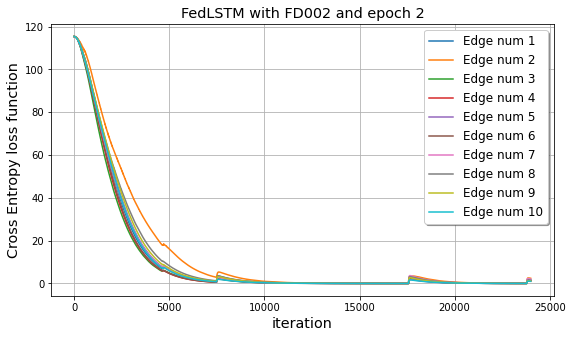

In [37]:
num_workers = 10
iteration_epoch = 3000
epoch = 2
fig, ax = plt.subplots()
fig.set_size_inches(9, 5)
cost_each_worker = np.zeros(shape=(num_workers, 4 * epoch *iteration_epoch))
for worker_i in range(num_workers):
    cost_each_worker[worker_i, :] = np.array(J[worker_i]).flatten()
    plt.plot(cost_each_worker[worker_i, :], label="Edge num " + str(worker_i+1))
plt.title("FedLSTM with FD002 and epoch 2", fontsize="x-large")
plt.ylabel("Cross Entropy loss function", fontsize="x-large")
plt.xlabel("iteration", fontsize="x-large")
plt.grid()
legened = plt.legend(shadow=True, fontsize='large')

dir_logdata_FD002_epoch_2: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD002/Results/epoch_2/"    
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_logdata_FD002_epoch_2))
plt.savefig('J_FD002_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.eps', format='eps', dpi=1200, bbox_inches='tight')
plt.savefig('J_FD002_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.png', format='png', dpi=1200, bbox_inches='tight')

### Plot test models

C:\Users\LO98E8~1\Temp\234/ipykernel_41240/2610979360.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig[i], ax[i] = plt.subplots()


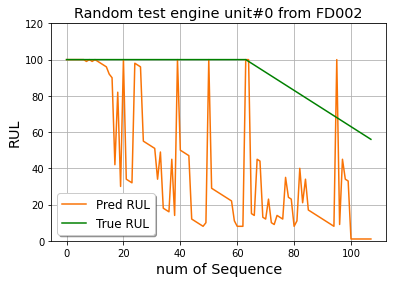

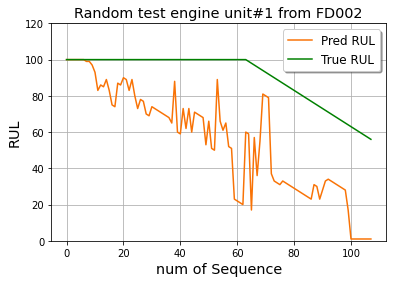

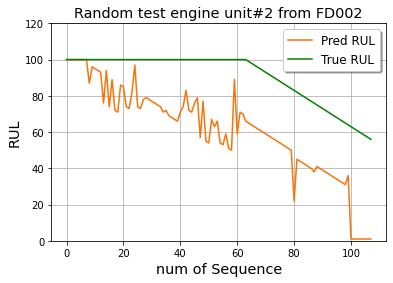

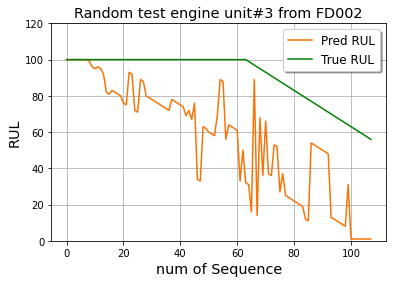

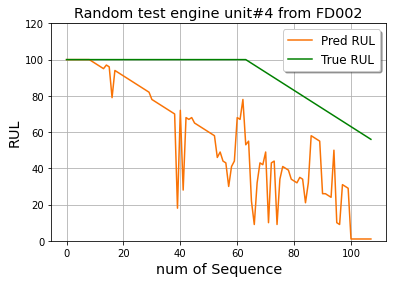

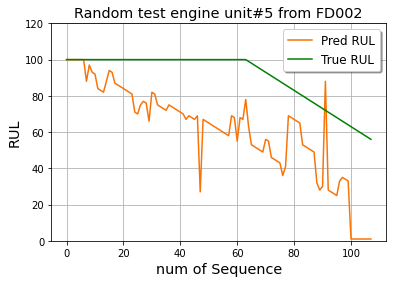

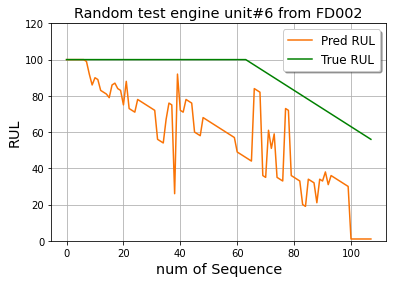

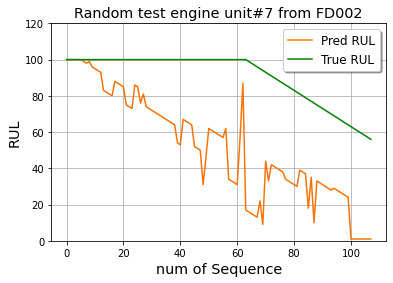

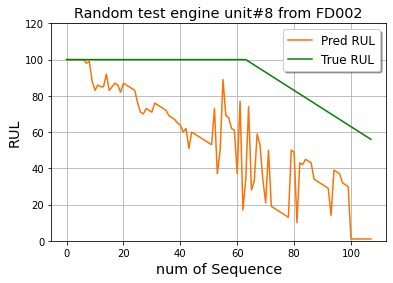

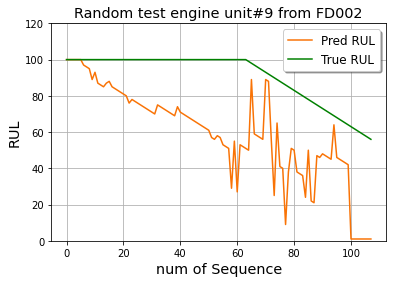

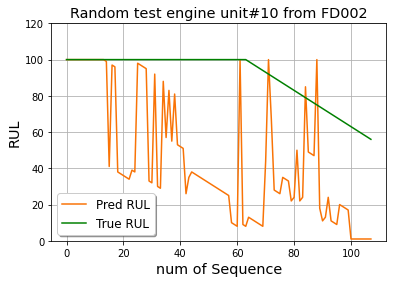

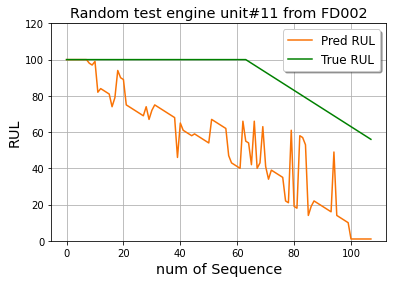

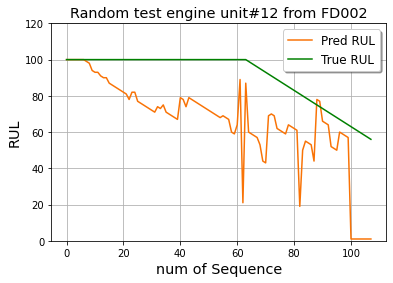

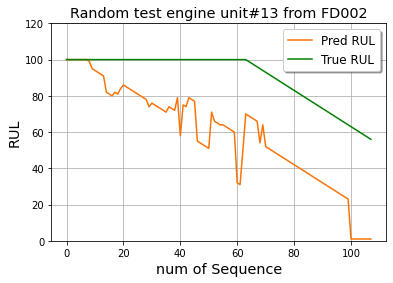

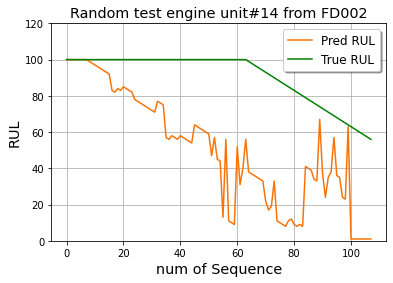

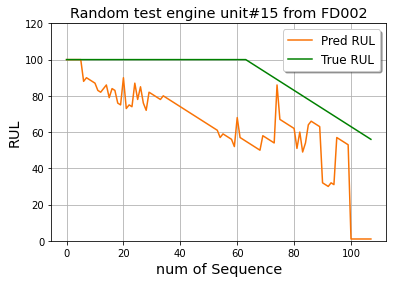

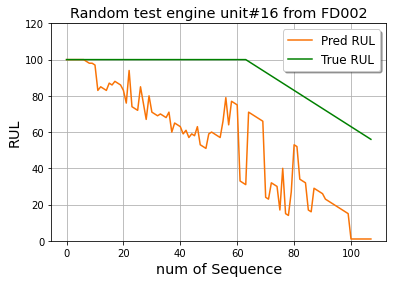

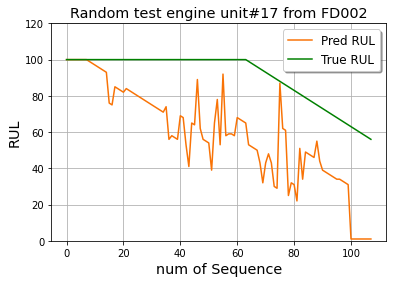

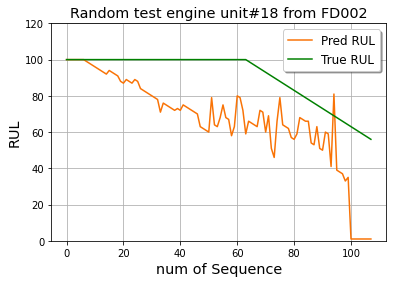

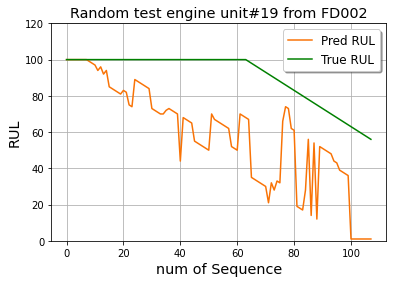

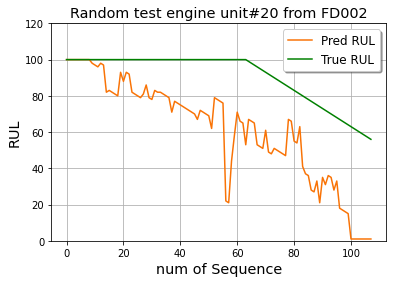

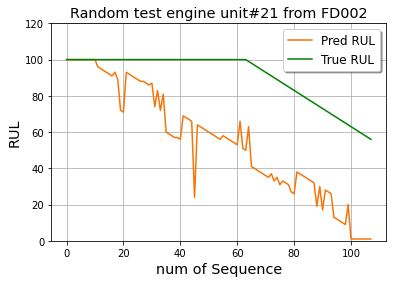

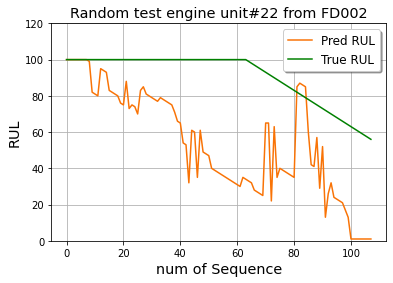

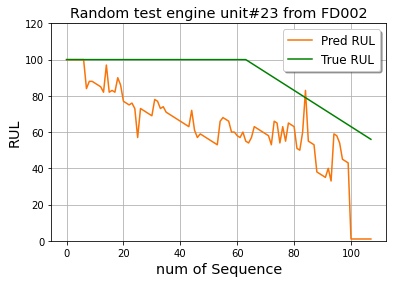

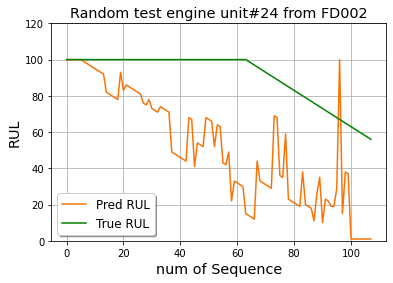

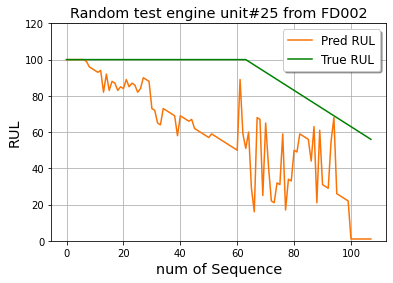

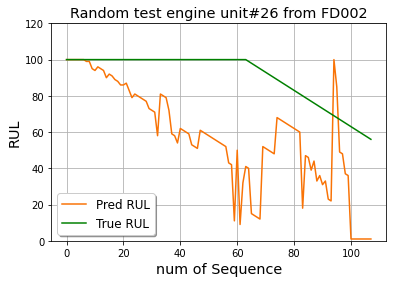

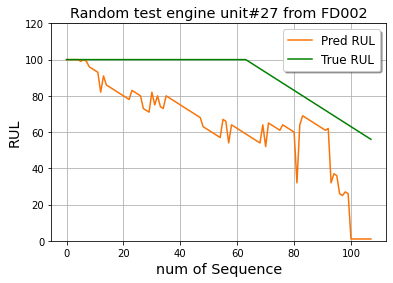

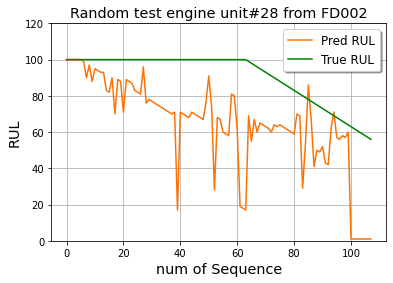

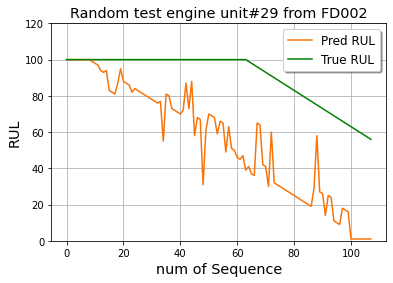

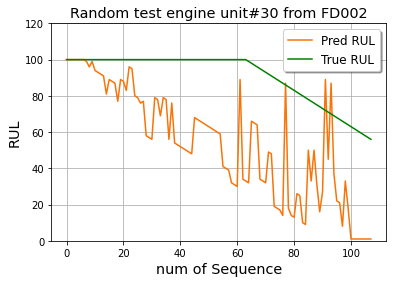

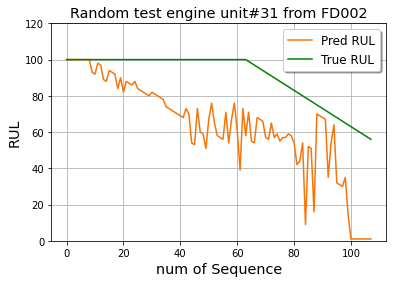

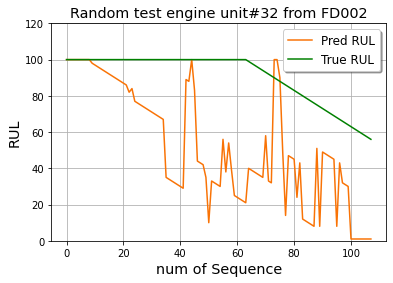

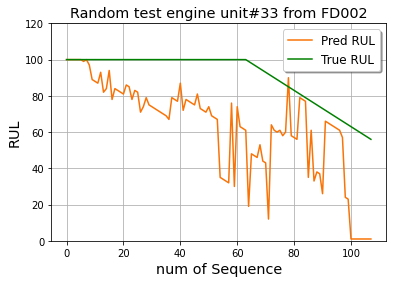

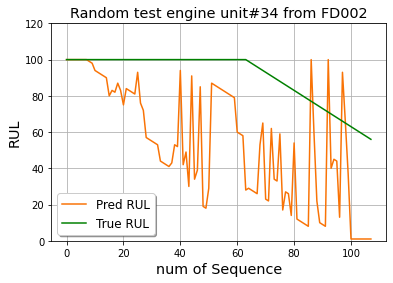

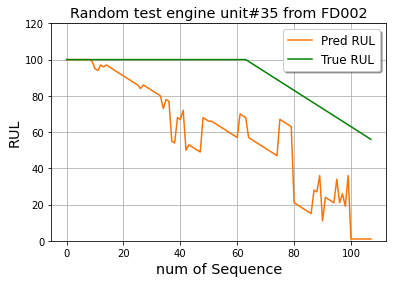

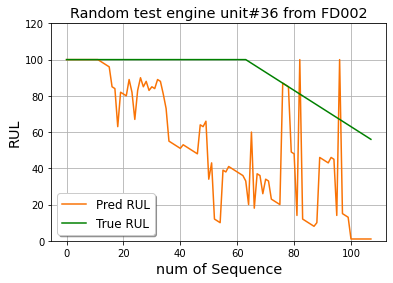

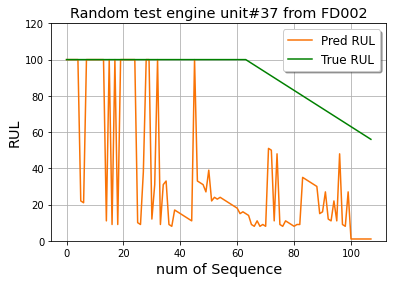

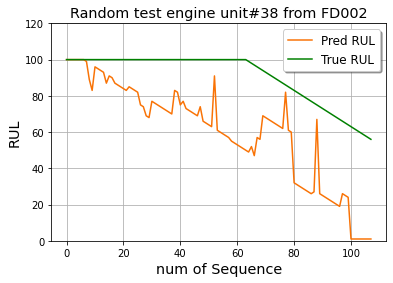

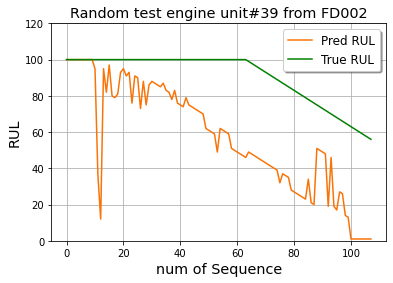

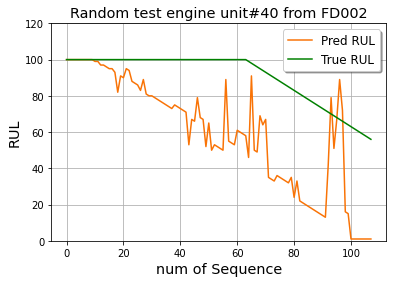

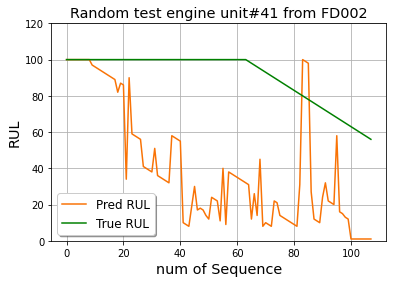

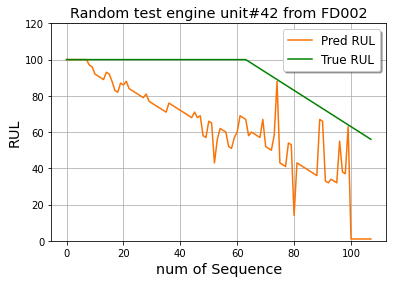

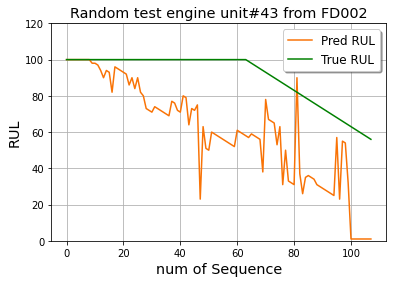

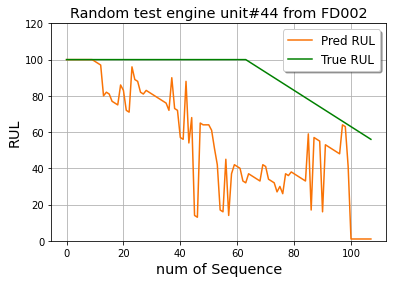

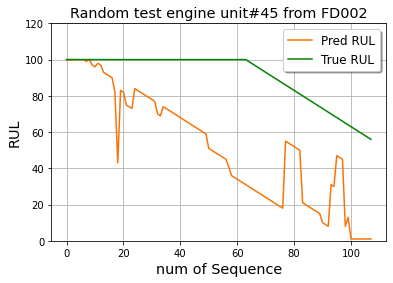

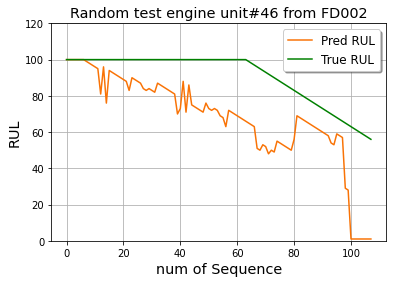

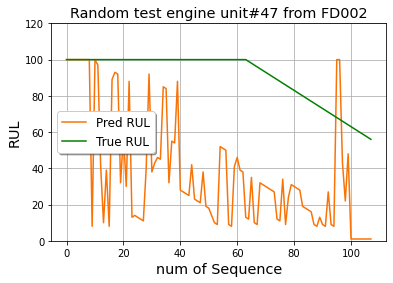

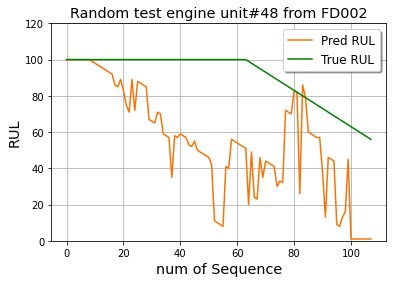

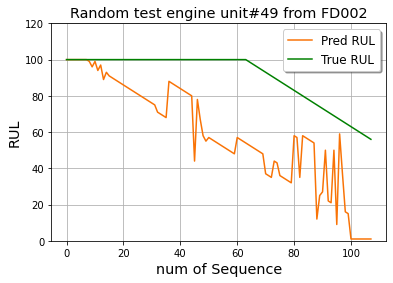

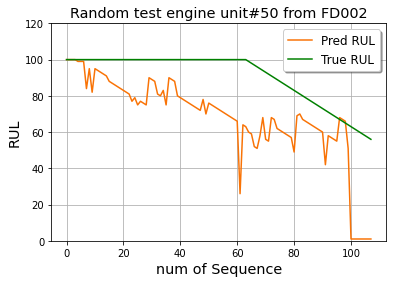

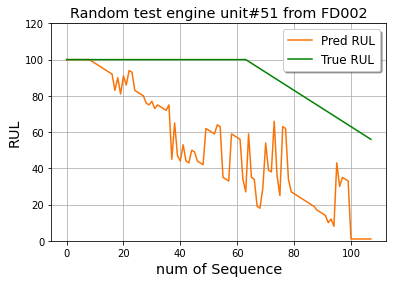

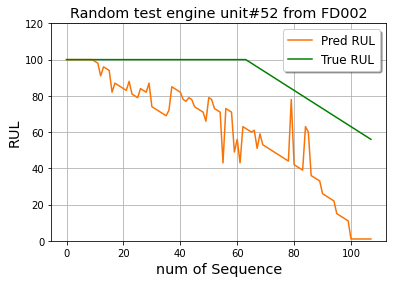

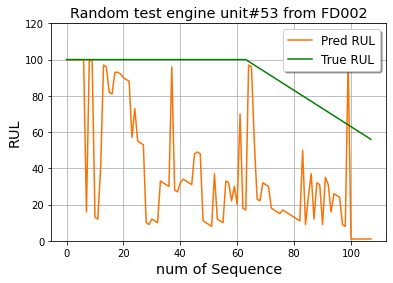

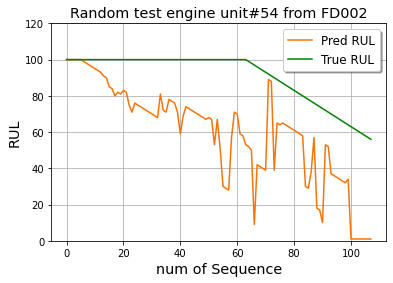

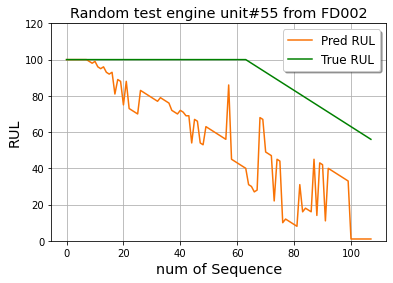

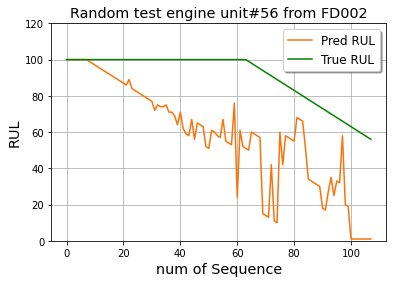

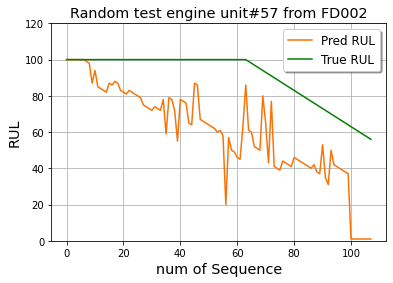

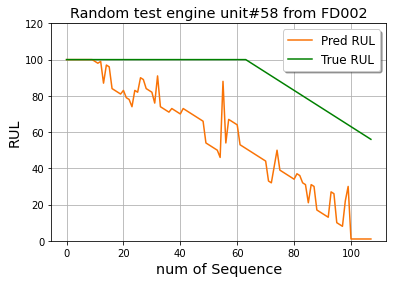

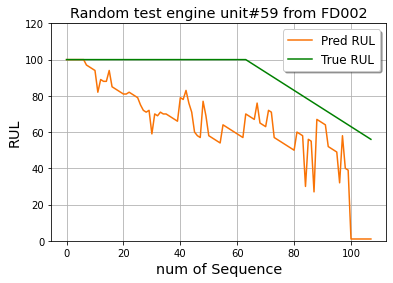

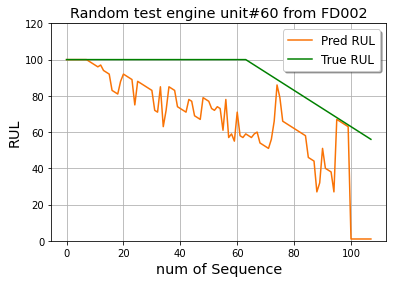

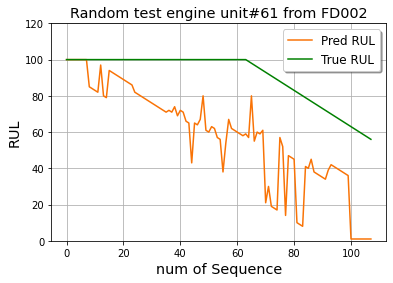

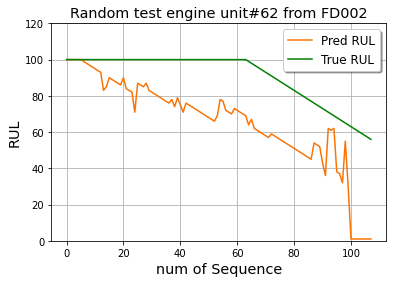

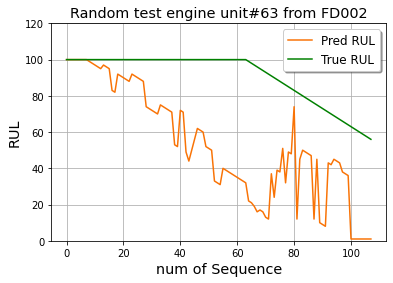

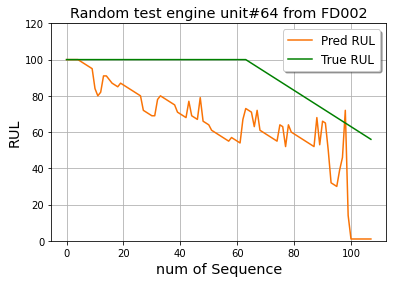

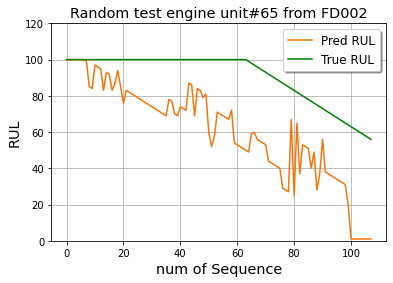

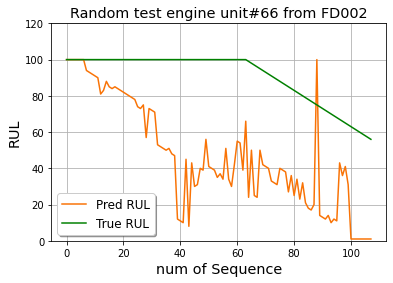

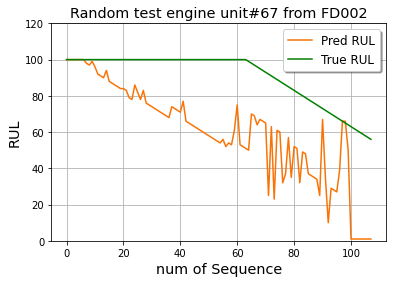

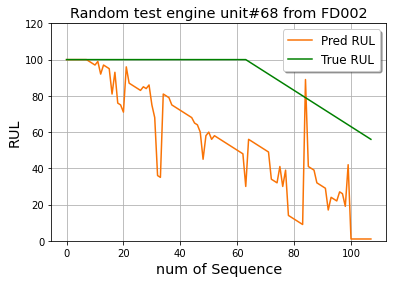

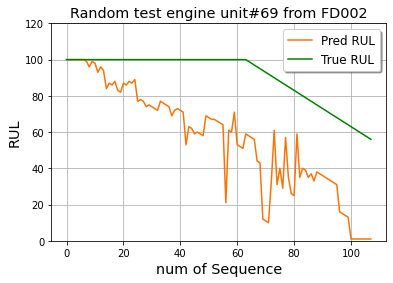

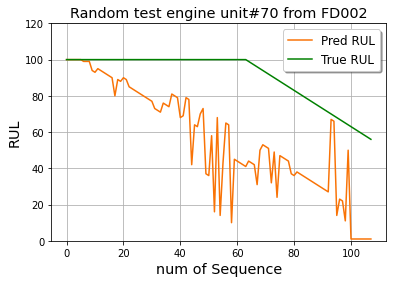

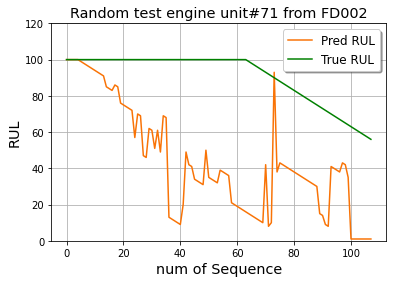

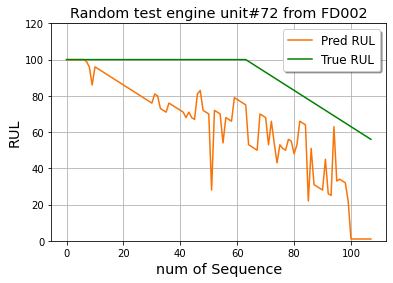

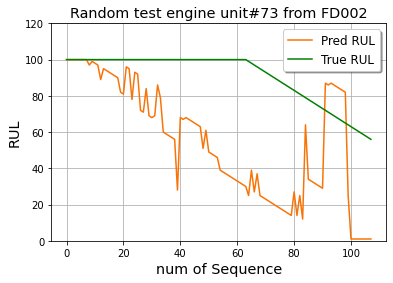

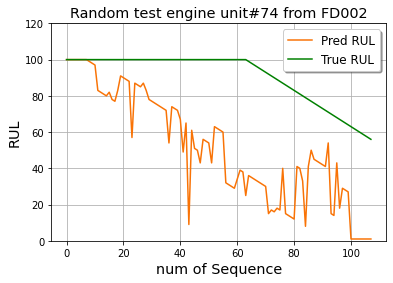

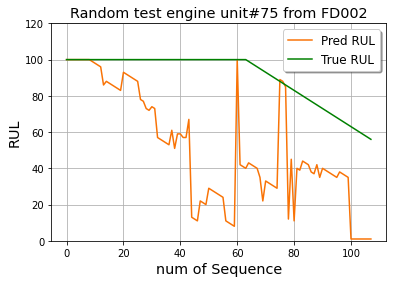

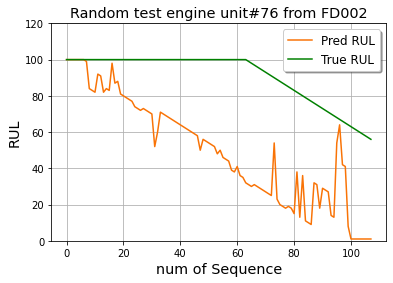

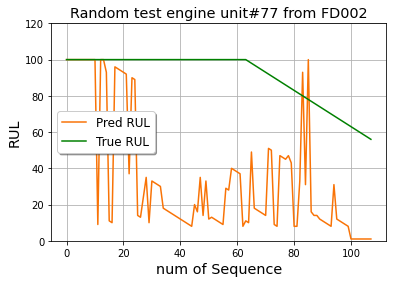

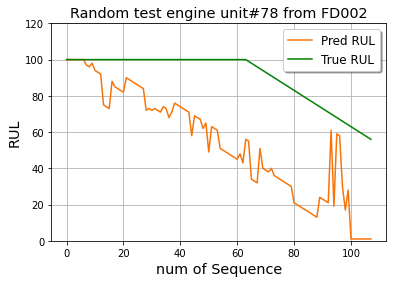

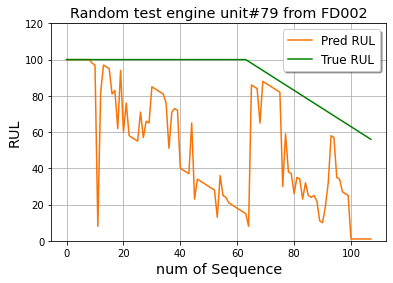

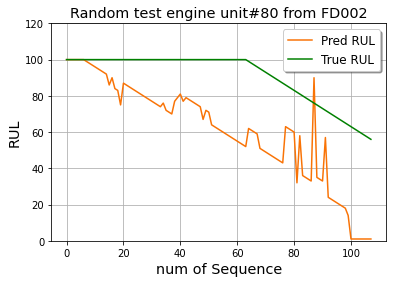

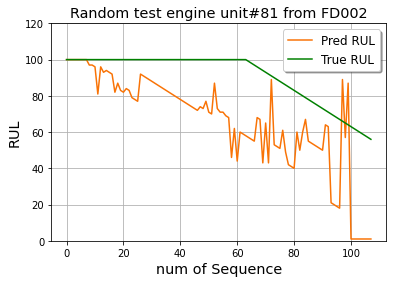

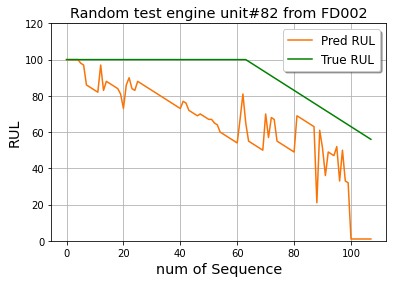

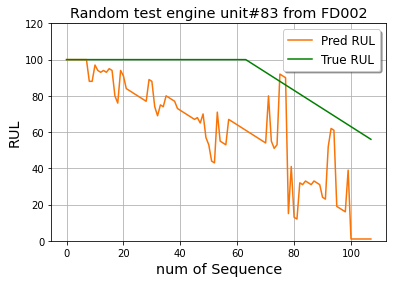

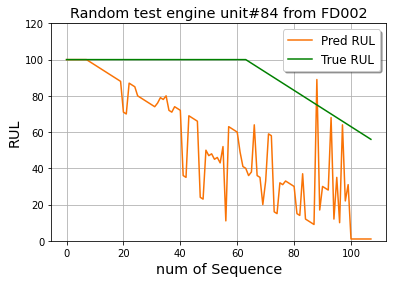

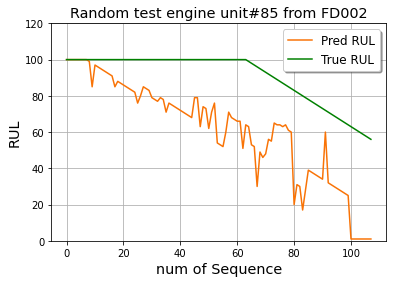

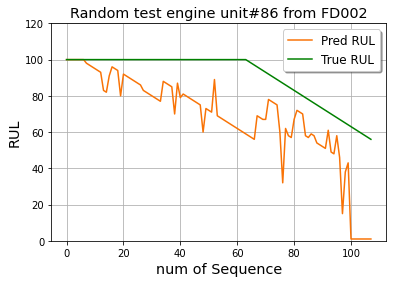

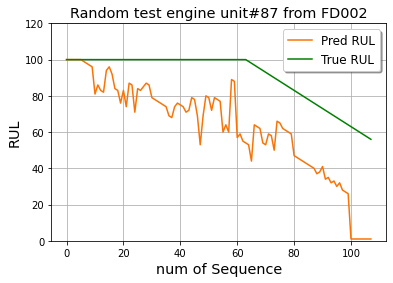

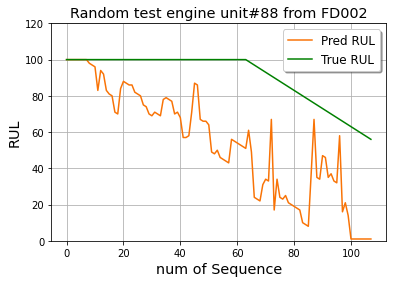

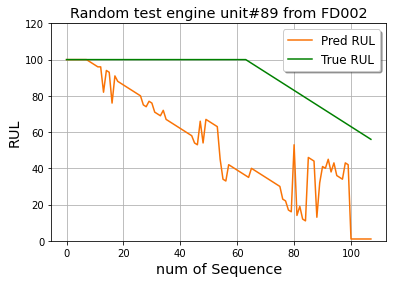

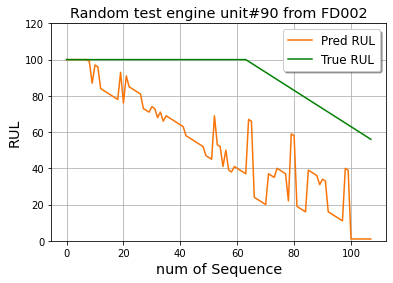

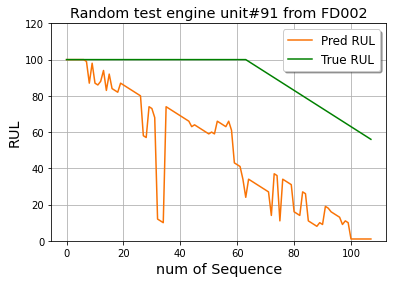

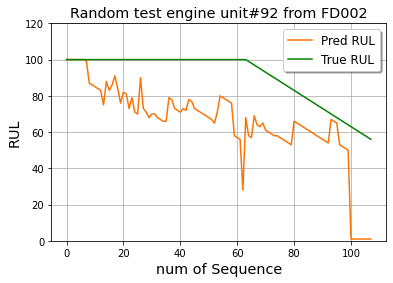

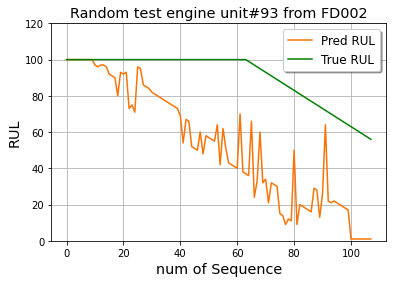

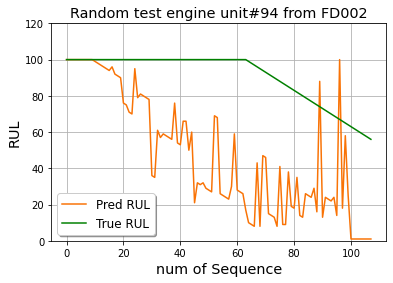

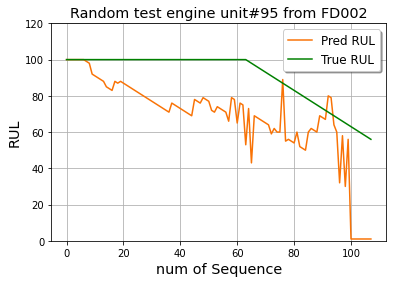

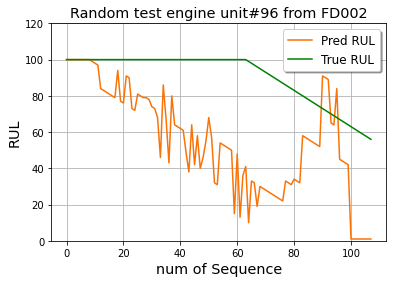

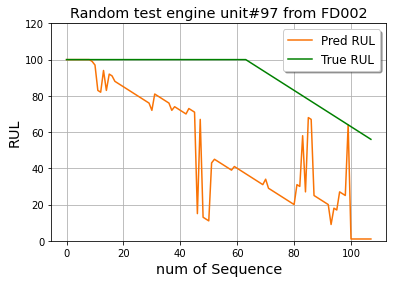

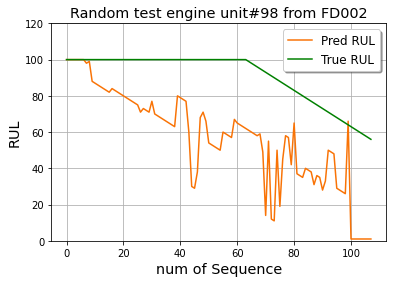

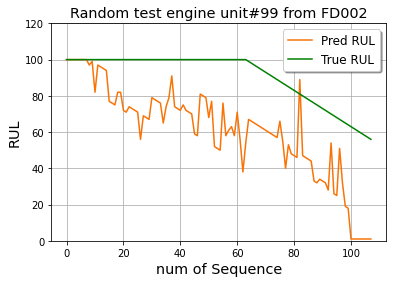

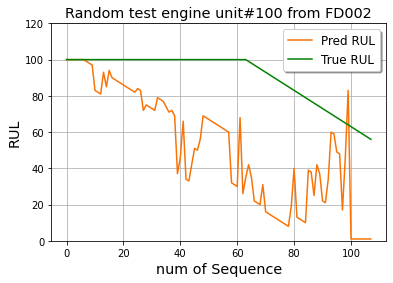

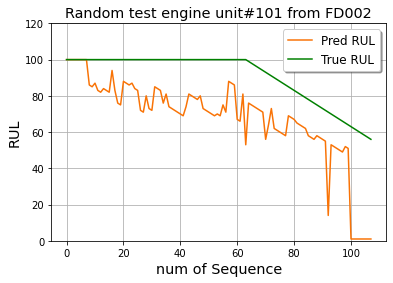

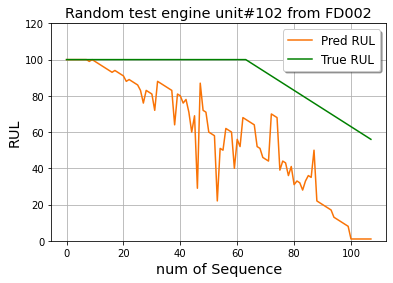

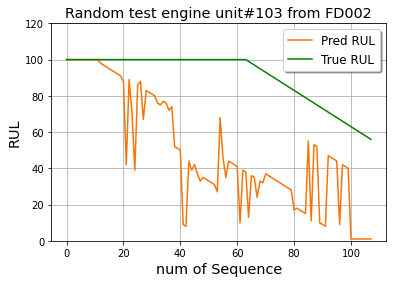

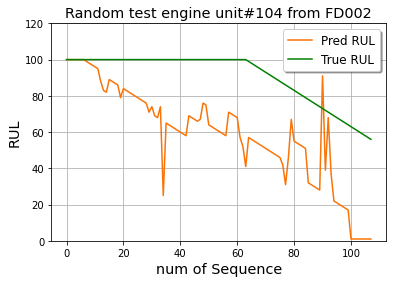

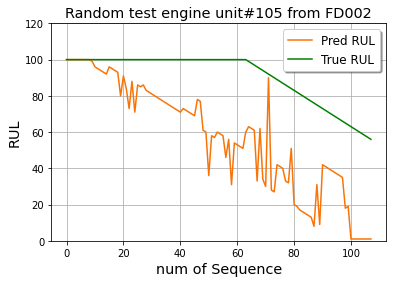

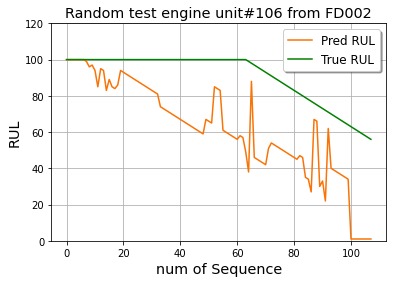

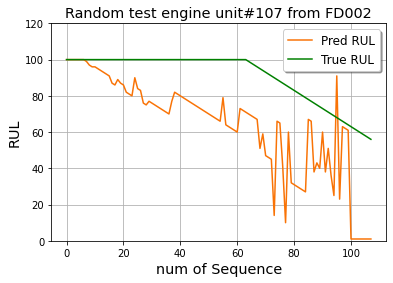

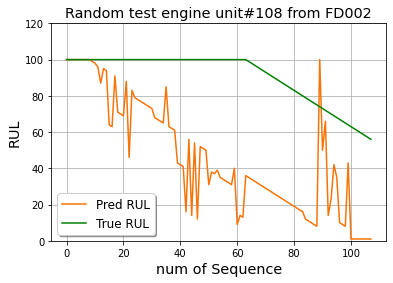

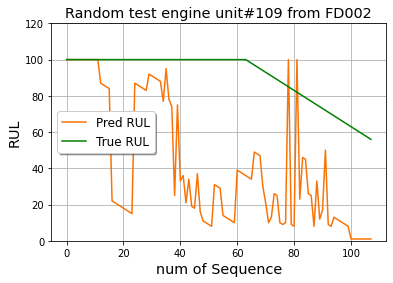

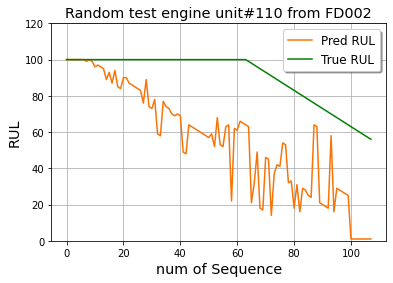

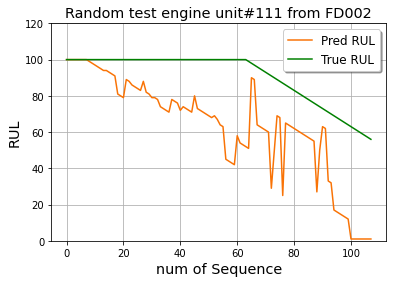

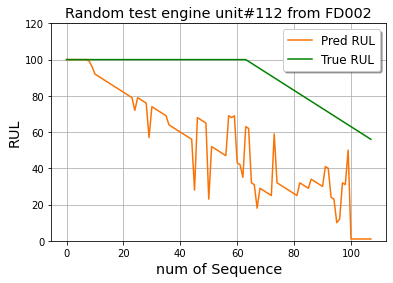

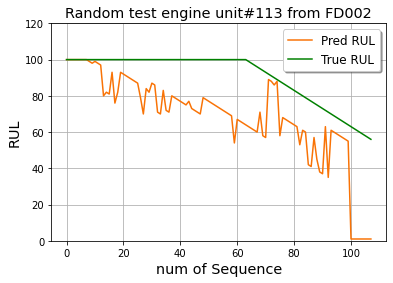

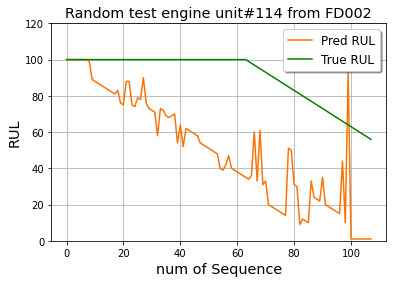

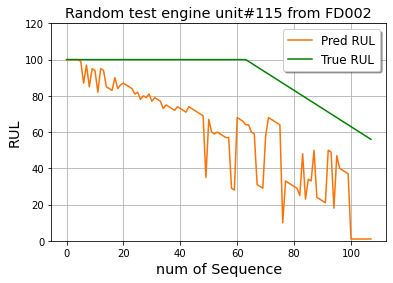

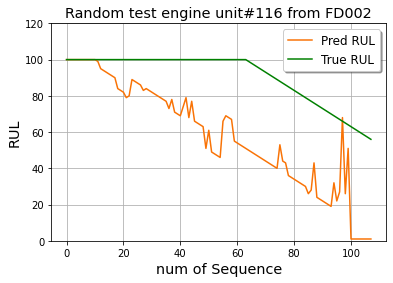

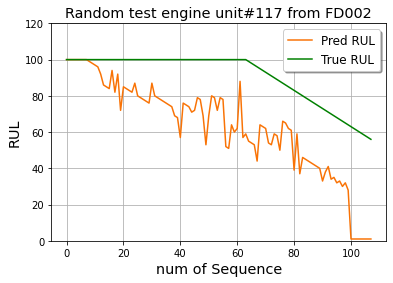

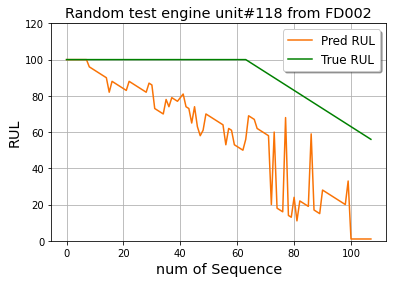

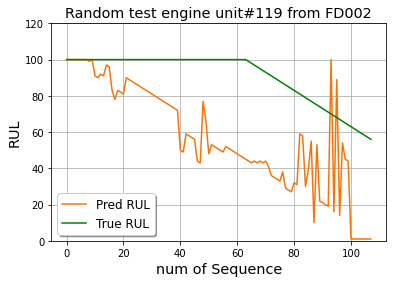

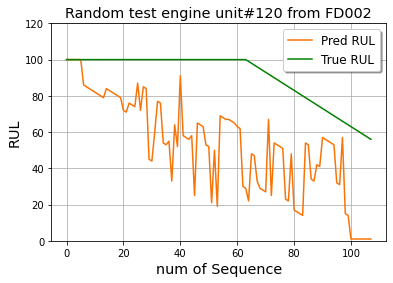

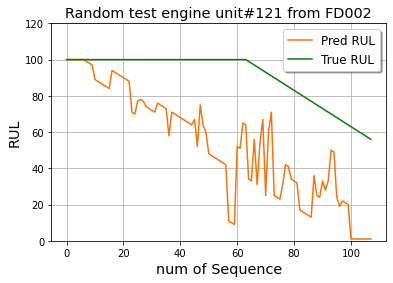

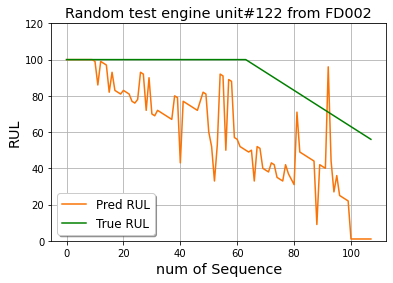

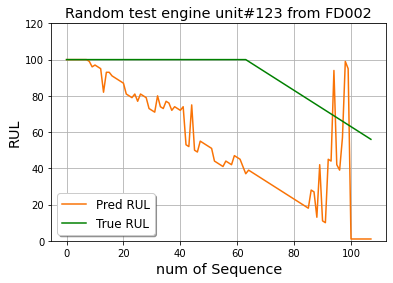

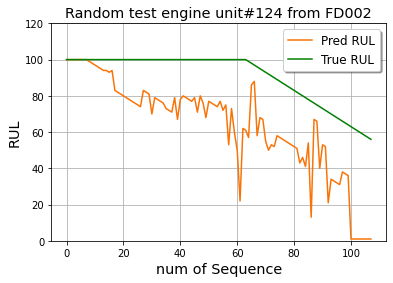

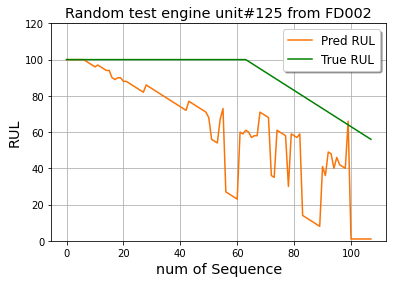

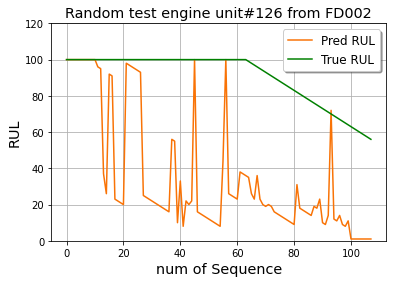

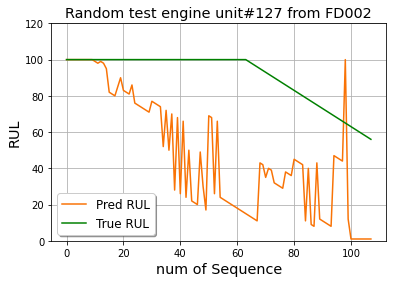

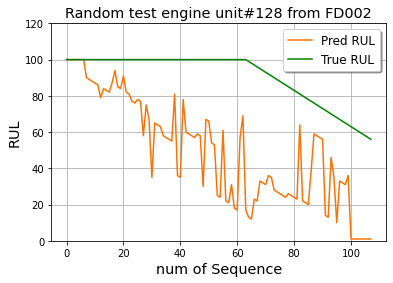

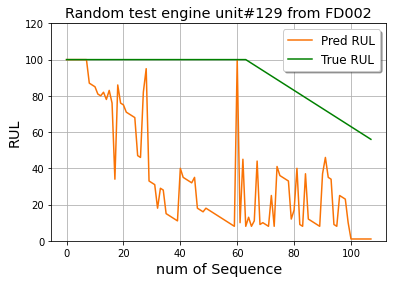

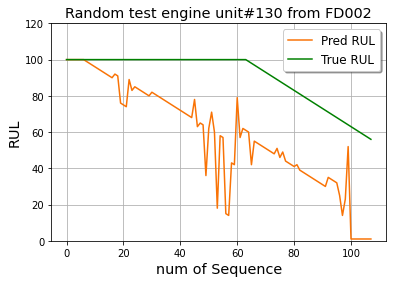

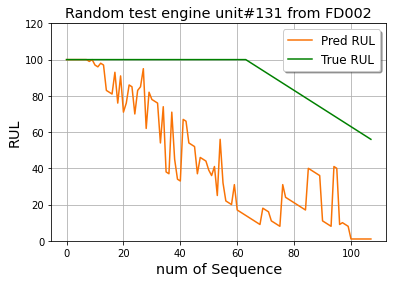

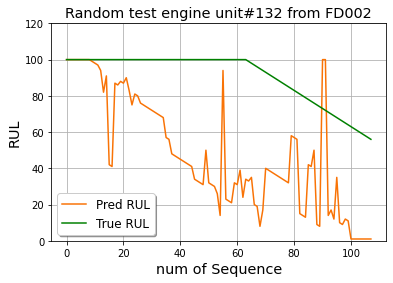

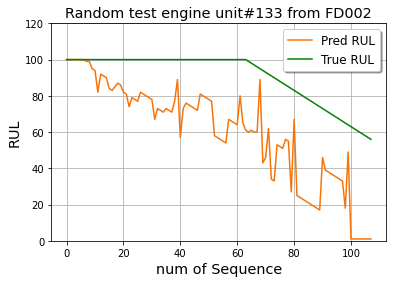

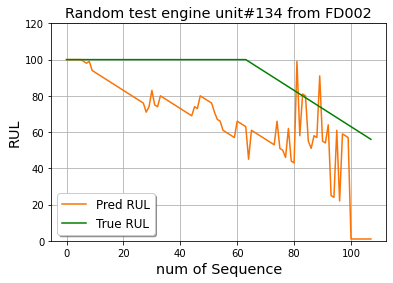

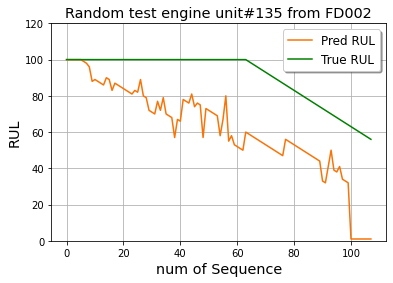

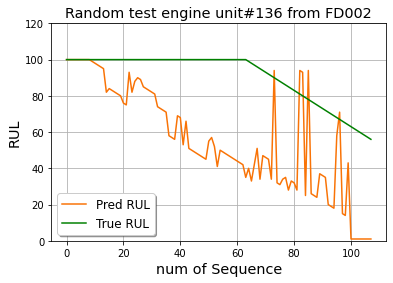

In [40]:
worker_test = LSTM()
fig={}
ax={}
for i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[i], array_params[0])
    fig[i], ax[i] = plt.subplots()
    ax[i].plot(Y_hat, label='Pred RUL', color='#F97306')
    ax[i].plot(Y_test[worker_i], label='True RUL', color='#008000')
    plt.title("Random test engine unit#" + str(i) + " from FD002", fontsize="x-large")
    plt.ylabel("RUL", fontsize="x-large")
    plt.ylim(0, 120)
    plt.xlabel("num of Sequence", fontsize="x-large")
    ax[i].grid()
    ax[i].legend(shadow=True, fontsize='large')
    dir_name: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD002/Results/epoch_2/"
    #plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
    #plt.savefig("RUL_10Workers_Final_Cost_itter_3000_alpha_004_epoch_02"+str(worker_i)+".eps", format='eps', dpi=1200)
    #plt.savefig("RUL_10Workers_Final_Cost_itter_3000_alpha_004_epoch_02"+str(worker_i)+".png", format='png', dpi=1200)

In [41]:
# Save Specific figures
dir_name: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD002/Results/epoch_2/"    
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
fig[59].savefig("FD002 RUL prediction with FedLSTM and epoch 2 for machine number_" + str(59) + ".eps", format='eps', dpi=1200, bbox_inches='tight')
fig[59].savefig("FD002 RUL prediction with FedLSTM and epoch 2 for machine number_" + str(59) + ".png", format='png', dpi=1200, bbox_inches='tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### RMSE and SCORE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[32.61322741]


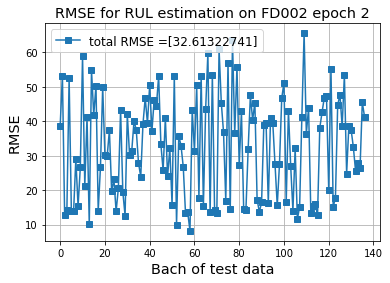

In [42]:
# RMSE and Scoring factor epoch 2
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


RMSE = np.zeros(shape=(len(X_test),1))


for worker_i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[worker_i], array_params[0])
    RMSE[worker_i] = rmse(Y_hat, Y_test[worker_i])

fig, ax = plt.subplots()
plt.plot(RMSE, label='RMSE', marker = 's')
plt.title("RMSE for RUL estimation on FD002 epoch 2", fontsize="x-large")
plt.ylabel("RMSE", fontsize="x-large")
plt.xlabel("Bach of test data", fontsize="x-large")
plt.grid()

RMSE_epoch_2 = np.sum(RMSE, axis=0)/len(X_test)
labels = []
labels.append("total RMSE ="+str(RMSE_epoch_2))

plt.legend(labels, loc='best', fontsize='large')


print(RMSE_epoch_2)
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
plt.savefig("RMSE for RUL estimation FedLSTM on test dataset FD002 epoch 2.eps", format='eps', dpi=1200, bbox_inches='tight')
plt.savefig("RMSE for RUL estimation FedLSTM on test dataset FD002 epoch 2.png", format='png', dpi=1200, bbox_inches='tight')

[ 1.13549420e+03 -8.88626046e+01  1.52026181e+01  2.06314482e+02
 -8.50135783e+01  5.57765178e+02  2.34017534e+02 -7.86778825e+01
  1.28637165e+01 -6.34314917e+01 -7.99945635e+01 -6.04688180e+01
 -8.62267121e+01  1.95019454e+01 -8.89610307e+01 -9.02670516e+01
 -8.93830804e+01  1.39849788e+02 -7.22789790e+01 -8.73363562e+01
 -8.07813605e+01 -8.09676370e+01 -6.40658293e+01 -3.20432384e+00
  1.15696195e+03  3.77463843e+02  1.70355751e+03 -8.80248143e+01
  5.92032748e+02 -2.61524082e+01 -7.09552681e+01 -7.78515837e+01
  7.66305500e+01 -8.62294830e+01  1.62262932e+02 -7.55800041e+01
  2.41580332e+03 -2.50345750e+01 -8.73268422e+01 -8.42834209e+01
 -8.19538850e+01  1.03178753e+03 -8.73414041e+01 -8.41524845e+01
 -8.73179213e+01 -8.16321759e+01 -7.31029810e+01  3.05556277e+03
  2.61506154e+02 -8.02407982e+01  2.07503903e+02 -8.68098838e+01
  1.48838890e+02  4.15339595e+03 -8.10140849e+01 -7.34708908e+01
  1.50579808e+02  6.06042773e+01  2.17647170e+00 -8.85541600e+01
 -7.83225095e+01 -8.87552

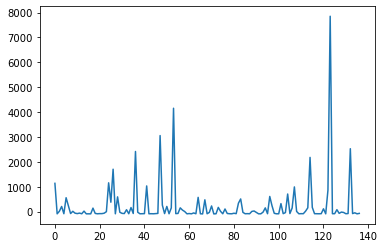

In [44]:
def each_score(predictions, targets):
    tmp = np.zeros(shape=(1, len(predictions)))
    for i in range(len(predictions)):
        Yi = predictions[i] - targets[i]
        if Yi >= 0:
            tmp[:, i] = (np.exp(Yi/10)-1)   
        else:
            tmp[:, i] = np.exp(Yi/13)-1
    return tmp
    
SCORE = np.zeros(shape=(len(X_test), X_test[0].shape[0]))

for worker_i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[worker_i], array_params[0])
    SCORE[worker_i, :] = each_score(Y_hat, Y_test[worker_i])
    
print(np.sum(SCORE, axis=1))
plt.plot(np.sum(SCORE, axis=1))
print("Final value for SCORE:",np.sum(SCORE)/len(X_test))

## Load Cost functions and Parameters

In [101]:
import numpy as np
import pickle
# from model import *

# Import libraries
from random import uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import time
import math
import sys
import random

dir_logdata_FD002_epoch_2: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD002/LogData/epoch_2/ "    
# Load cost from a PKL file
a_file = open(dir_logdata_FD002_epoch_2 + "J_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.pkl", "rb")
J = pickle.load(a_file)
a_file.close()

# Load params data from a PKL file
a_file = open(dir_logdata_FD002_epoch_2 + "array_params_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.pkl", "rb")
array_params = pickle.load(a_file)
print(array_params)
a_file.close()

[{'Wf': array([[-0.18564977,  0.0322141 , -0.04818845, ..., -0.12048841,
         0.09804777,  0.05325   ],
       [-0.06109197,  0.09811411, -0.04168961, ...,  0.08114126,
         0.08047905,  0.05512676],
       [-0.12158022, -0.13627538, -0.17668155, ..., -0.20193493,
         0.20272957,  0.12999881],
       ...,
       [ 0.01255876,  0.16984161,  0.03624951, ..., -0.08108413,
         0.04121908,  0.00478767],
       [ 0.02036318,  0.06390896, -0.02934949, ...,  0.06846599,
         0.09238949,  0.08252651],
       [ 0.04791726,  0.01360442, -0.01159031, ...,  0.07645322,
         0.05202115,  0.05020851]]), 'bf': array([[1.05032015],
       [1.08373612],
       [1.08920687],
       [1.02828693],
       [1.0825476 ],
       [1.14573225],
       [1.04020056],
       [1.06803859],
       [1.07327751],
       [1.0113719 ],
       [1.0307025 ],
       [1.02641318],
       [1.07471422],
       [1.07047969],
       [1.10095669],
       [1.0111647 ],
       [1.06367949],
       [1.00765